### Simple 2D exampling of `DDPM`

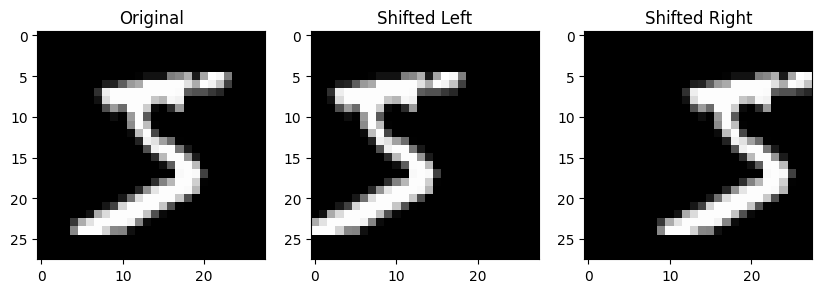

In [1]:
import torch
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='../data', train=True, download=True, transform=transform)

# Function to shift image content
def shift_image(image, direction):
    image = image.squeeze().numpy()
    shifted_image = np.zeros_like(image)
    if direction == 'left':
        shifted_image[:, :-5] = image[:, 5:]  # Shift left
        label = [1, 0]  # left = 1, right = 0
    elif direction == 'right':
        shifted_image[:, 5:] = image[:, :-5]  # Shift right
        label = [0, 1]  # left = 0, right = 1
    return torch.tensor(shifted_image, dtype=torch.float32).unsqueeze(0), torch.tensor(label, dtype=torch.float32)

# Example of how to use the function
image, original_label = train_dataset[0]
left_image, left_label = shift_image(image, 'left')
right_image, right_label = shift_image(image, 'right')

# Display the original and modified images
plt.figure(figsize=(10, 3))
plt.subplot(1, 3, 1)
plt.title('Original')
plt.imshow(image.squeeze(), cmap='gray')
plt.subplot(1, 3, 2)
plt.title('Shifted Left')
plt.imshow(left_image.squeeze(), cmap='gray')
plt.subplot(1, 3, 3)
plt.title('Shifted Right')
plt.imshow(right_image.squeeze(), cmap='gray')
plt.show()

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from diffusion import (
    get_ddpm_constants,
    DiffusionUNetLegacy,
    forward_sample,
    eval_ddpm_2d,
)
from util import (
    get_torch_size_string,
    plot_ddpm_2d_result,
)
from dataset import mnist
np.set_printoptions(precision=3)
th.set_printoptions(precision=3)
plt.rc('xtick',labelsize=8)
plt.rc('ytick',labelsize=8)
%matplotlib inline
%config InlineBackend.figure_format='retina'
print ("PyTorch version:[%s]."%(th.__version__))

PyTorch version:[2.3.1+cu118].


### Initialize

In [3]:
dc = get_ddpm_constants(
    schedule_name = 'cosine', # 'linear', 'cosine'
    T             = 1000,
    np_type       = np.float32,
)
# device = 'cuda' if th.cuda.is_available() else 'mps'
# print ("device:[%s]"%(device))


# GPU 할당 변경하기
GPU_NUM = 1 # 원하는 GPU 번호 입력
device = th.device(f'cuda:{GPU_NUM}' if th.cuda.is_available() else 'cpu')
th.cuda.set_device(device) # change allocation of current GPU
print ('Current cuda device ', th.cuda.current_device()) # check
dummy_example = th.randn(10).to(device)
print(dummy_example.device)  # Output should be "cuda:1"

# Additional Infos
if device.type == 'cuda':
    print(th.cuda.get_device_name(GPU_NUM))
    print('Memory Usage:')
    print('Allocated:', round(th.cuda.memory_allocated(GPU_NUM)/1024**3,1), 'GB')
    print('Cached:   ', round(th.cuda.memory_cached(GPU_NUM)/1024**3,1), 'GB')

Current cuda device  1
cuda:1
NVIDIA GeForce RTX 3090 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


/home/ksm/.conda/envs/DDPM/lib/python3.12/site-packages/torch/cuda/memory.py:440: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  warnings.warn(


### Training data `x_0`: [N x C x W x H]

In [4]:
# train_iter,test_iter,train_data,train_label,test_data,test_label = \
#     mnist(root_path='../data',batch_size=128)
# x_0 = train_data[:,None,:,:].to(device)/255.
# print ("MNIST ready. train_data:[%s]"%(get_torch_size_string(x_0)))

In [5]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='../data', train=True, download=True, transform=transform)

# Function to shift image content
def shift_image(image, direction, original_label, device):
    image = image.squeeze().numpy()
    shifted_image = np.zeros_like(image)
    if direction == 'left':
        shifted_image[:, :-5] = image[:, 5:]  # Shift left
        label = [original_label+1, 0, 1, 0]  # left shift with original label
    elif direction == 'right':
        shifted_image[:, 5:] = image[:, :-5]  # Shift right
        label = [0, original_label+1, 0, 1]  # right shift with original label
    return torch.tensor(shifted_image, dtype=torch.float32).unsqueeze(0).to(device), torch.tensor(label, dtype=torch.float32).to(device)

# Dataset class for modified MNIST
class ModifiedMNISTDataset(Dataset):
    def __init__(self, original_dataset, device):
        self.original_dataset = original_dataset
        self.new_images = []
        self.new_labels = []
        self.device = device
        self._process_dataset()
    
    def _process_dataset(self):
        for image, original_label in self.original_dataset:
            left_image, left_label = shift_image(image, 'left', original_label, self.device)
            right_image, right_label = shift_image(image, 'right', original_label, self.device)
            
            self.new_images.append(left_image)
            self.new_labels.append(left_label)
            self.new_images.append(right_image)
            self.new_labels.append(right_label)
    
    def __len__(self):
        return len(self.new_images)
    
    def __getitem__(self, idx):
        return self.new_images[idx], self.new_labels[idx]

# Create the modified dataset
modified_train_dataset = ModifiedMNISTDataset(train_dataset, device)

In [6]:
# torch.save(modified_train_dataset, 'modified_mnist_dataset.pth')

In [7]:
index = 0
image, labels = modified_train_dataset[index]
label_structure = labels.tolist()  # Convert to list for readability

print(f"Label Structure: {label_structure}")
print(image)
print(labels)

Label Structure: [6.0, 0.0, 1.0, 0.0]
tensor([[[0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
          0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
          0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000],
         [0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
          0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
          0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000],
         [0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
          0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
          0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000],
         [0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
          0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
          0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000],
         [0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.

### Embeddings

In [8]:
for modified_train_data in modified_train_dataset:
    image, labels = modified_train_data
    print(labels)
    break

tensor([6., 0., 1., 0.], device='cuda:1')


In [9]:
x_0_list = []
embedding_vector_list = []
for i in range(len(modified_train_dataset)):
    image, image_labels = modified_train_dataset[i]
    x_0_list.append(image)
    embedding_vector_list.append(image_labels)

# Stack all images to form the final x_0 tensor
x_0 = torch.stack(x_0_list, dim=0)
embedding_vectors_tensor = torch.stack(embedding_vector_list, dim=0)

print(x_0.shape)
print(embedding_vectors_tensor.shape)
# print(embedding_vector_list.shape)
test_embedding_vector_5_L = torch.tensor([6,0,1,0], dtype=torch.float32).to(device)
test_embedding_vector_9_R = torch.tensor([0,10,0,1], dtype=torch.float32).to(device)
test_embedding_vector_5_L_9_R = torch.tensor([6,10,1,1], dtype=torch.float32).to(device)

torch.Size([120000, 1, 28, 28])
torch.Size([120000, 4])


### Train 

it:[      0][0.0]% loss:[0.8270]


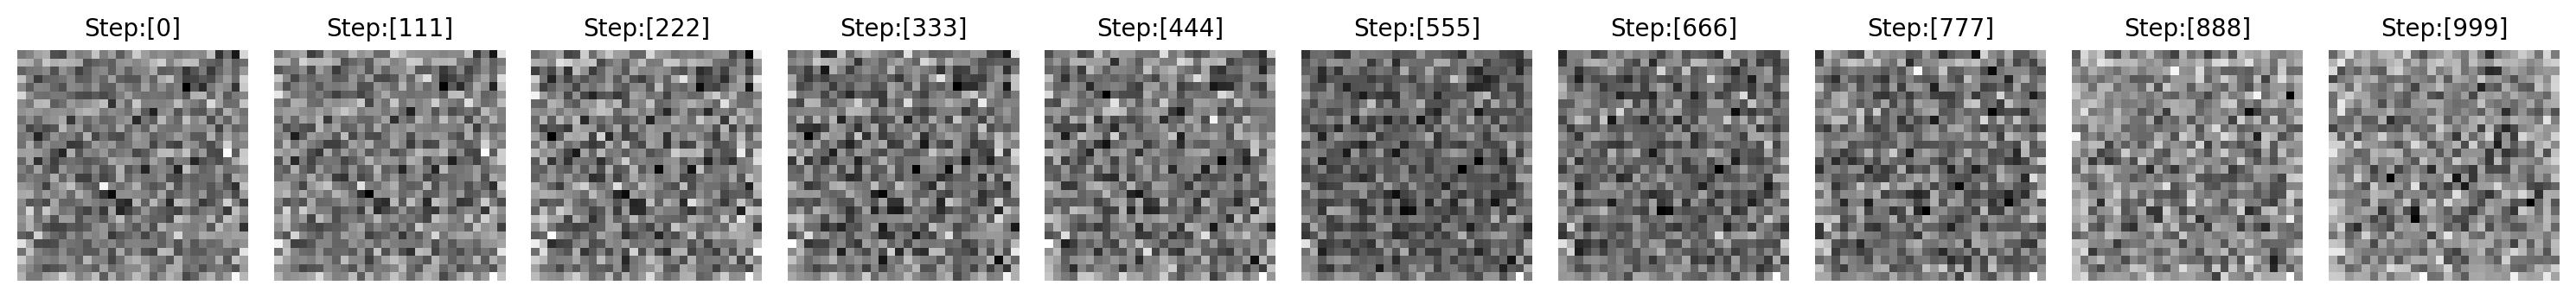

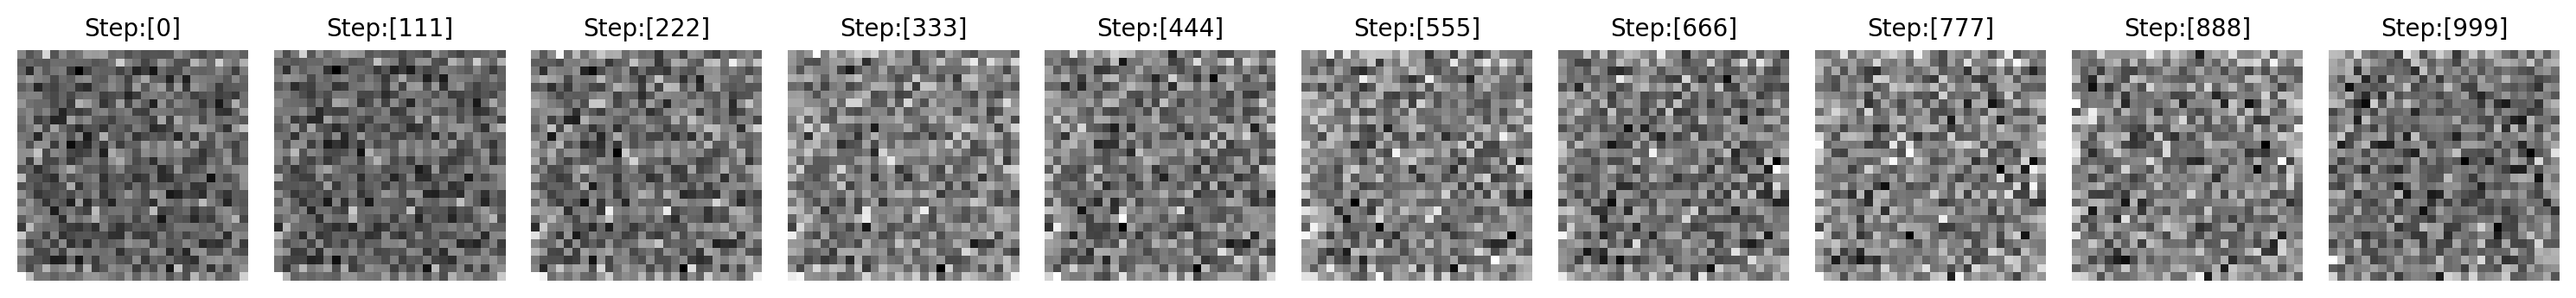

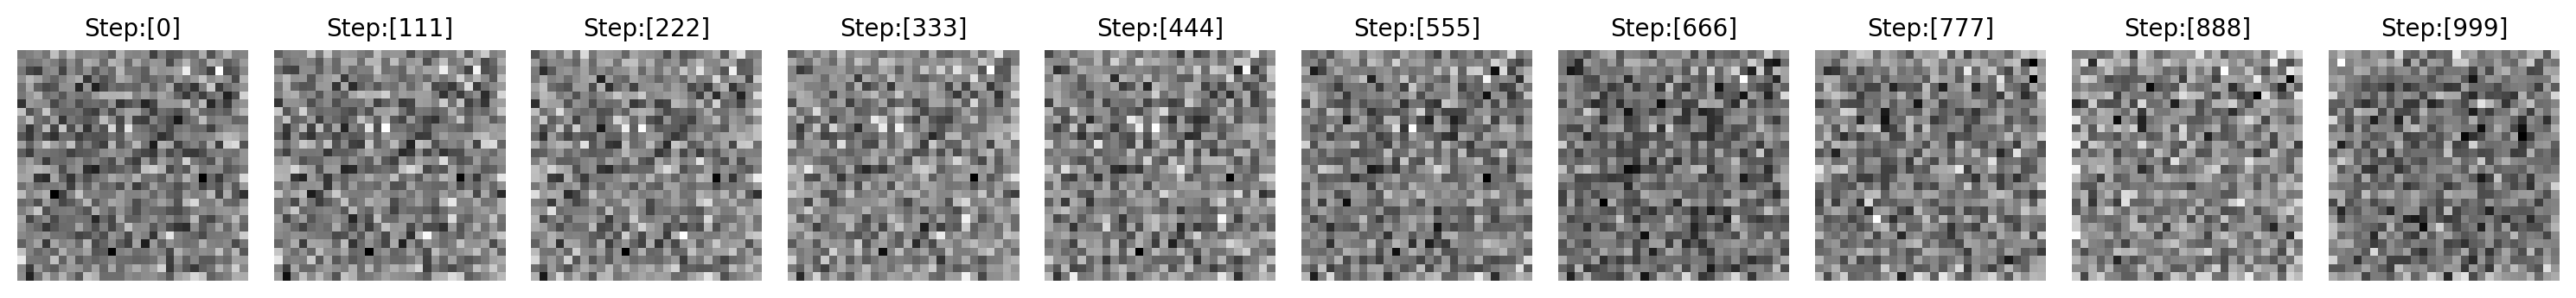

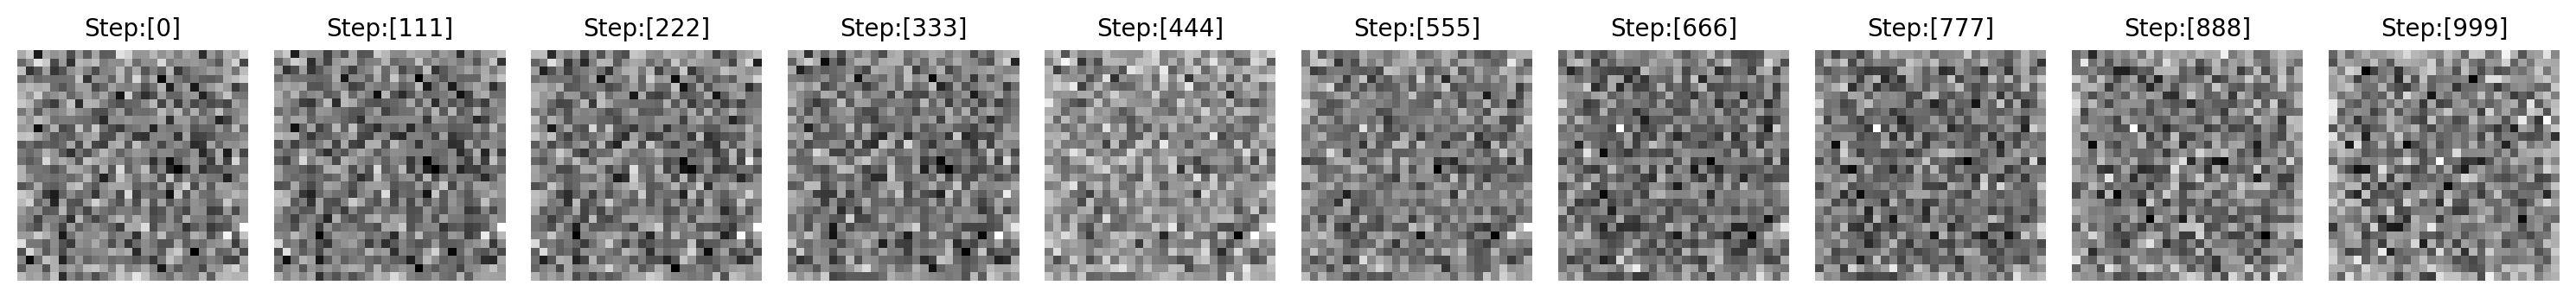

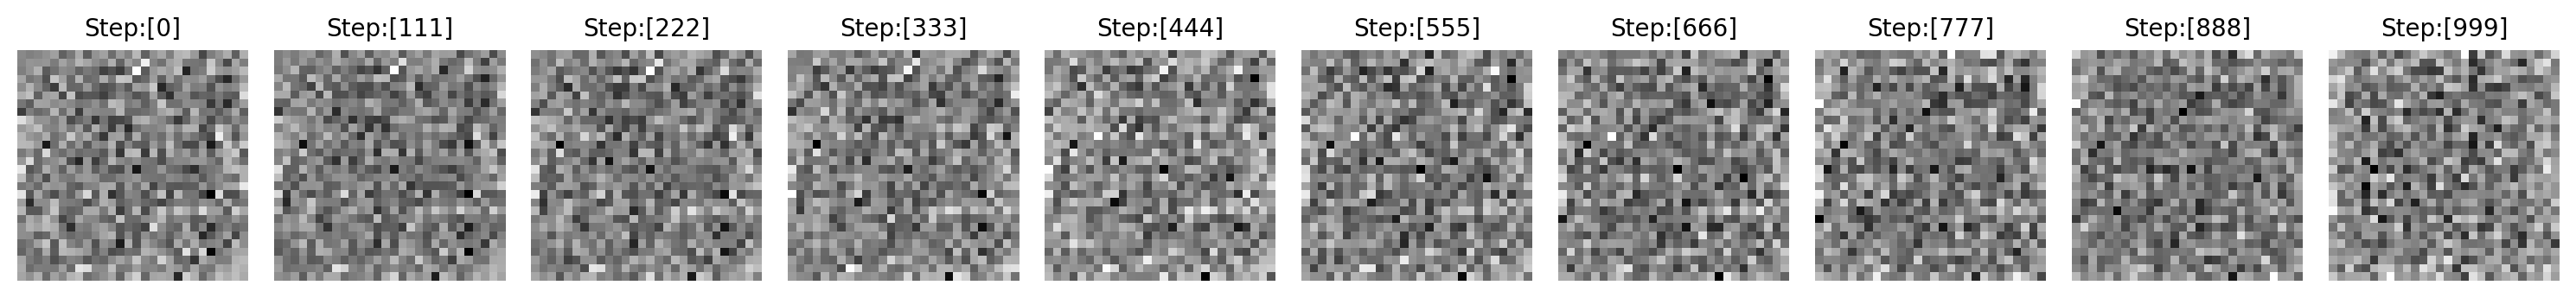

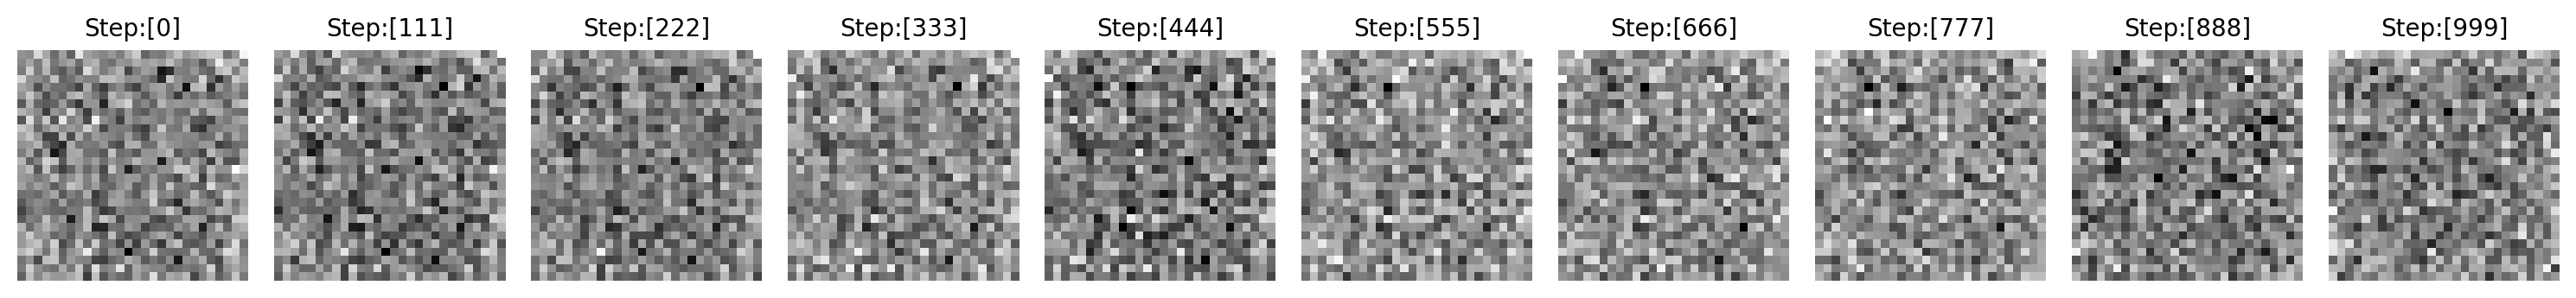

it:[   1000][10.0]% loss:[0.0983]
it:[   2000][20.0]% loss:[0.0780]


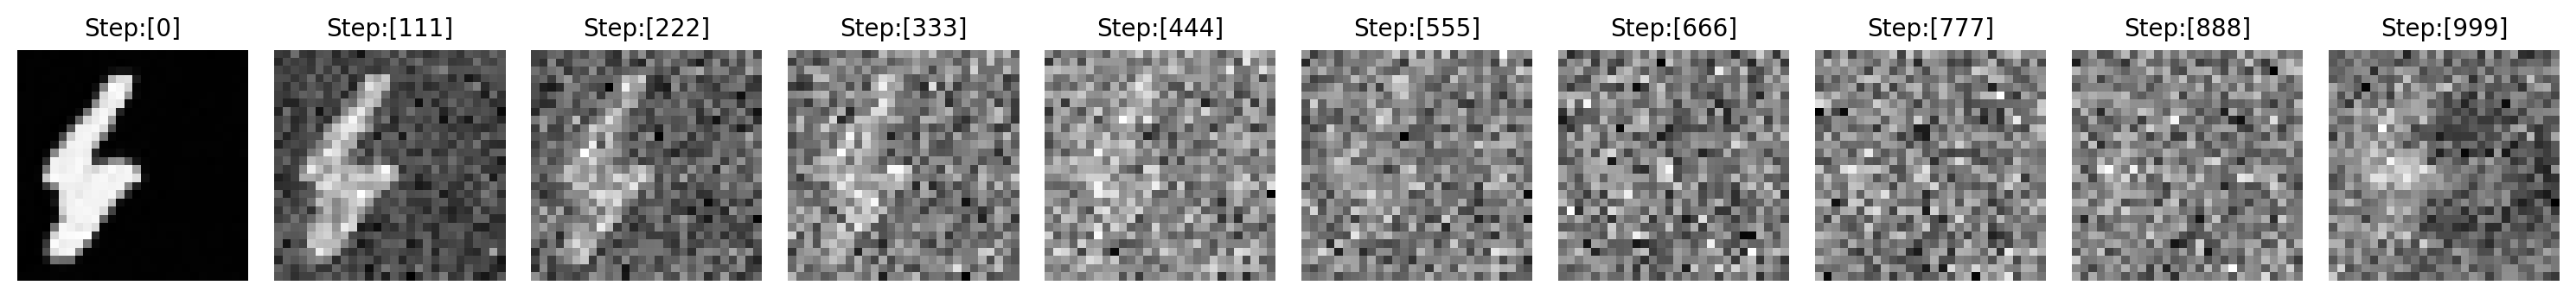

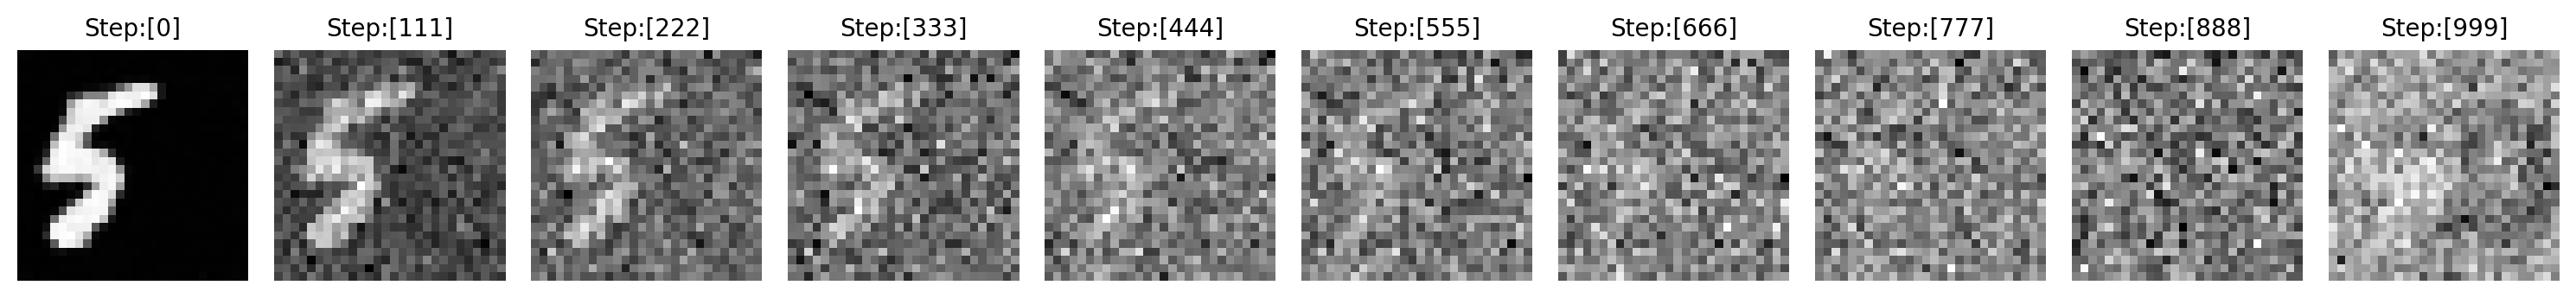

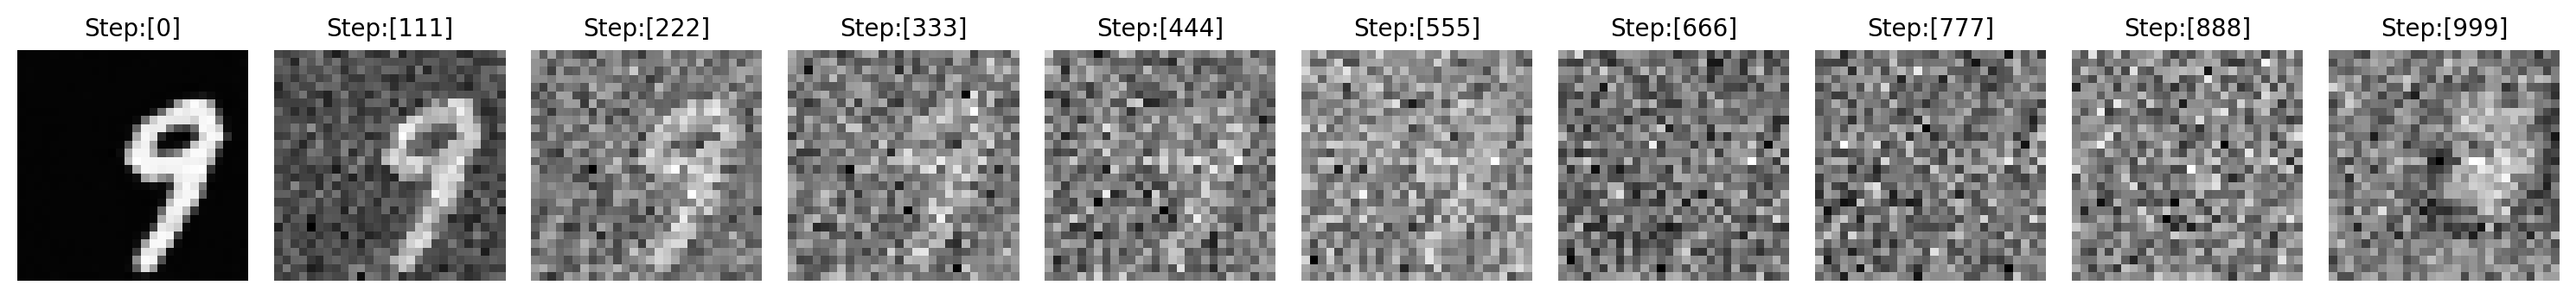

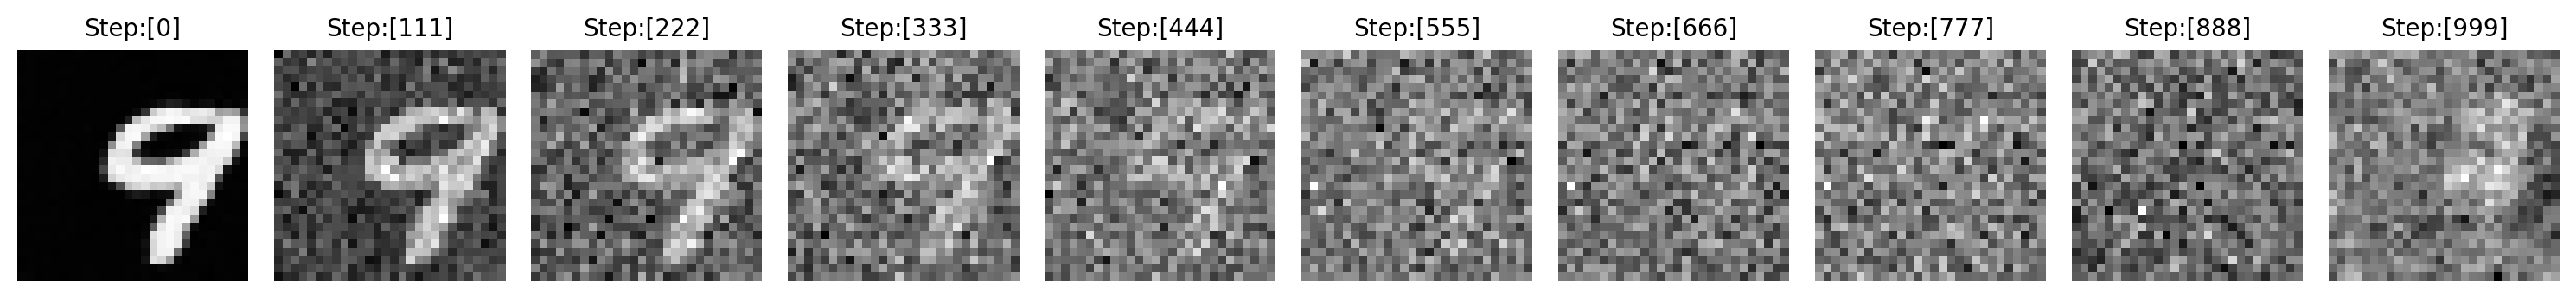

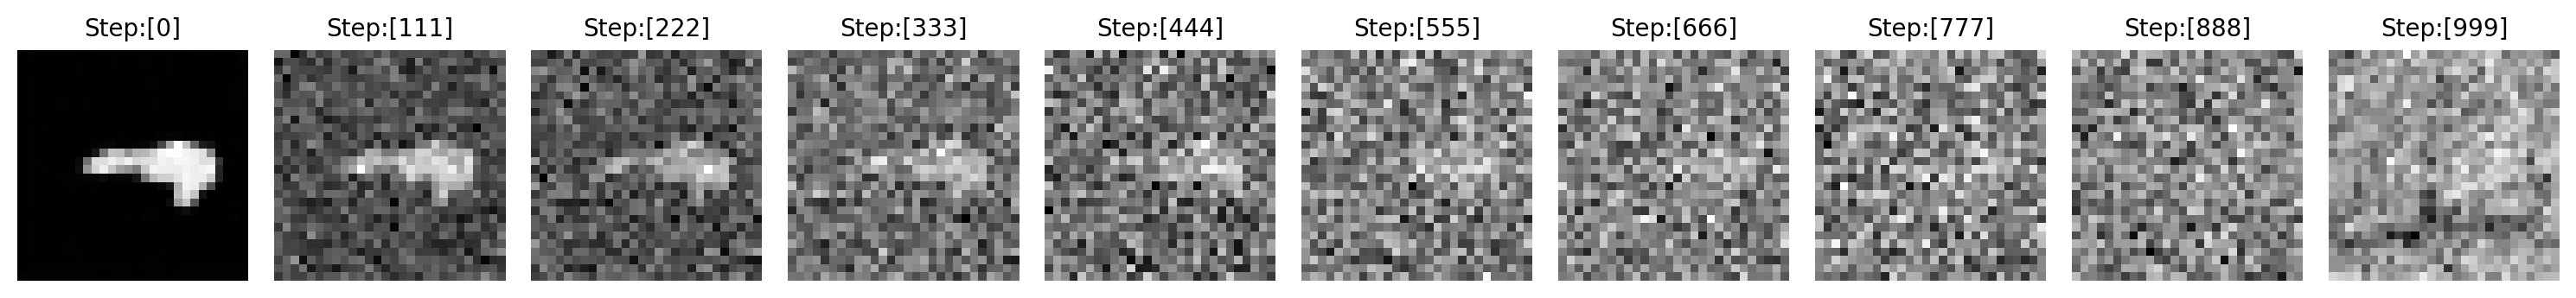

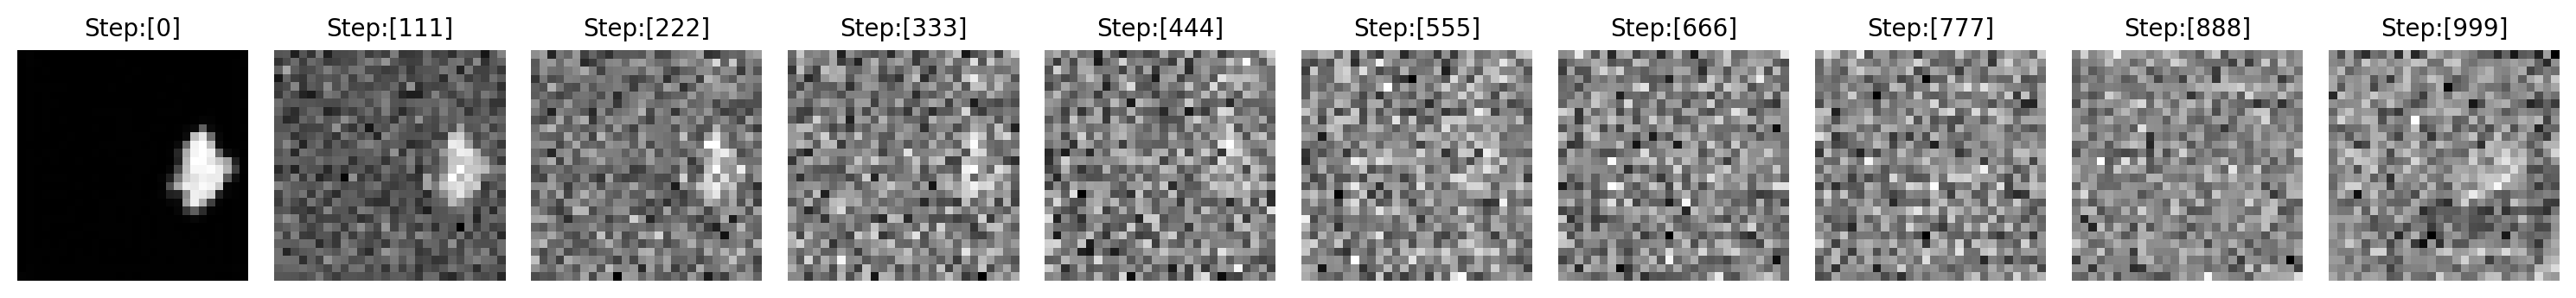

it:[   3000][30.0]% loss:[0.0731]
it:[   4000][40.0]% loss:[0.0674]


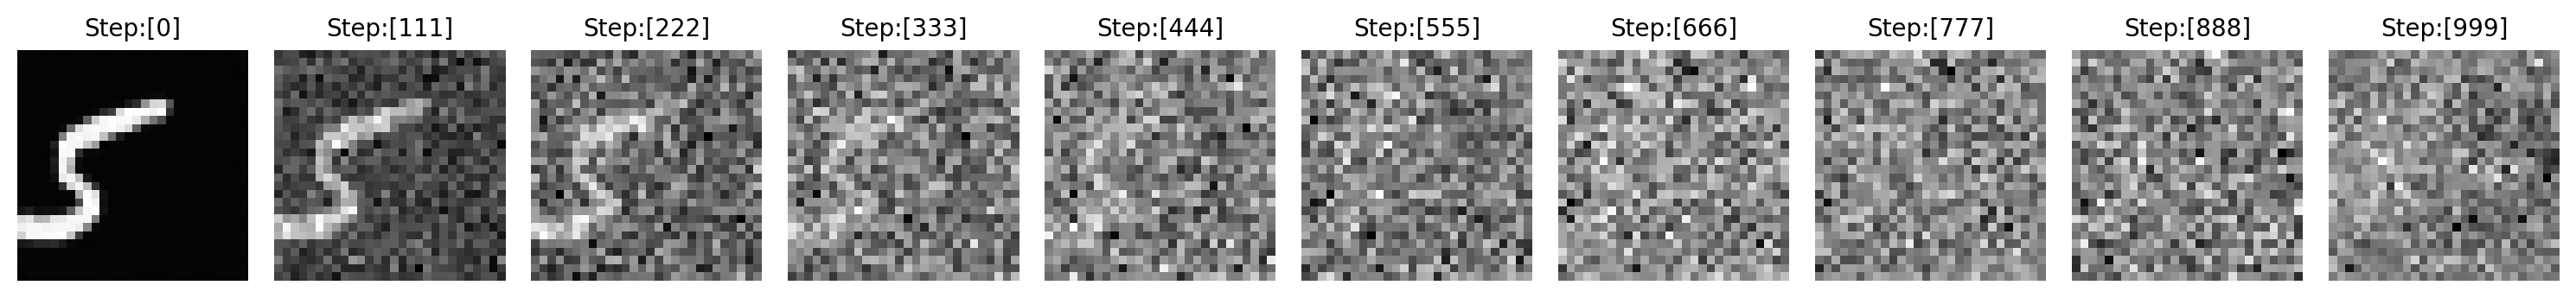

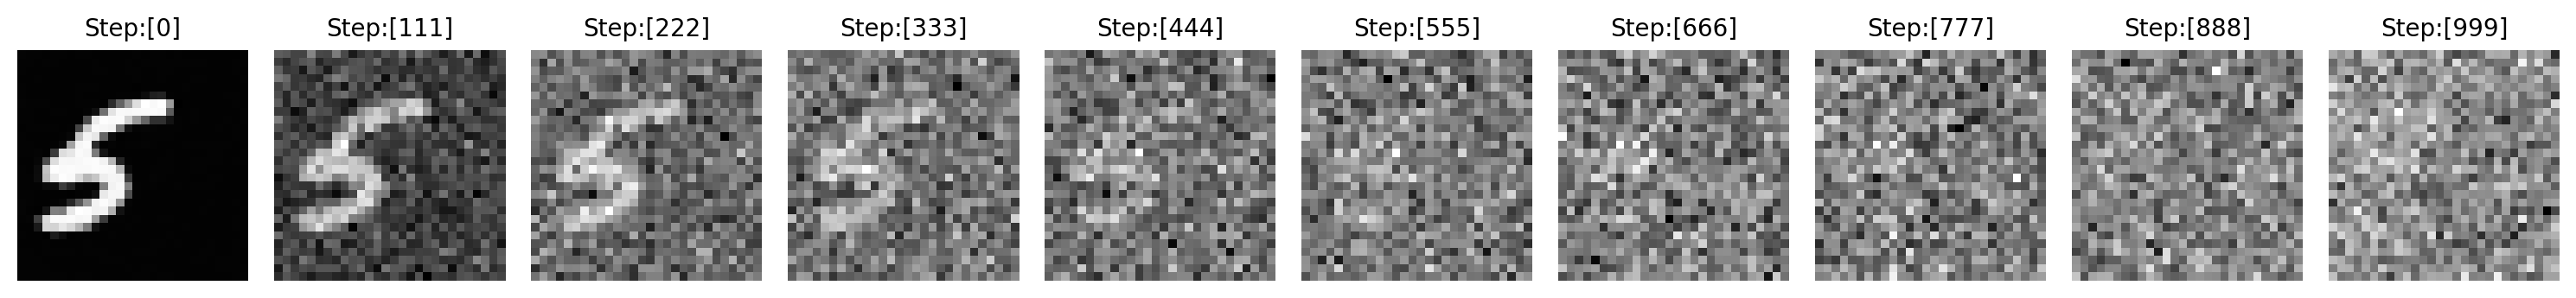

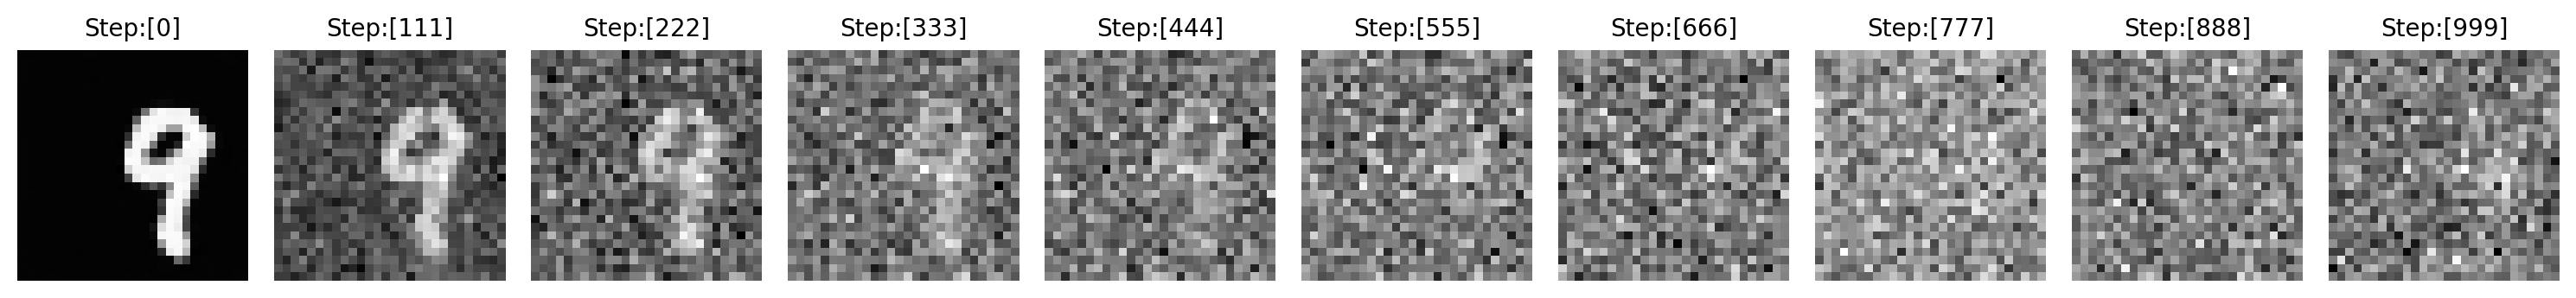

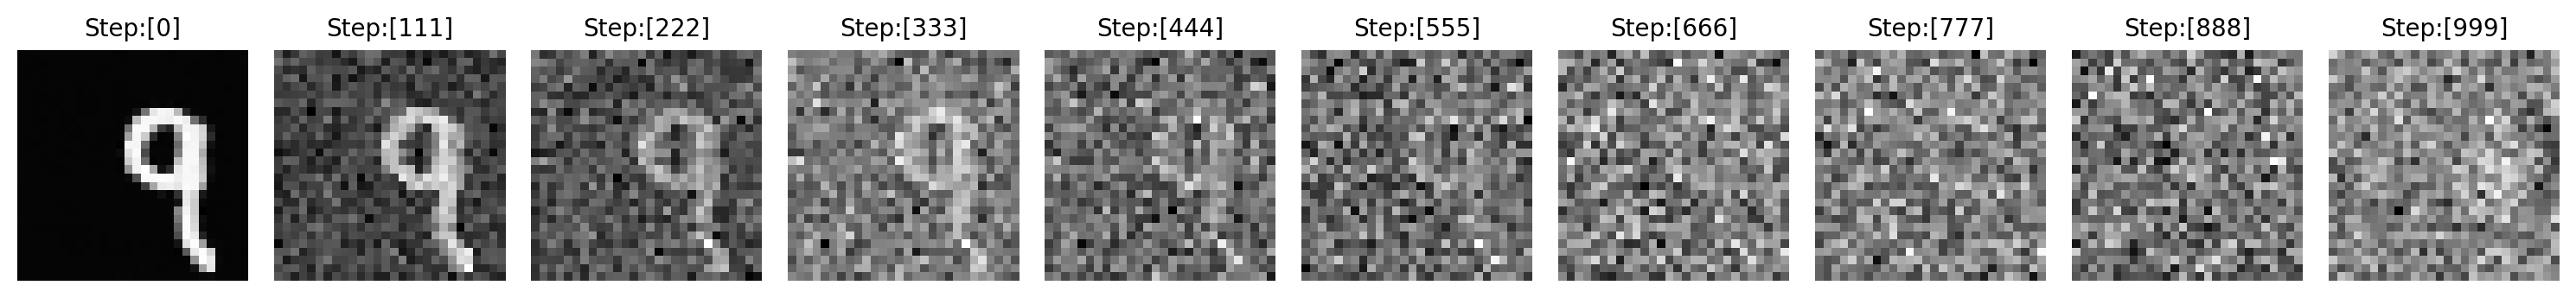

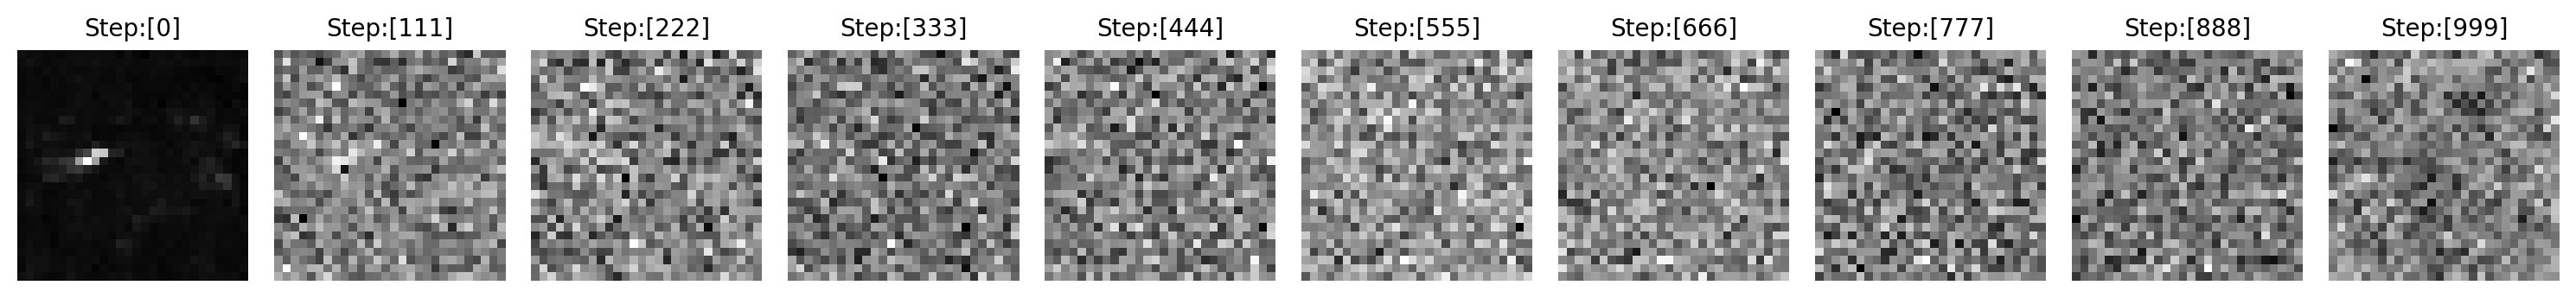

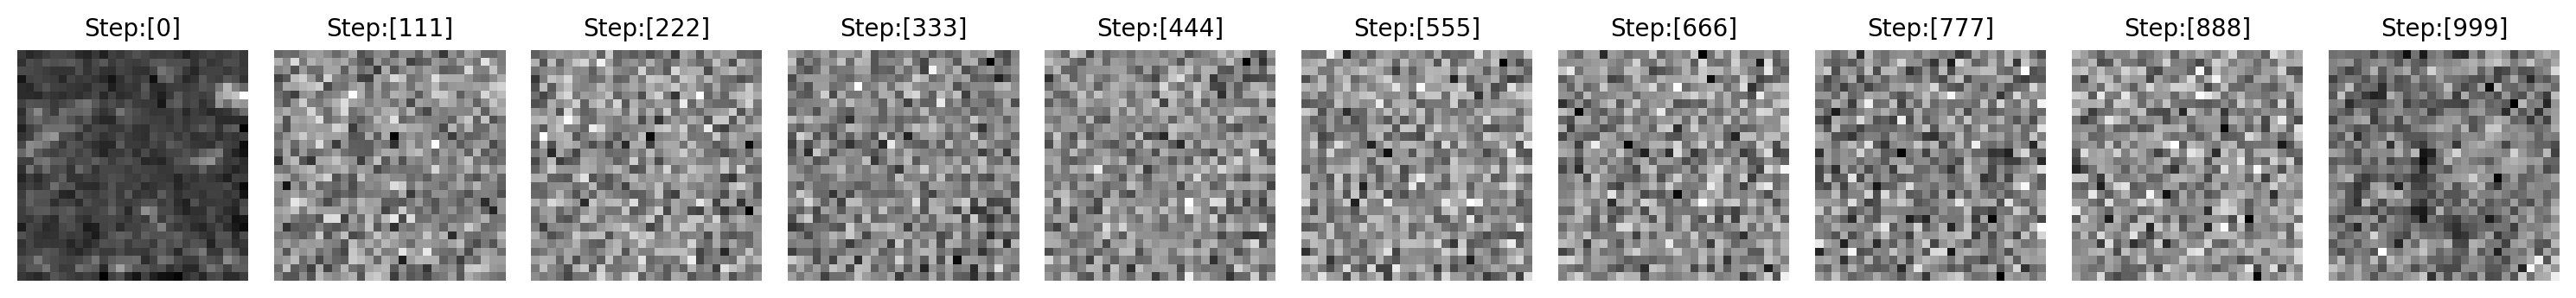

it:[   5000][50.0]% loss:[0.0831]
it:[   6000][60.0]% loss:[0.0802]


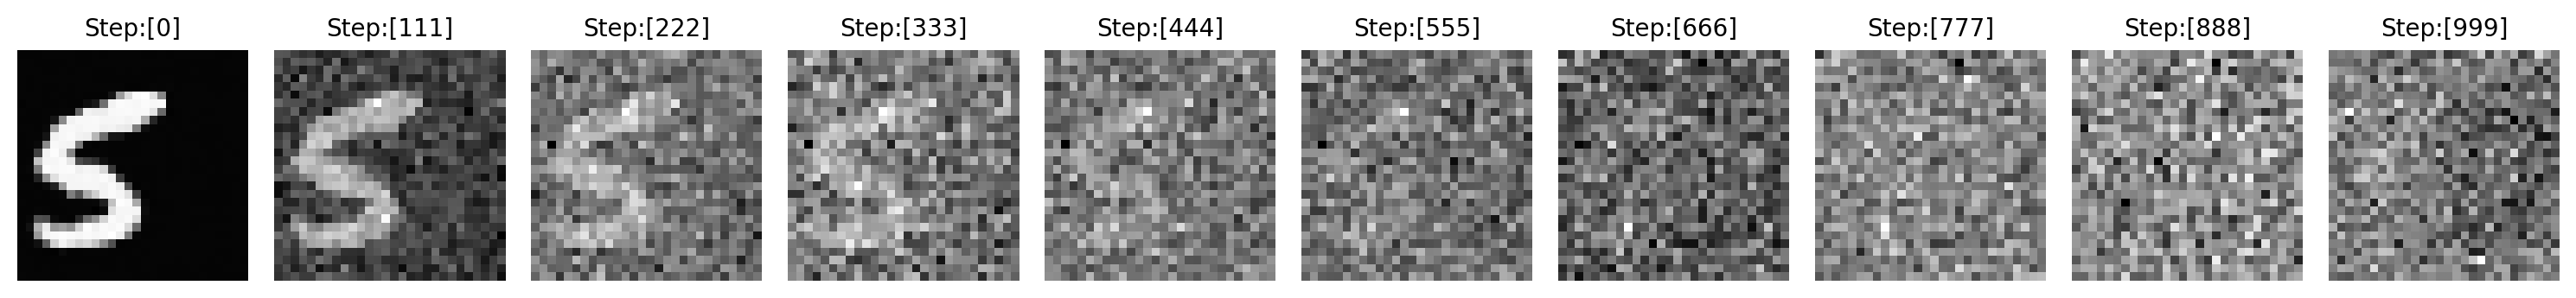

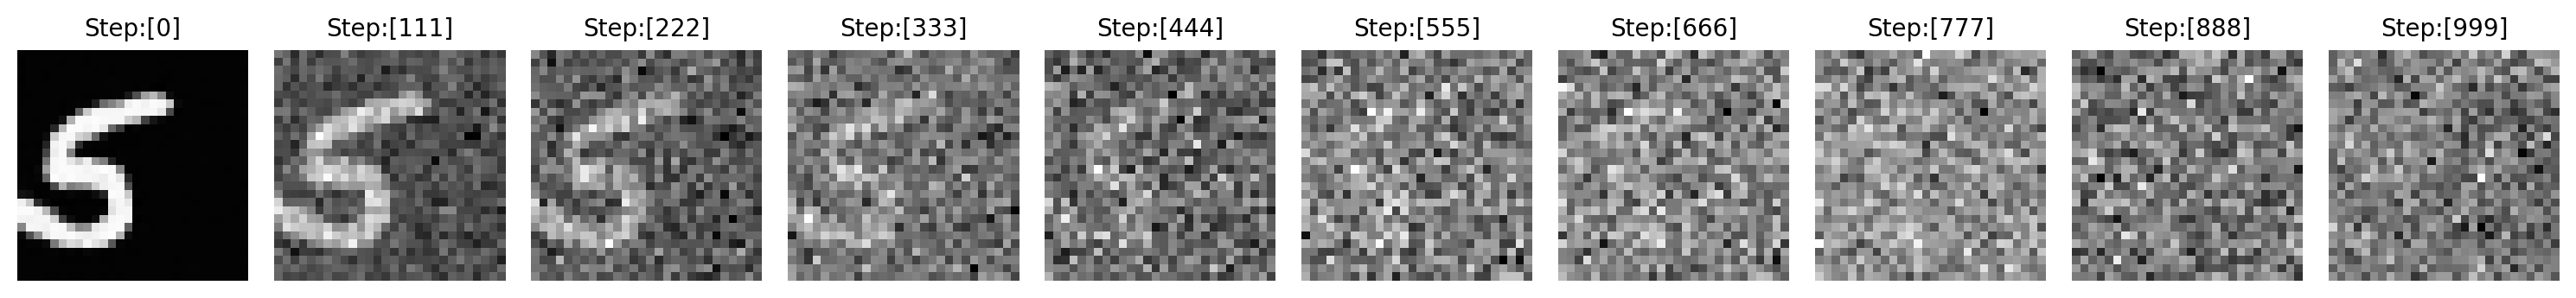

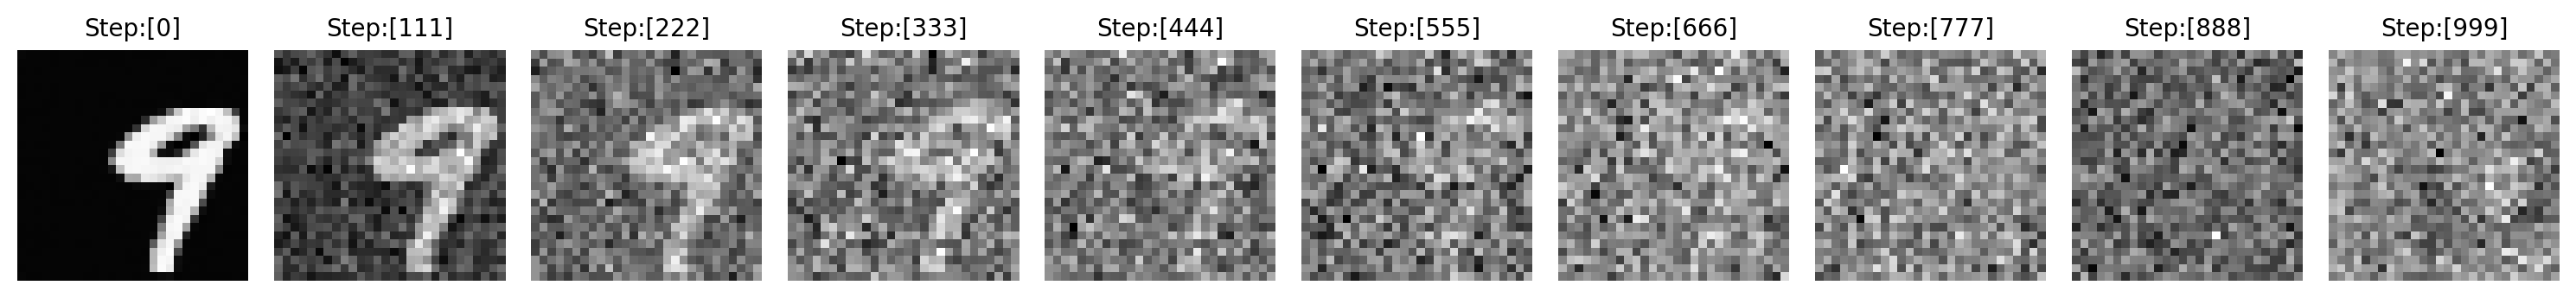

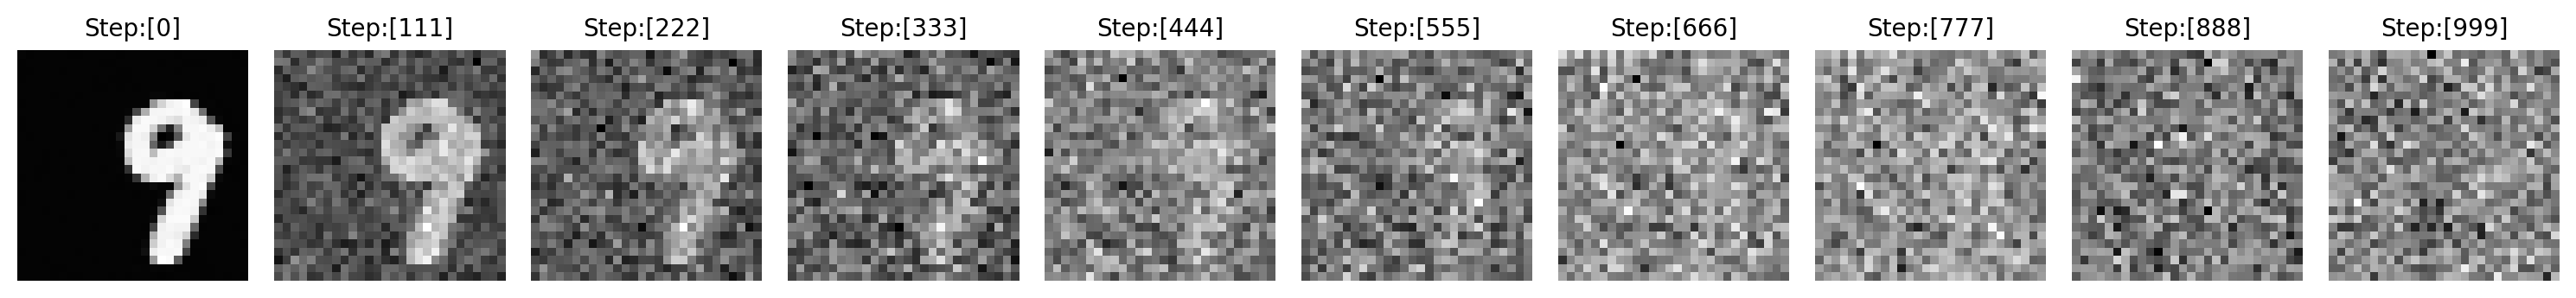

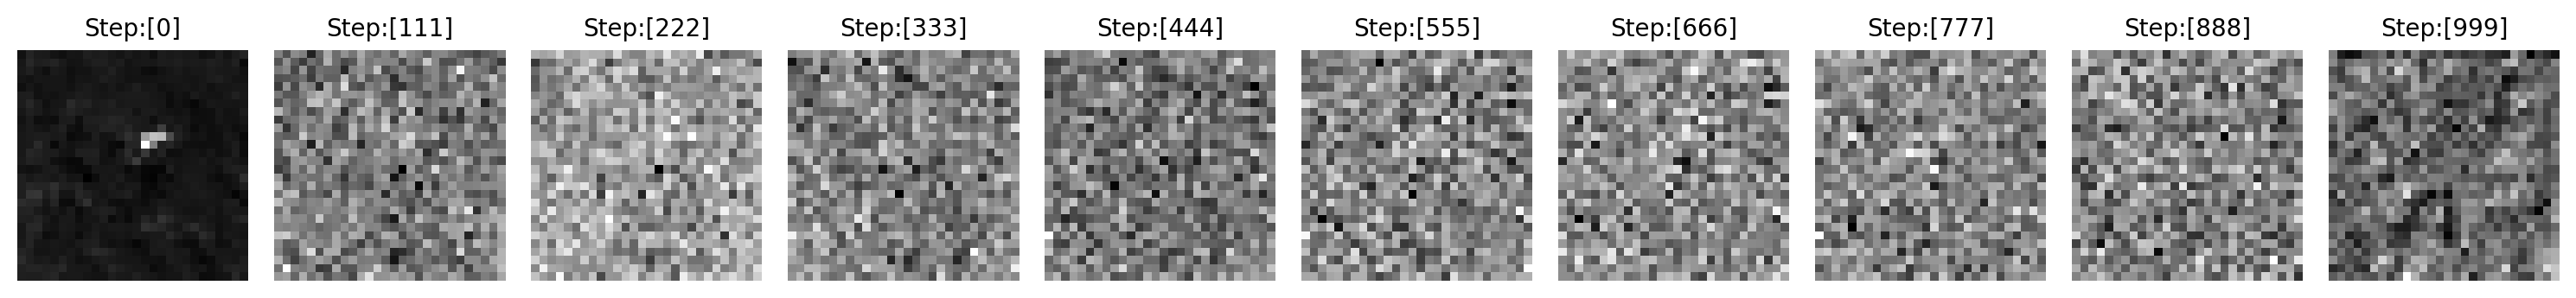

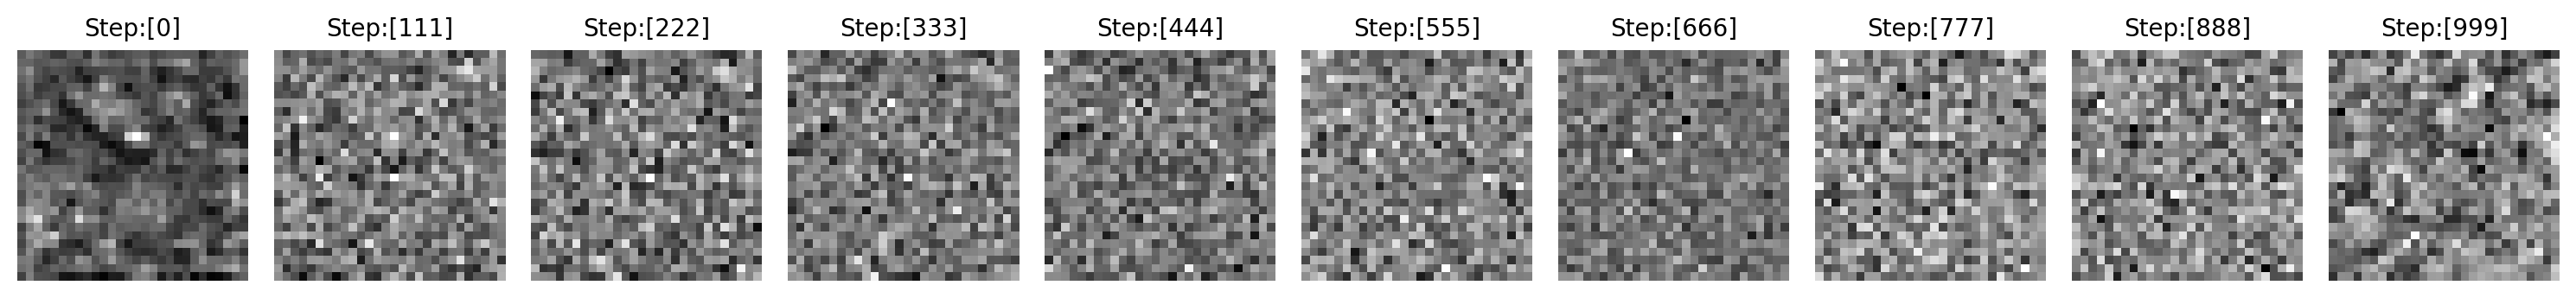

it:[   7000][70.0]% loss:[0.0673]
it:[   8000][80.0]% loss:[0.0796]


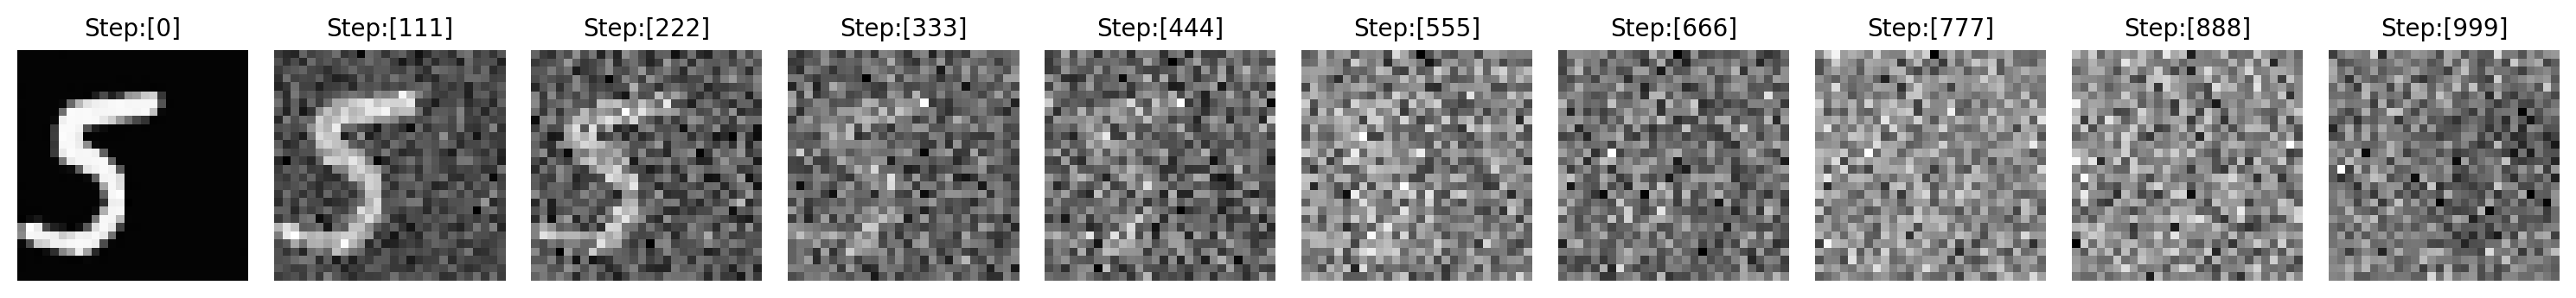

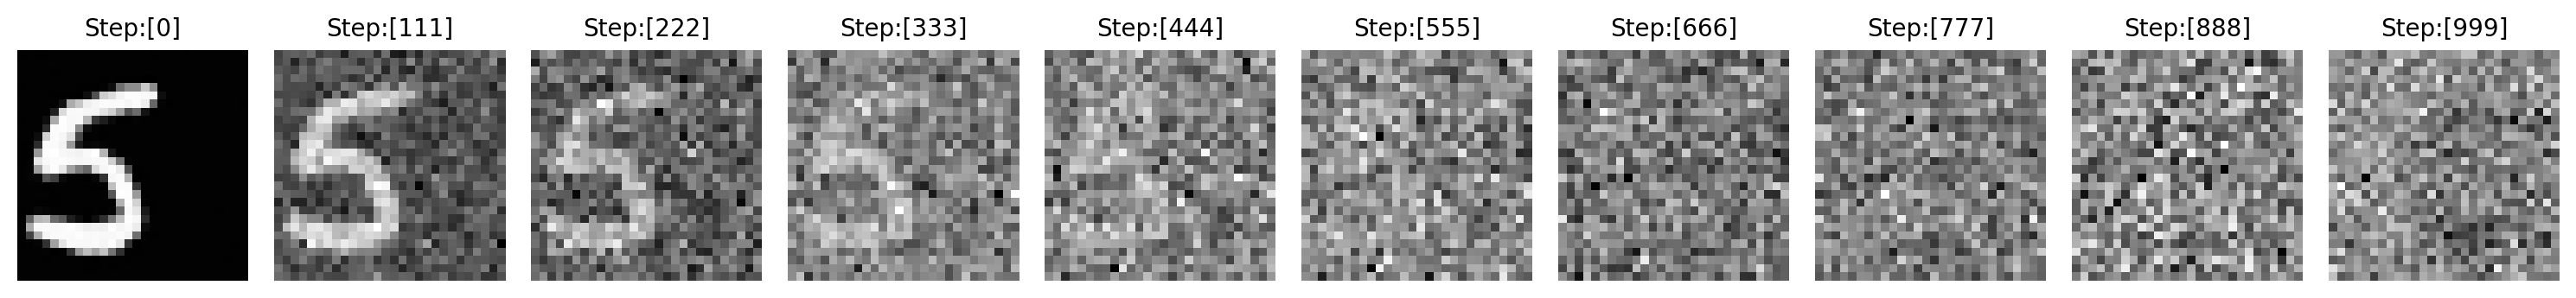

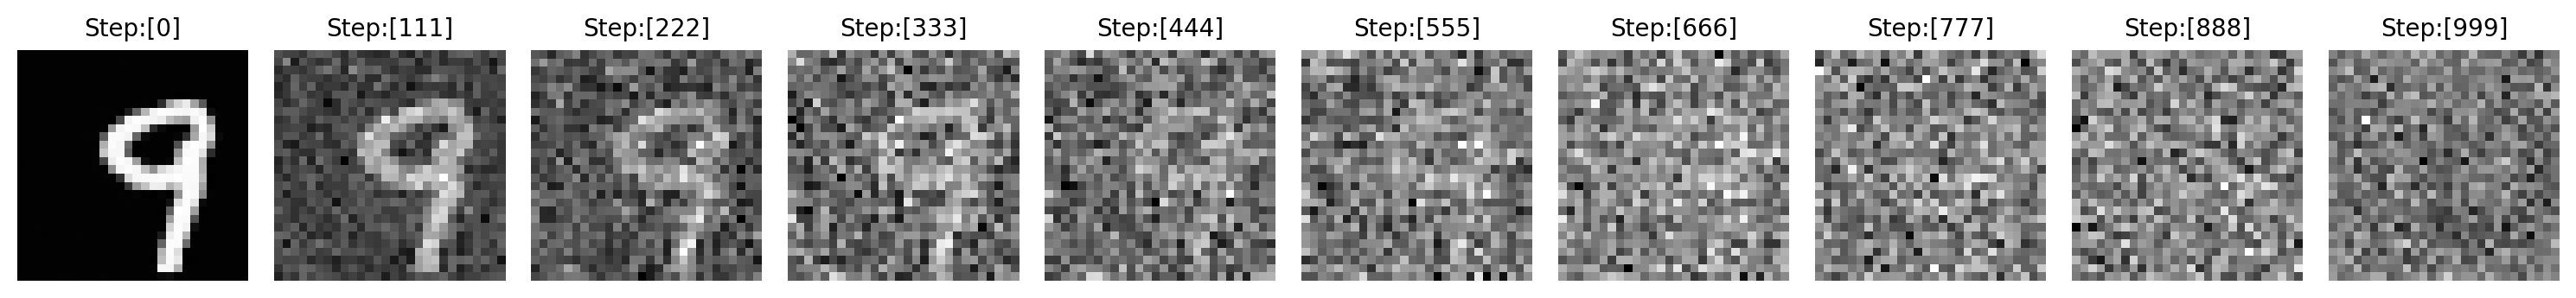

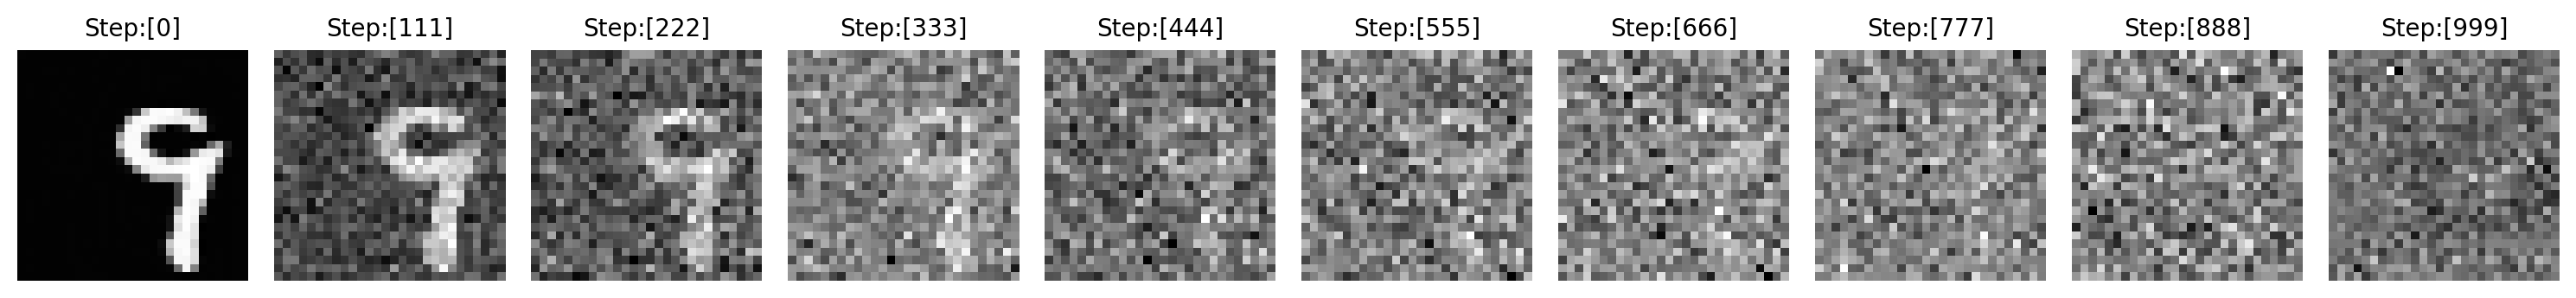

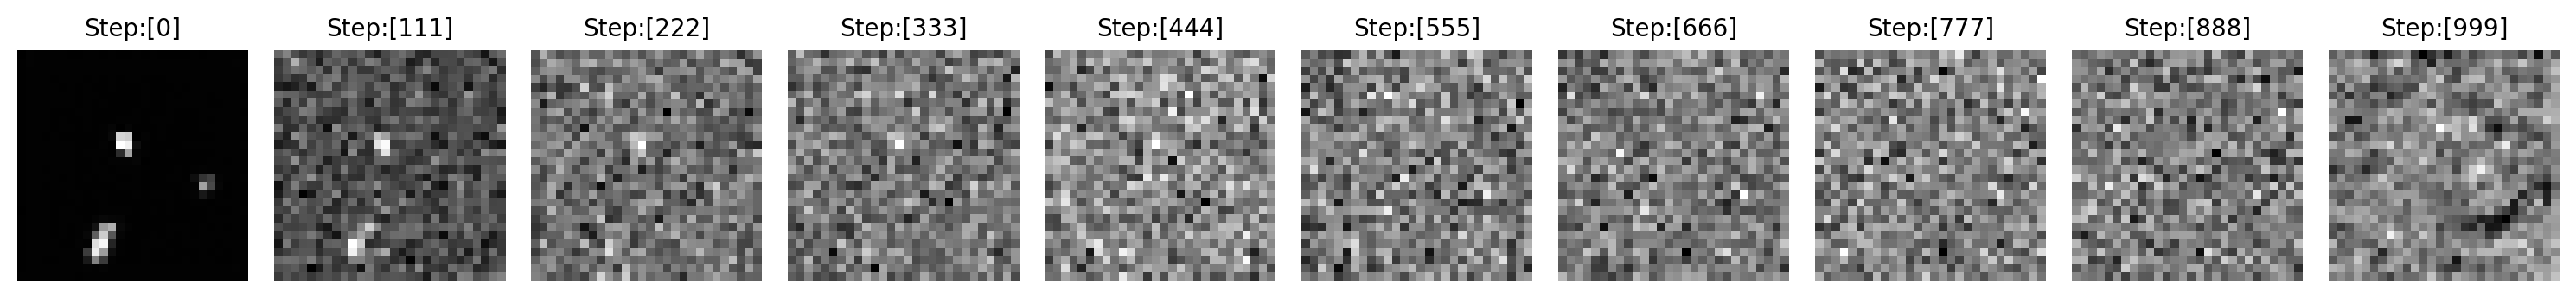

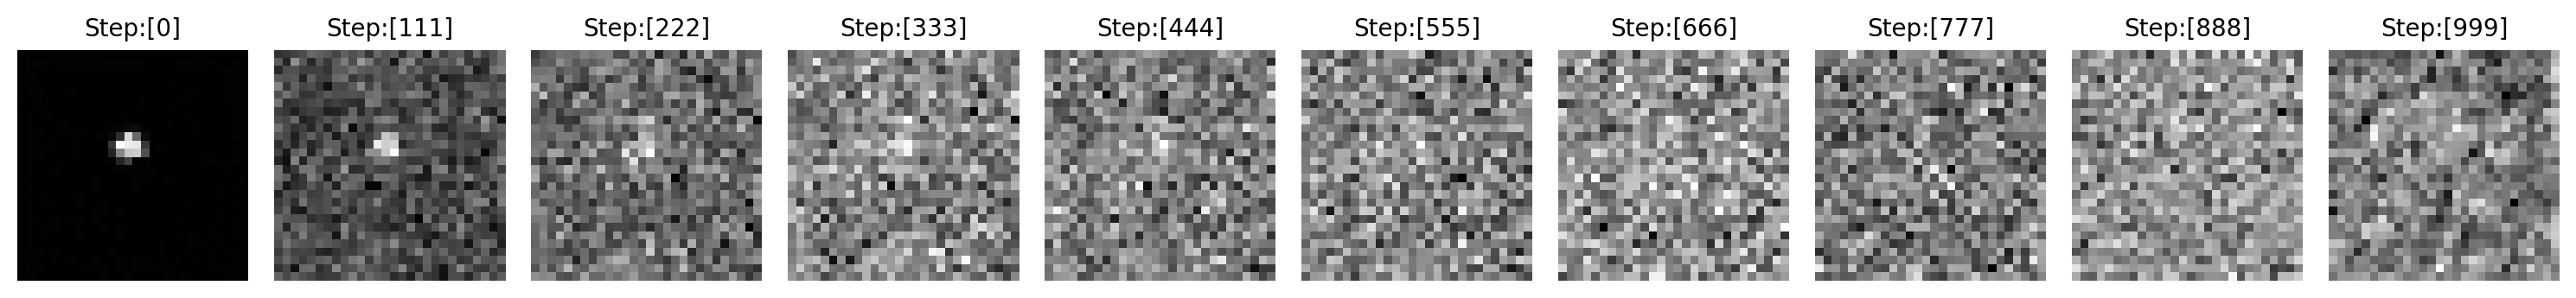

it:[   9000][90.0]% loss:[0.0827]
it:[   9999][100.0]% loss:[0.0713]


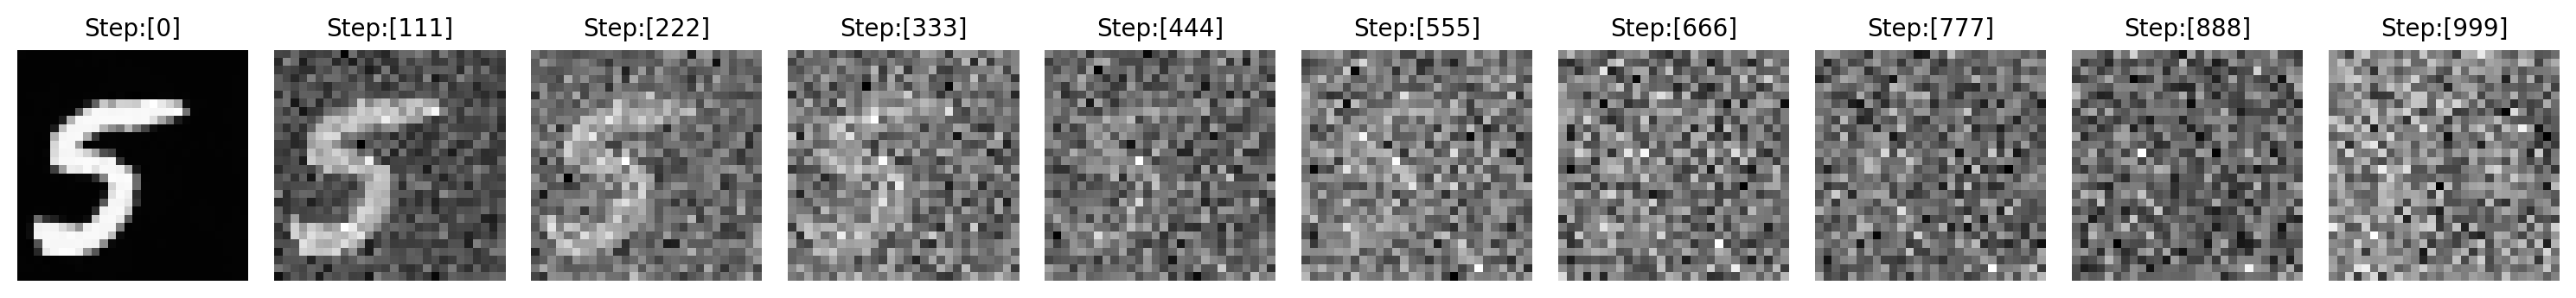

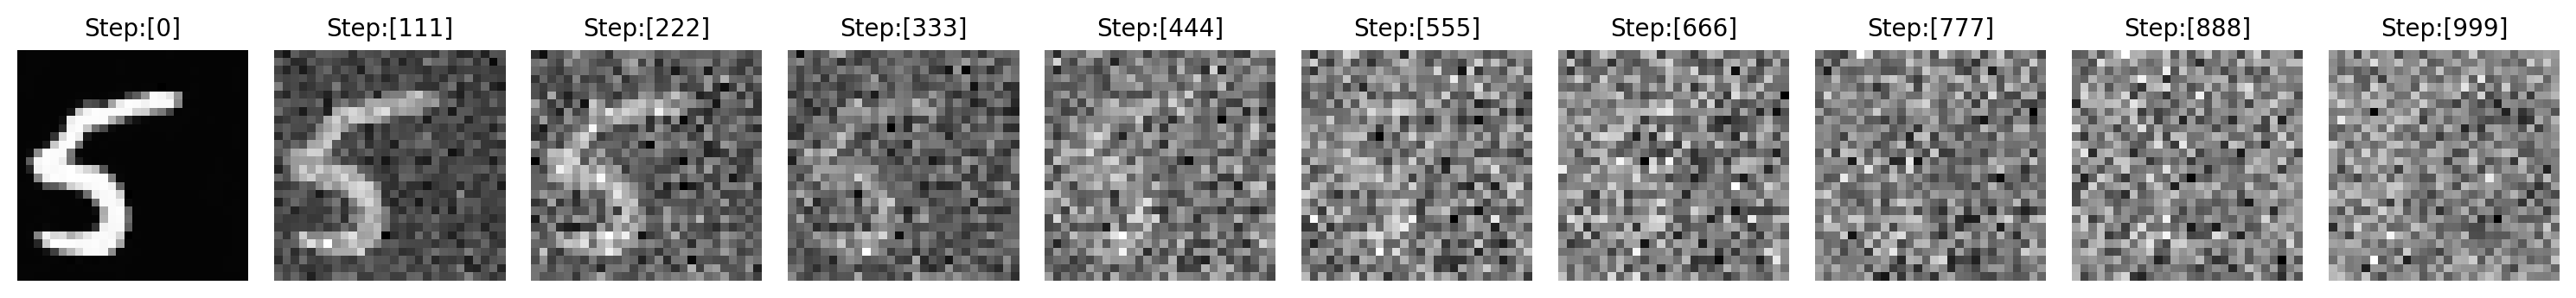

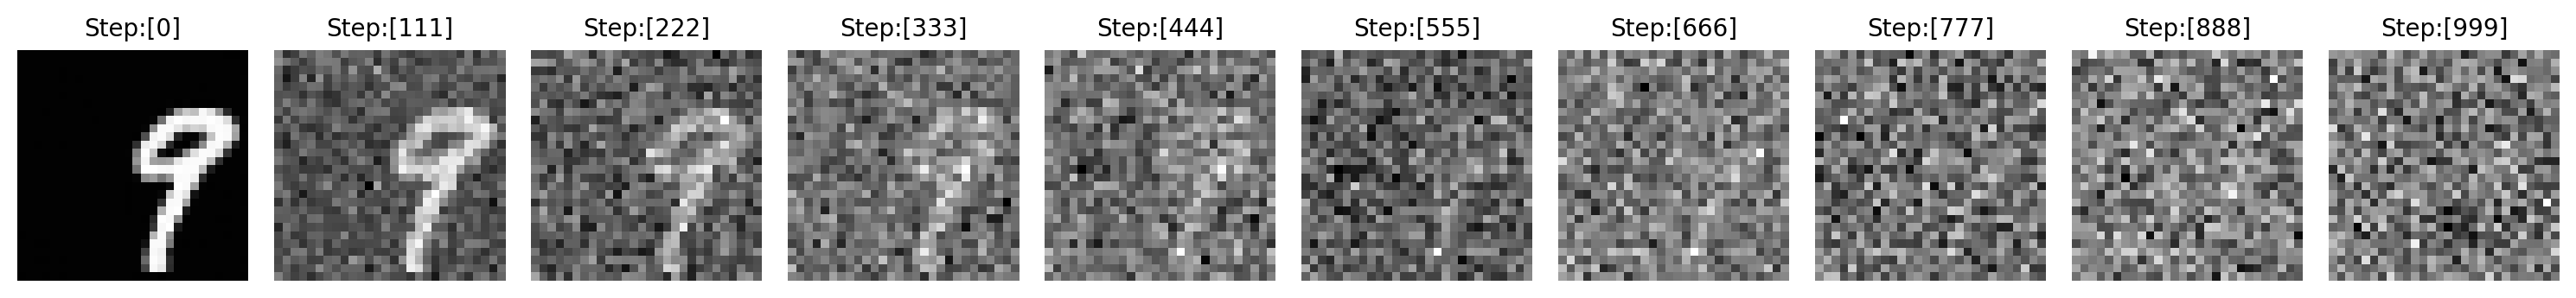

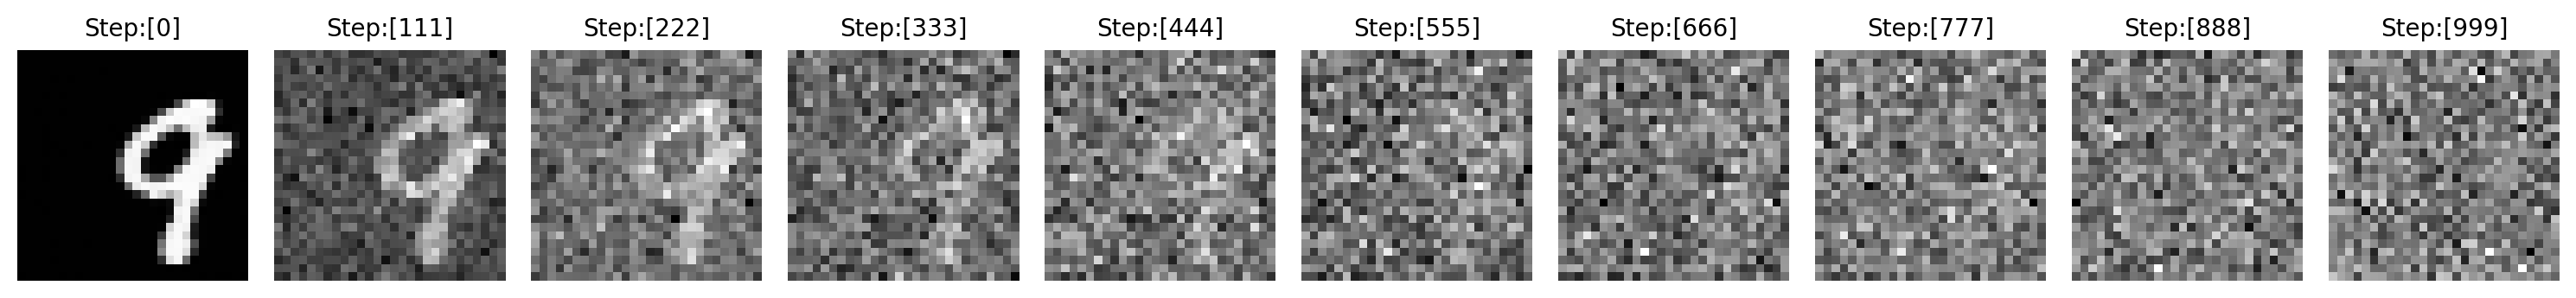

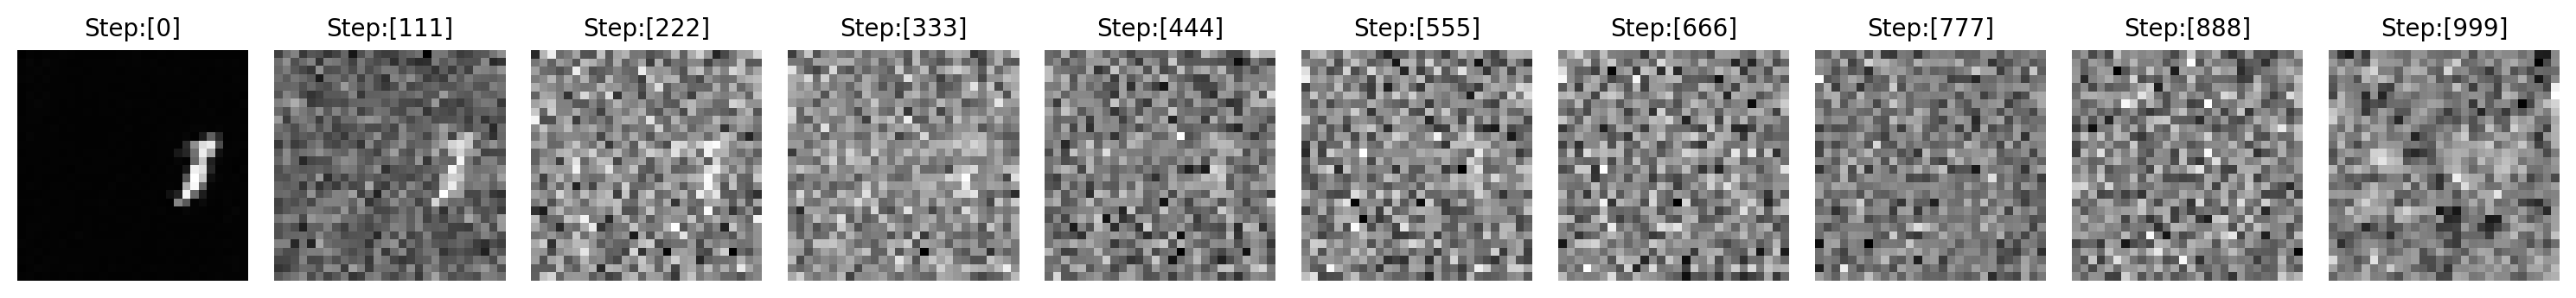

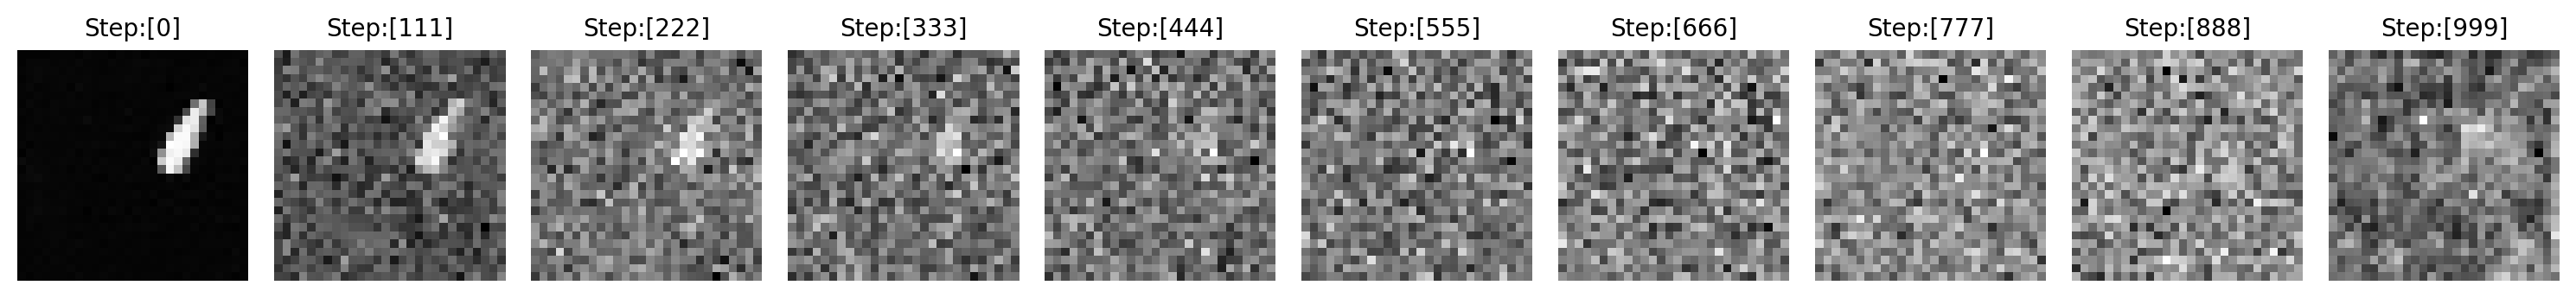

Done.


In [10]:
# Instantiate U-net
model = DiffusionUNetLegacy(
    name                 = 'unet',
    dims                 = 2,
    n_in_channels        = 1,
    n_base_channels      = 64,
    n_emb_dim            = 128,
    n_cond_dim           = 4,
    n_enc_blocks         = 4, # number of encoder blocks
    n_dec_blocks         = 4, # number of decoder blocks
    n_groups             = 16, # group norm paramter
    n_heads              = 4, # number of heads in QKV attention
    actv                 = nn.SiLU(),
    kernel_size          = 3, # kernel size (3)
    padding              = 1, # padding size (1)
    use_attention        = False, # no attention for images
    skip_connection      = True, # additional skip connection
    chnnel_multiples     = (1,2,4,8),
    updown_rates         = (1,2,1,2),
    use_scale_shift_norm = True,
    device               = device,
) # input:[B x C x W x H] => output:[B x C x W x H]

# Configuration
max_iter    = int(1e4)
batch_size  = 128
print_every = 1e3
eval_every  = 2e3

# Loop
model.train()
optm = th.optim.AdamW(params=model.parameters(),lr=1e-4,weight_decay=0.0)
schd = th.optim.lr_scheduler.ExponentialLR(optimizer=optm,gamma=0.99998)
for it in range(max_iter):
    # Zero gradient
    optm.zero_grad()
    # Get batch
    idx = np.random.choice(x_0.shape[0],batch_size)
    x_0_batch = x_0[idx,:,:,:] # [B x C x W x H]
    # Sample time steps
    step_batch = th.randint(0, dc['T'],(batch_size,),device=device).to(th.int64) # [B]
    # Forward diffusion sampling
    x_t_batch,noise = forward_sample(x_0_batch,step_batch,dc) # [B x C x W x H]
    # Noise prediction
    paritial_embeddings = torch.index_select(embedding_vectors_tensor, dim=0, index=torch.tensor(idx, device=device))
    noise_pred,_ = model(x_t_batch,step_batch,paritial_embeddings) # [B x C x W x H]
    # Compute error
    loss = F.mse_loss(noise,noise_pred)+F.smooth_l1_loss(noise,noise_pred,beta=0.1)
    # Update
    loss.backward(retain_graph=True)
    optm.step()
    schd.step()
    # Print
    if (it%print_every) == 0 or it == (max_iter-1):
        print ("it:[%7d][%.1f]%% loss:[%.4f]"%(it,100*it/max_iter,loss.item()))
    # Evaluate
    if (it%eval_every) == 0 or it == (max_iter-1):
        n_sample = 20
        step_list_to_append = np.linspace(0,999,10).astype(np.int64) # save 10 x_ts
        x_t_list = eval_ddpm_2d(model,dc,n_sample,x_0,step_list_to_append,device,test_embedding_vector_5_L)
        plot_ddpm_2d_result(x_0,step_list_to_append,x_t_list,n_plot=2)
        
        x_t_list = eval_ddpm_2d(model,dc,n_sample,x_0,step_list_to_append,device,test_embedding_vector_9_R)
        plot_ddpm_2d_result(x_0,step_list_to_append,x_t_list,n_plot=2)
        
        x_t_list = eval_ddpm_2d(model,dc,n_sample,x_0,step_list_to_append,device,test_embedding_vector_5_L_9_R)
        plot_ddpm_2d_result(x_0,step_list_to_append,x_t_list,n_plot=2)

print ("Done.")

In [11]:
import torch
from datetime import datetime

# 현재 날짜와 시간 가져오기
now = datetime.now()

# "YYYYMMDD_HHMMSS" 형식으로 포맷팅
formatted_now = now.strftime("%Y%m%d_%H%M%S")

# 모델과 옵티마이저 상태를 저장할 경로
save_path = f'result/MNIST_conditioning_position_number_simple_{formatted_now}.pth'

# 모델 및 옵티마이저 상태를 딕셔너리로 저장
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optm.state_dict(),
    'scheduler_state_dict': schd.state_dict(),
    'epoch': it,
    'loss': loss.item()
}, save_path)

print(f'Model saved to {save_path}')

Model saved to result/MNIST_conditioning_position_number_simple_20240617_230220.pth


random_int :  2   2
print right


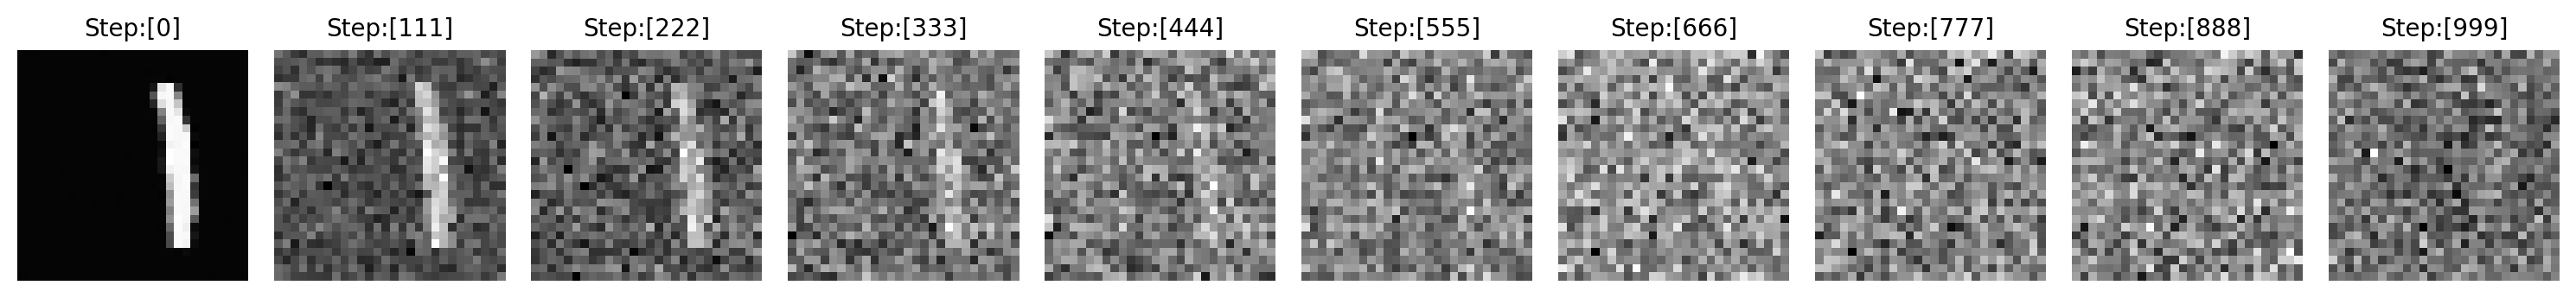

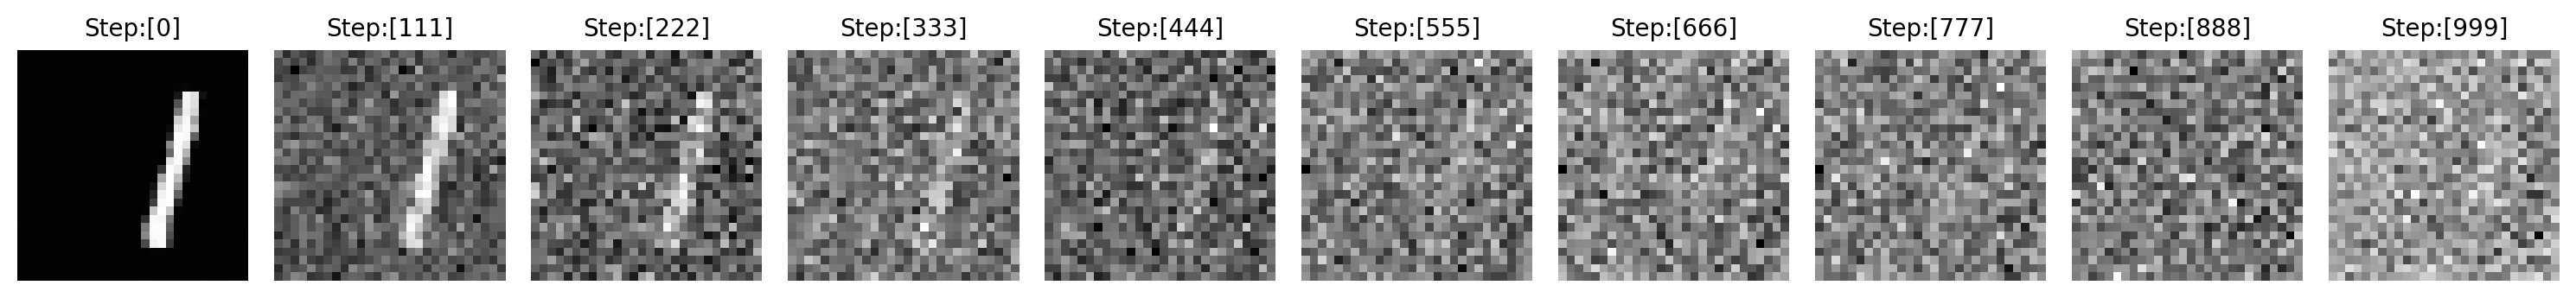

print left


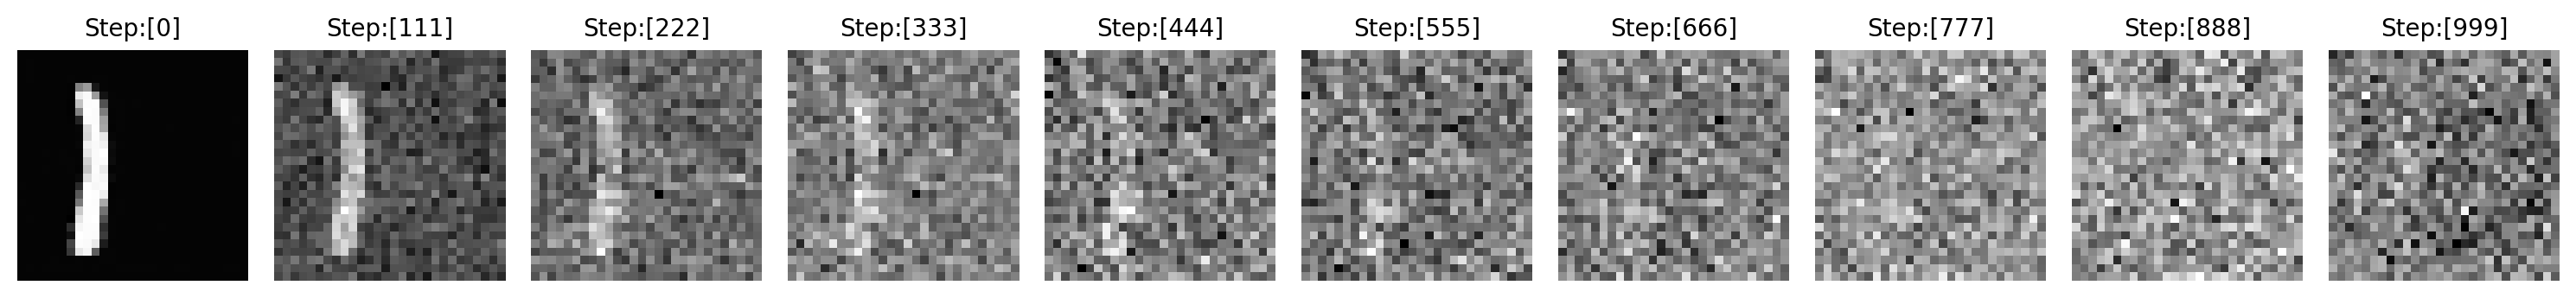

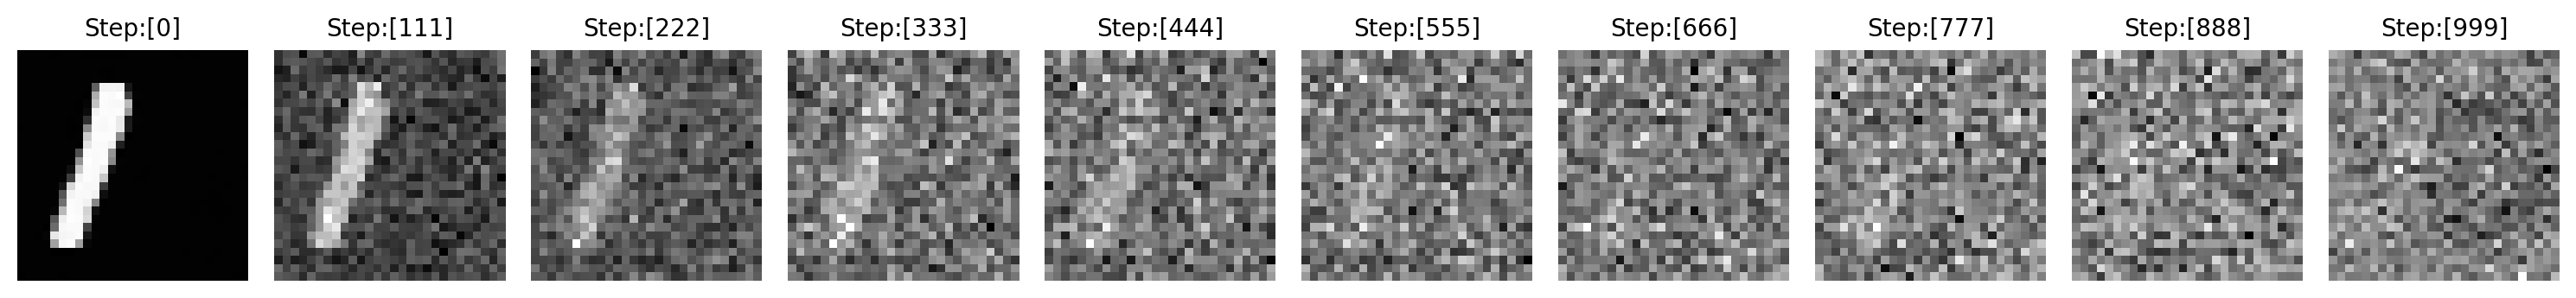

print both


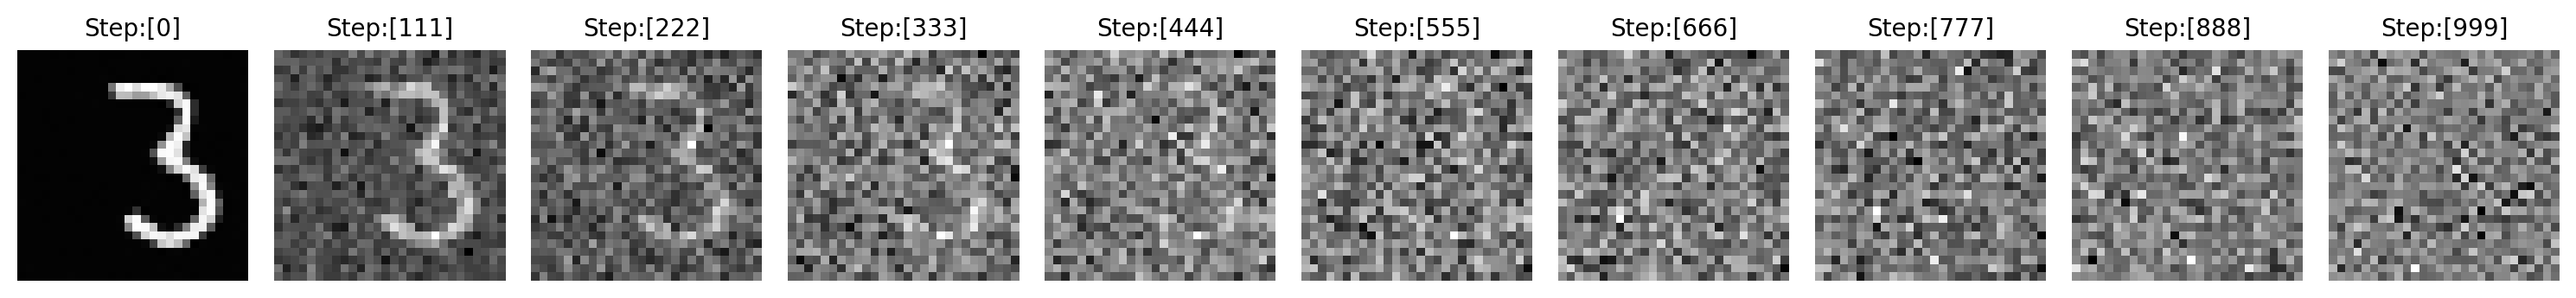

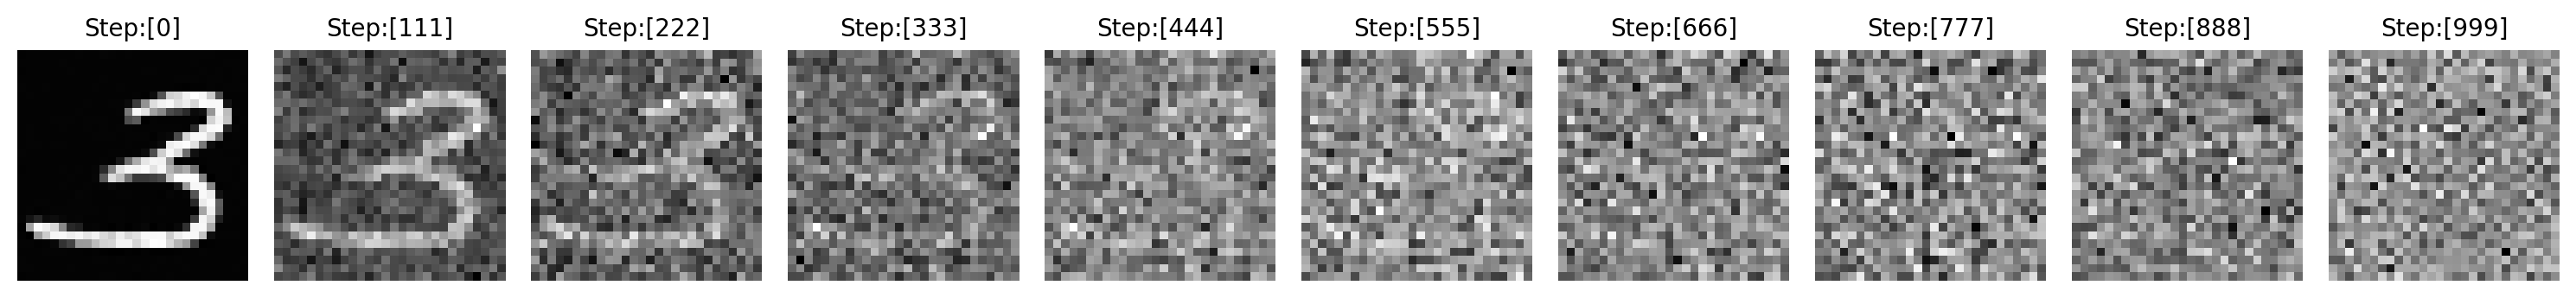

random_int :  6   7
print right


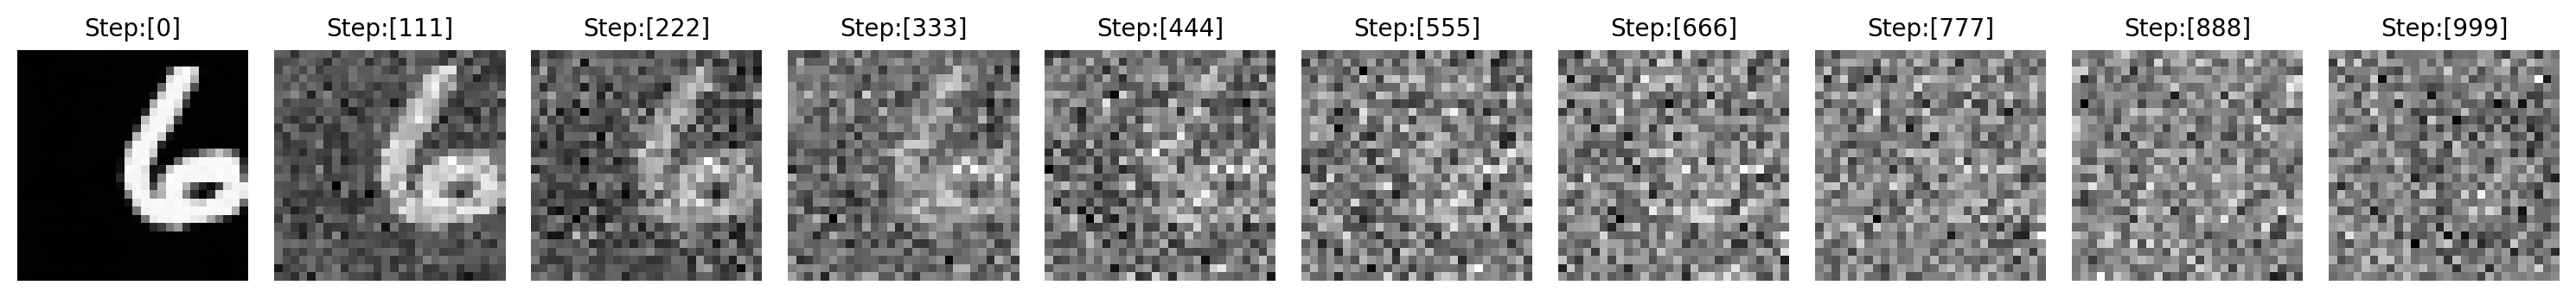

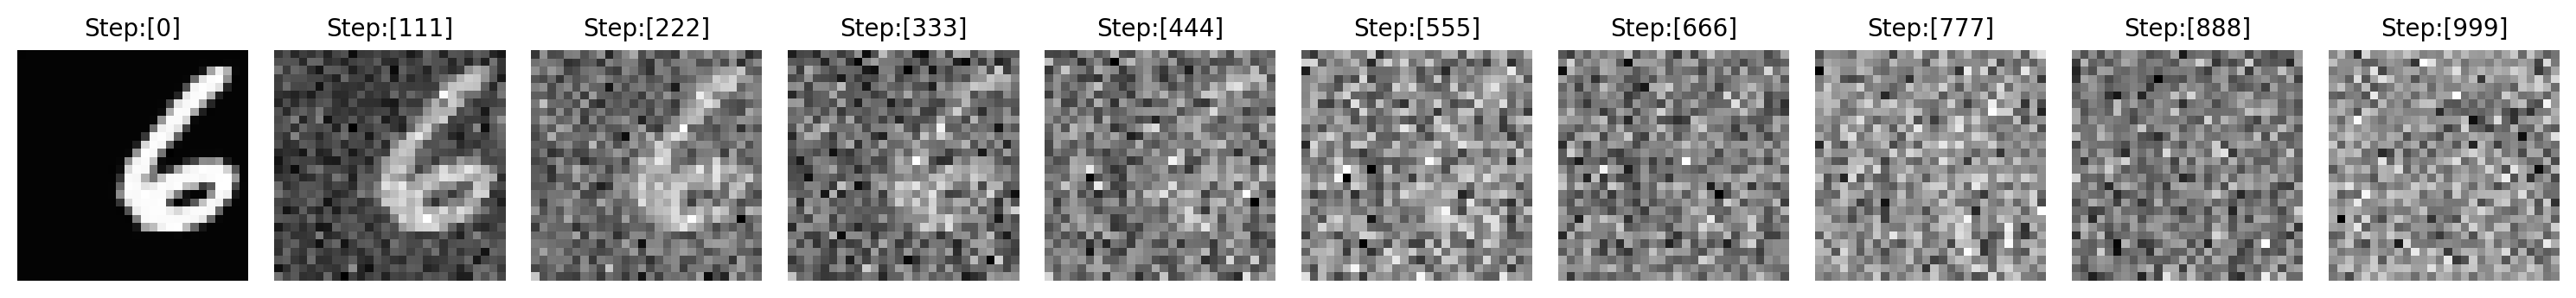

print left


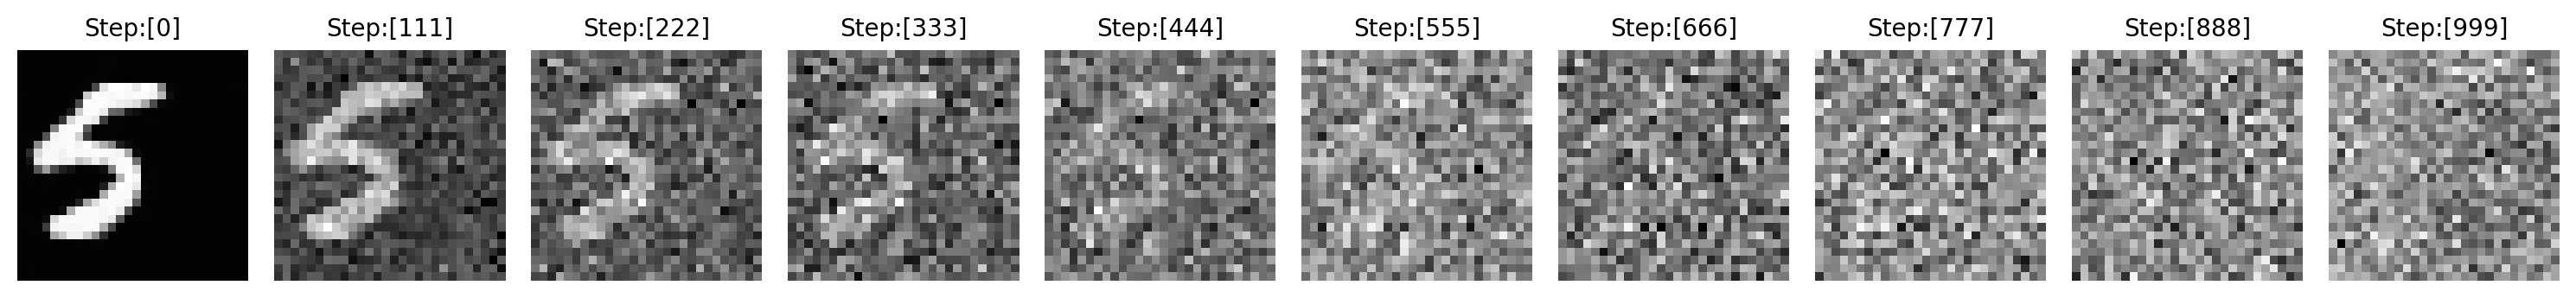

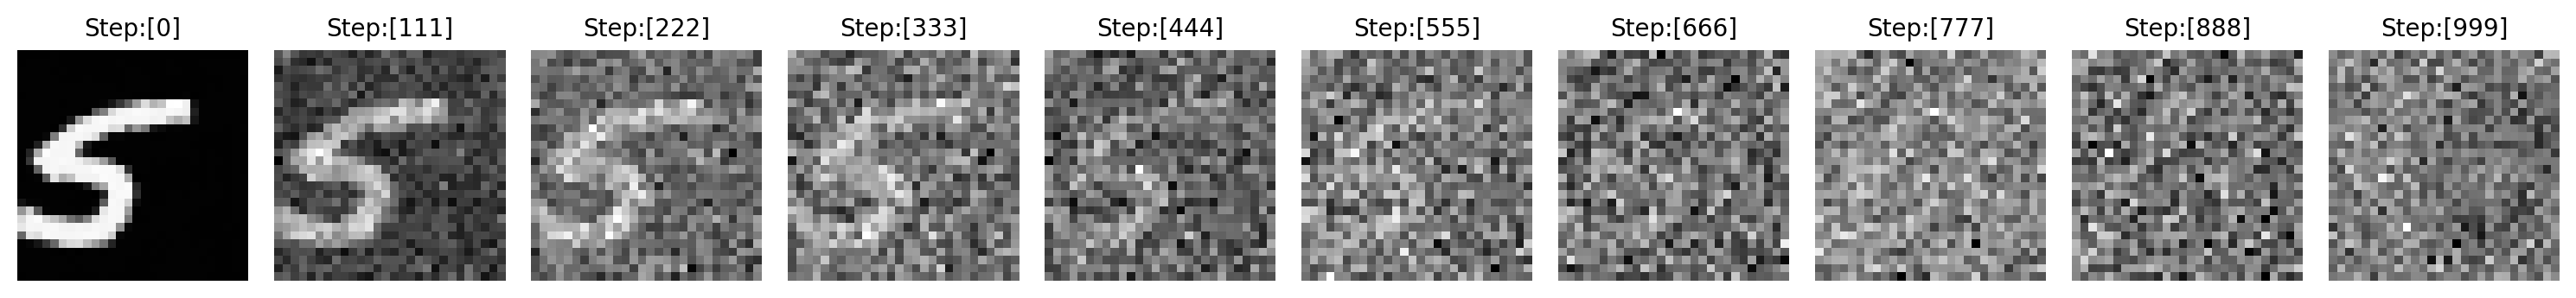

print both


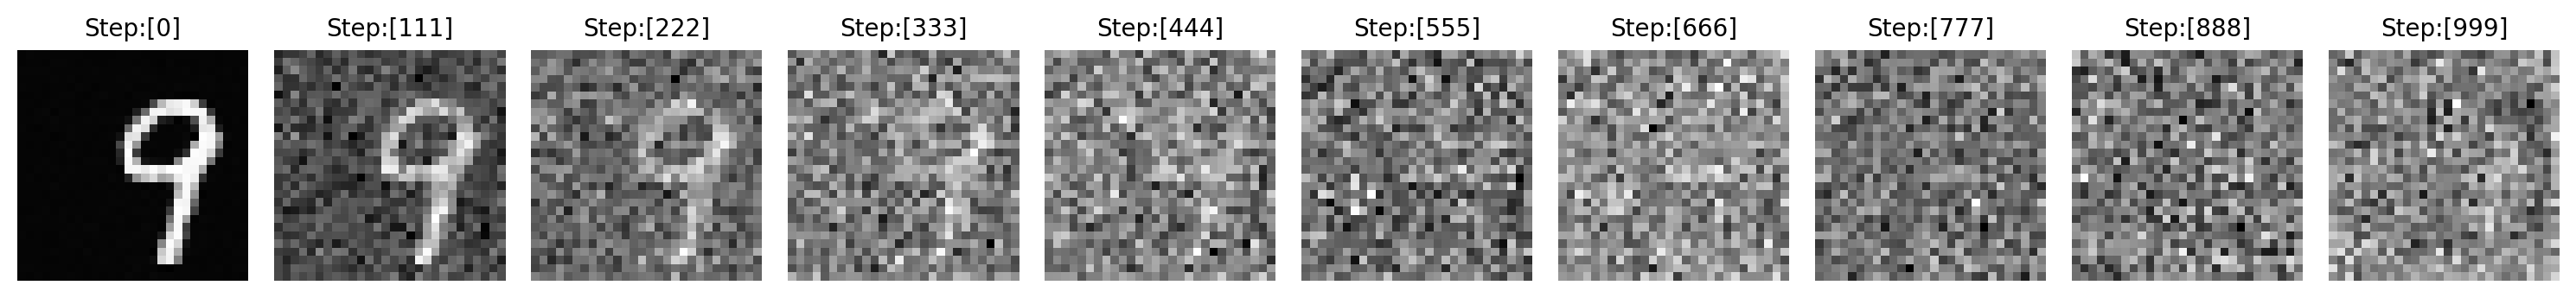

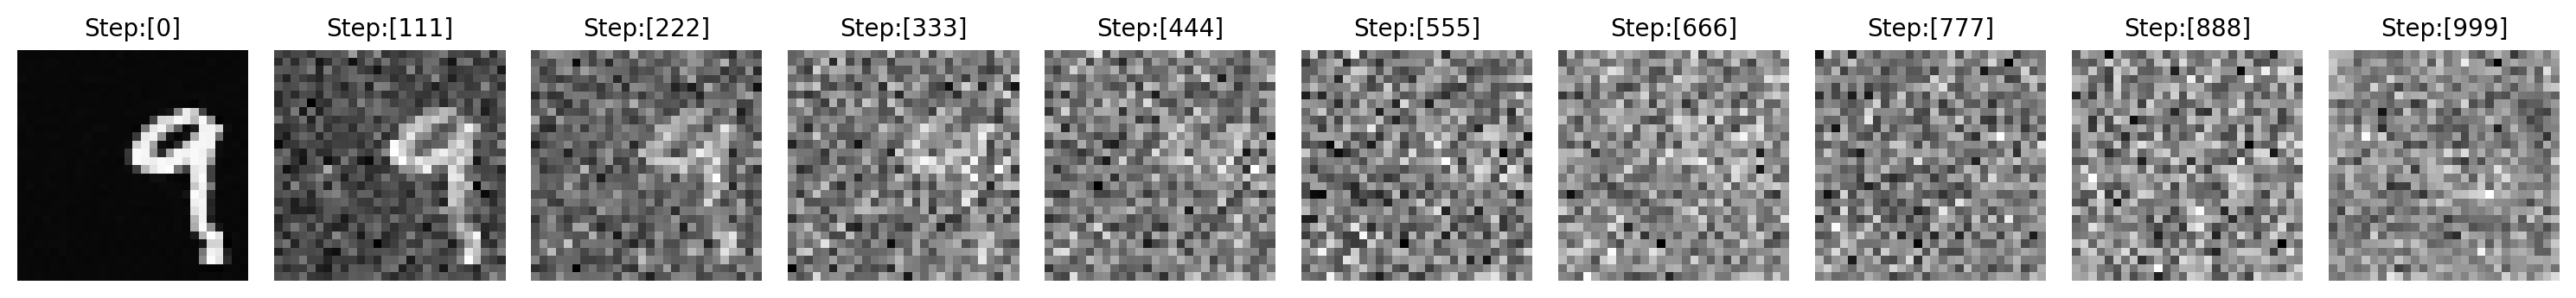

random_int :  7   10
print right


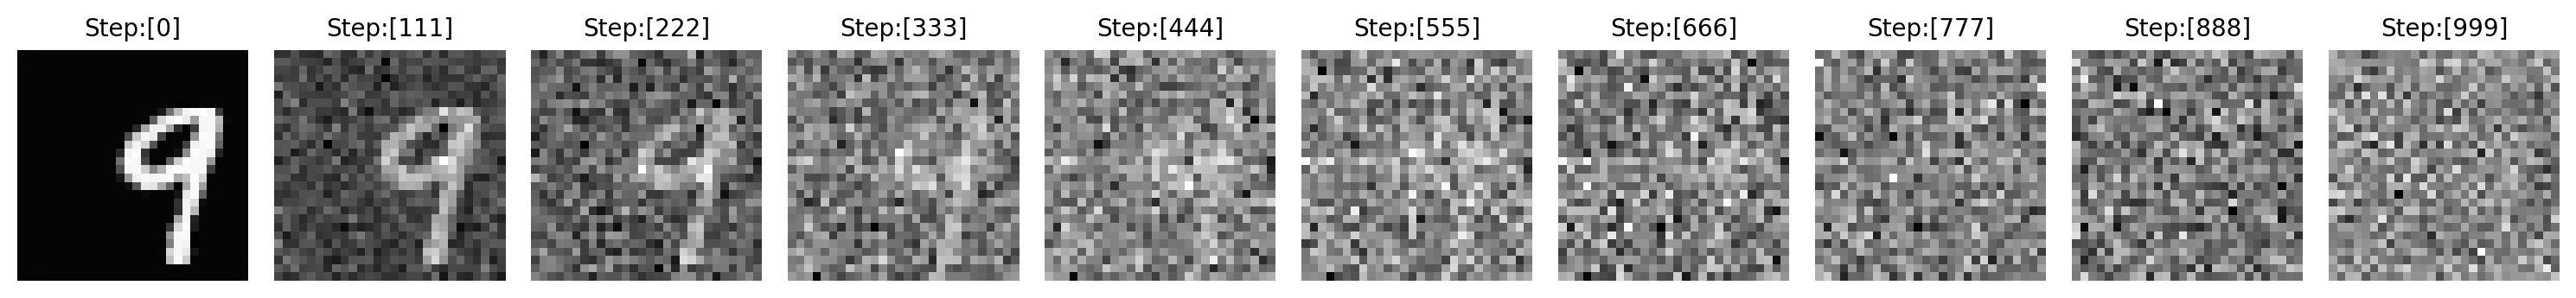

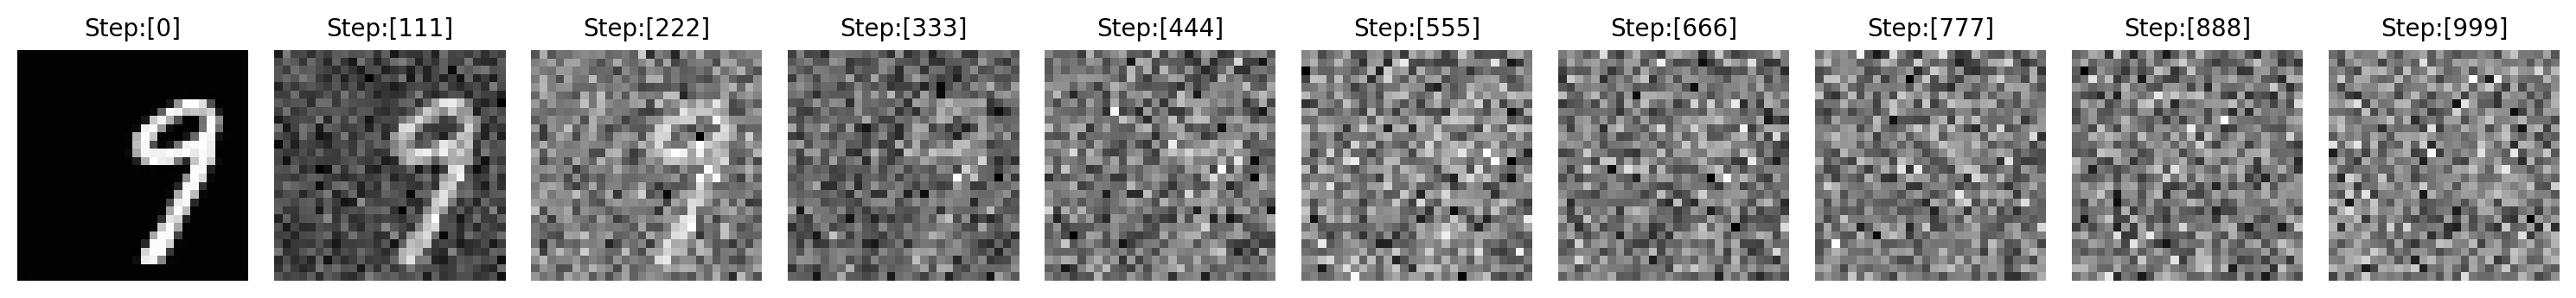

print left


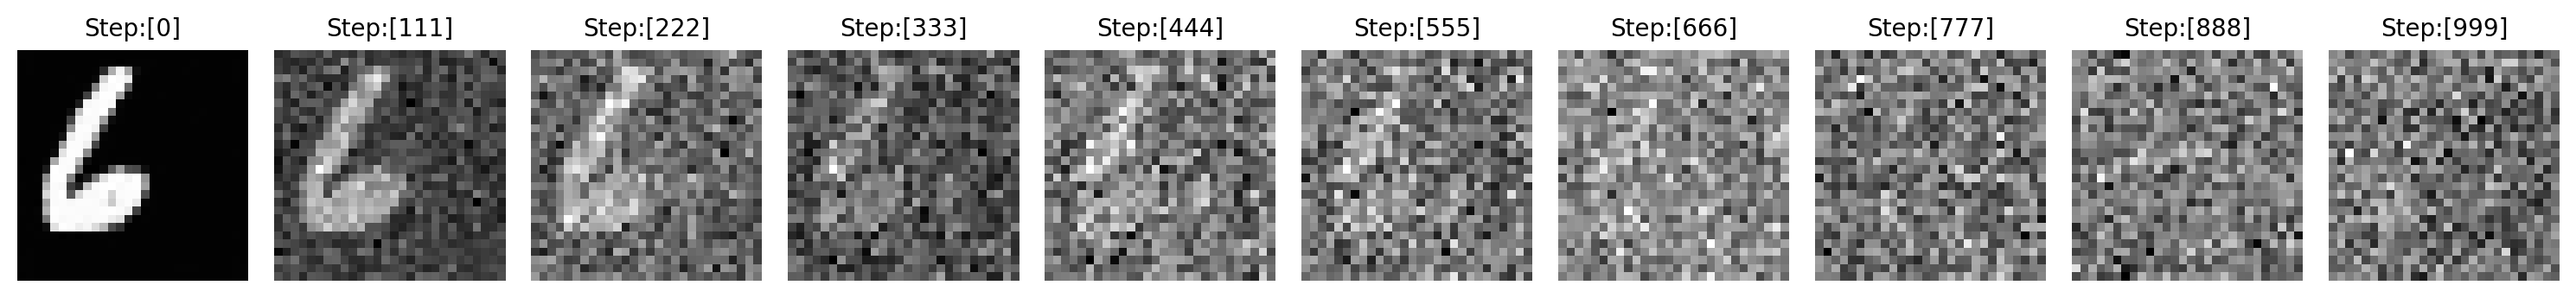

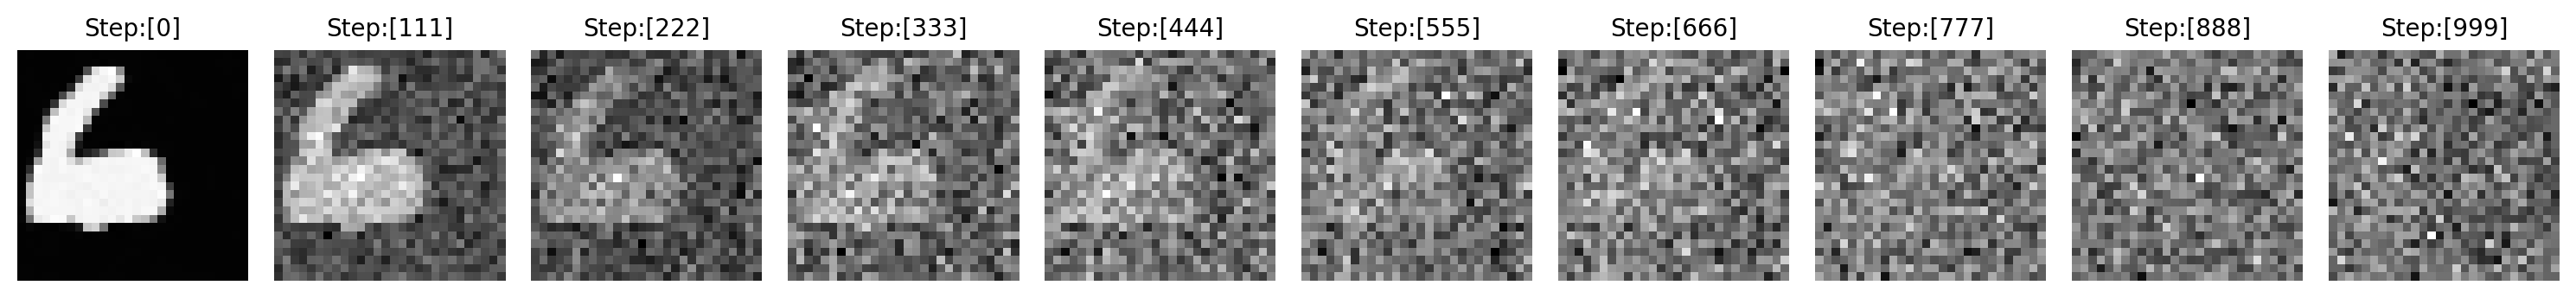

print both


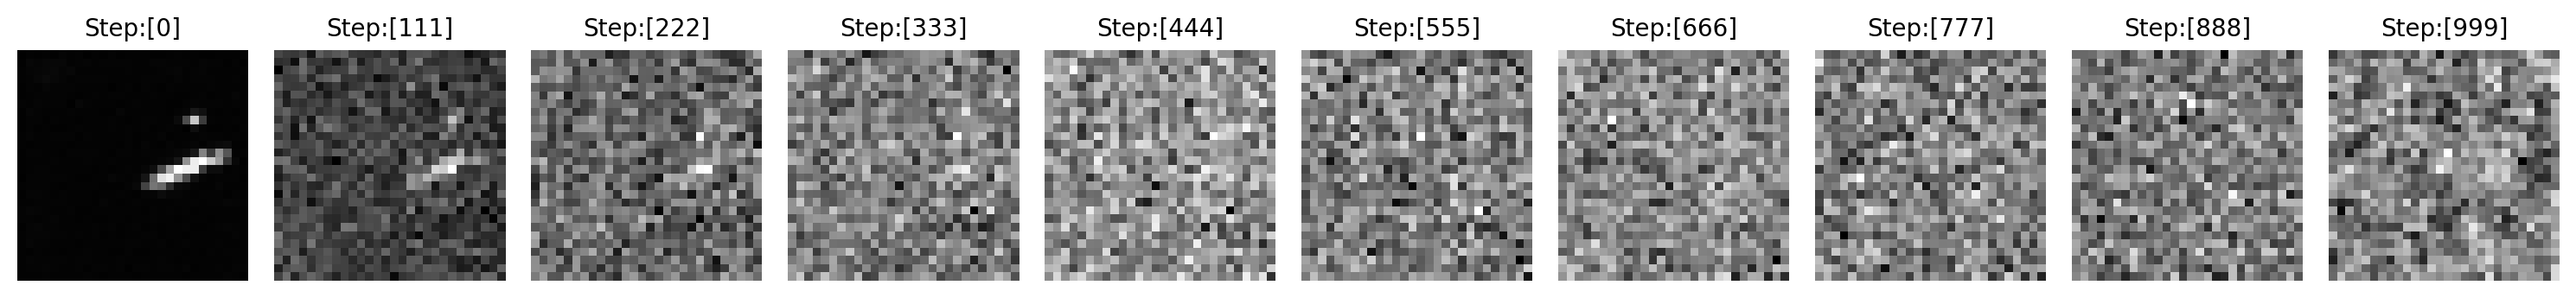

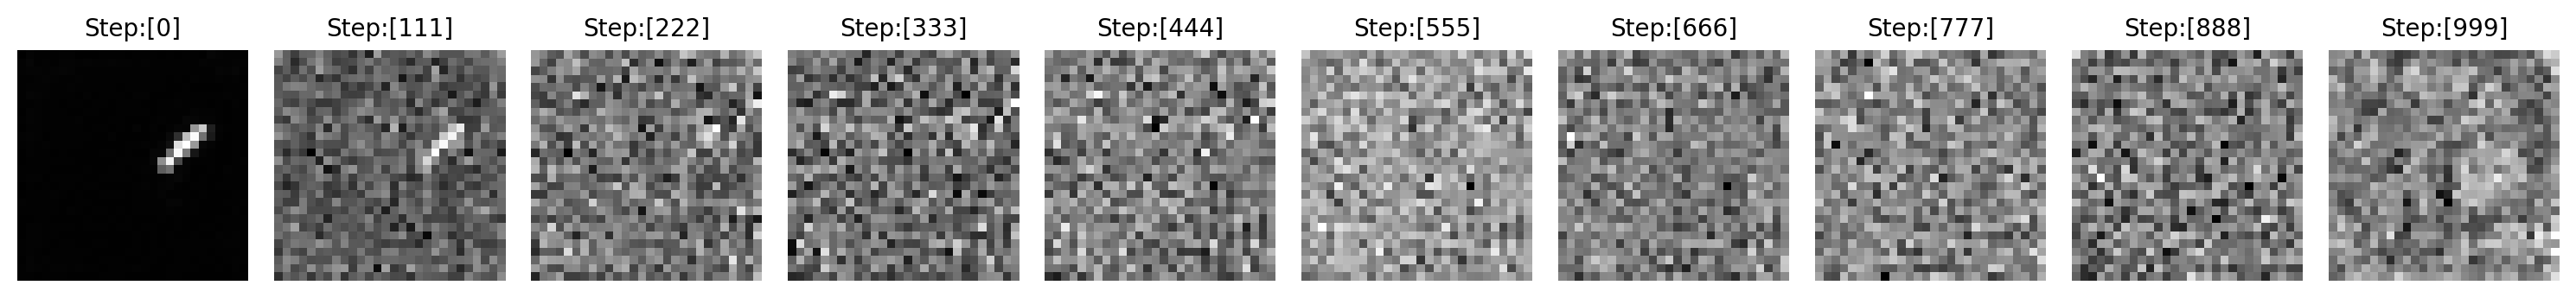

random_int :  8   6
print right


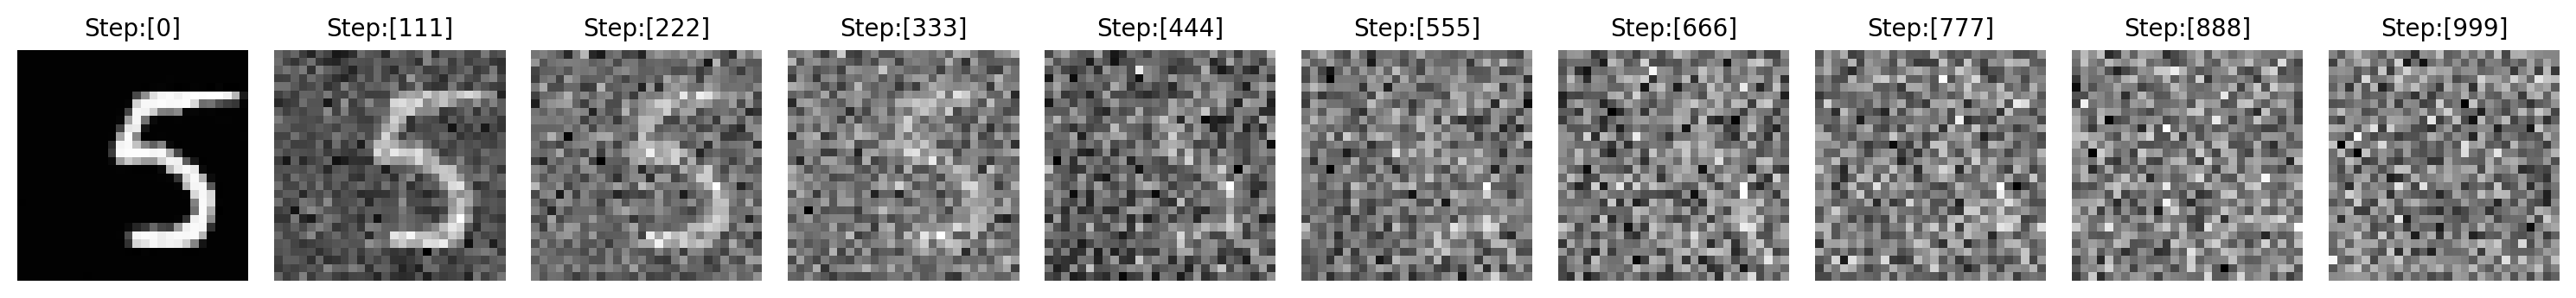

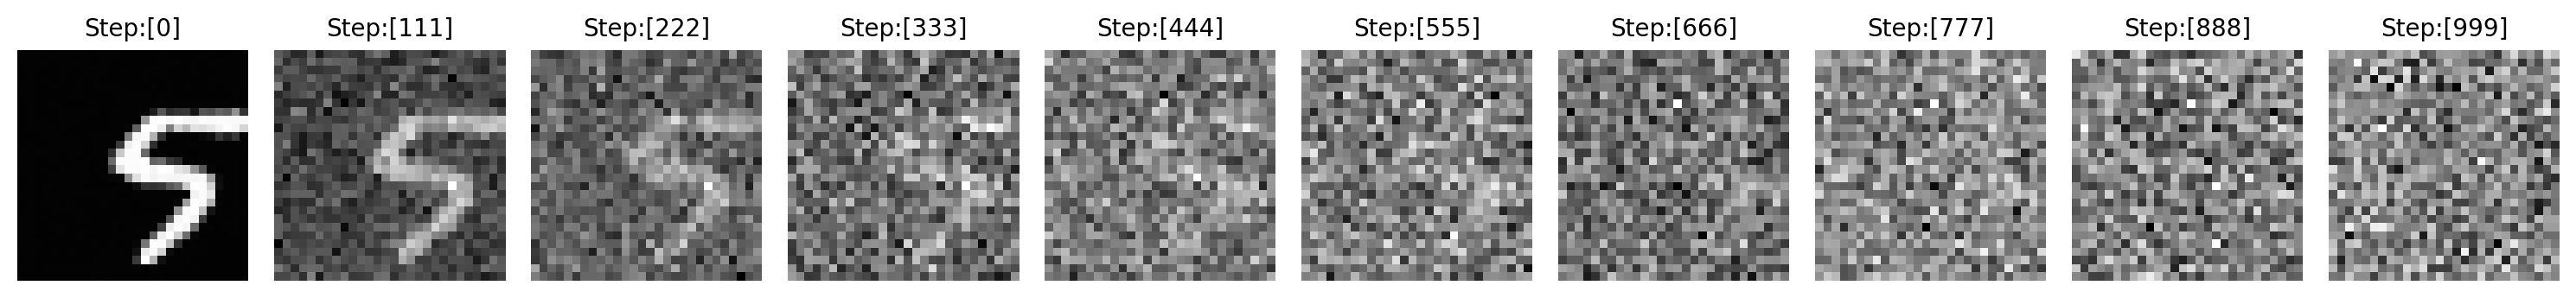

print left


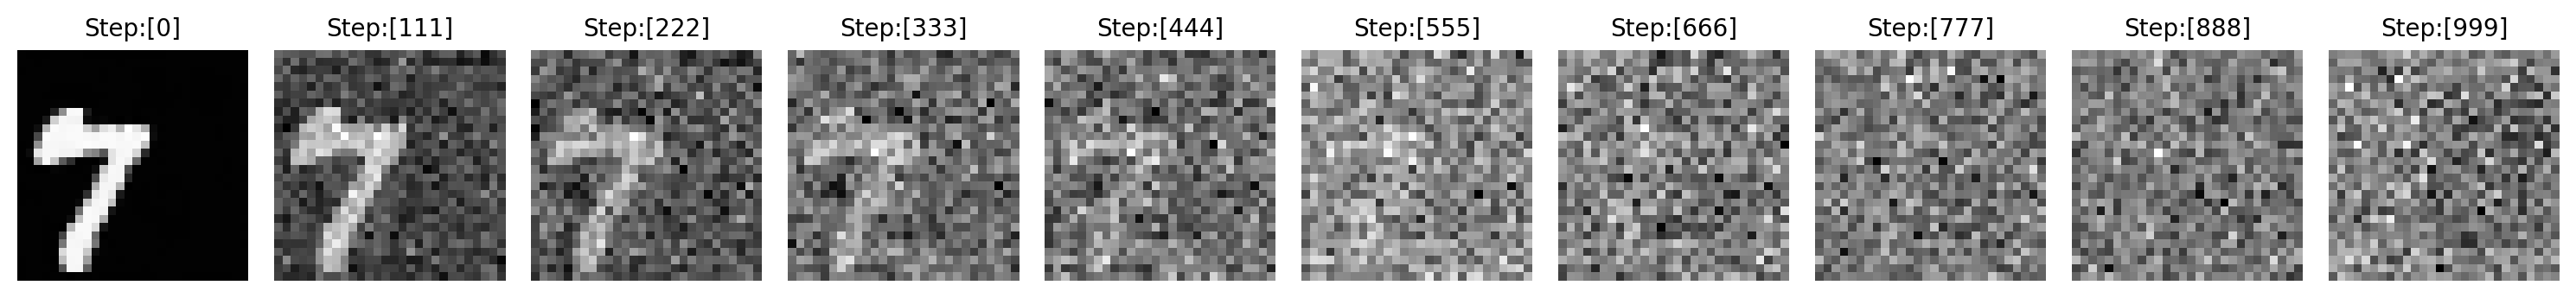

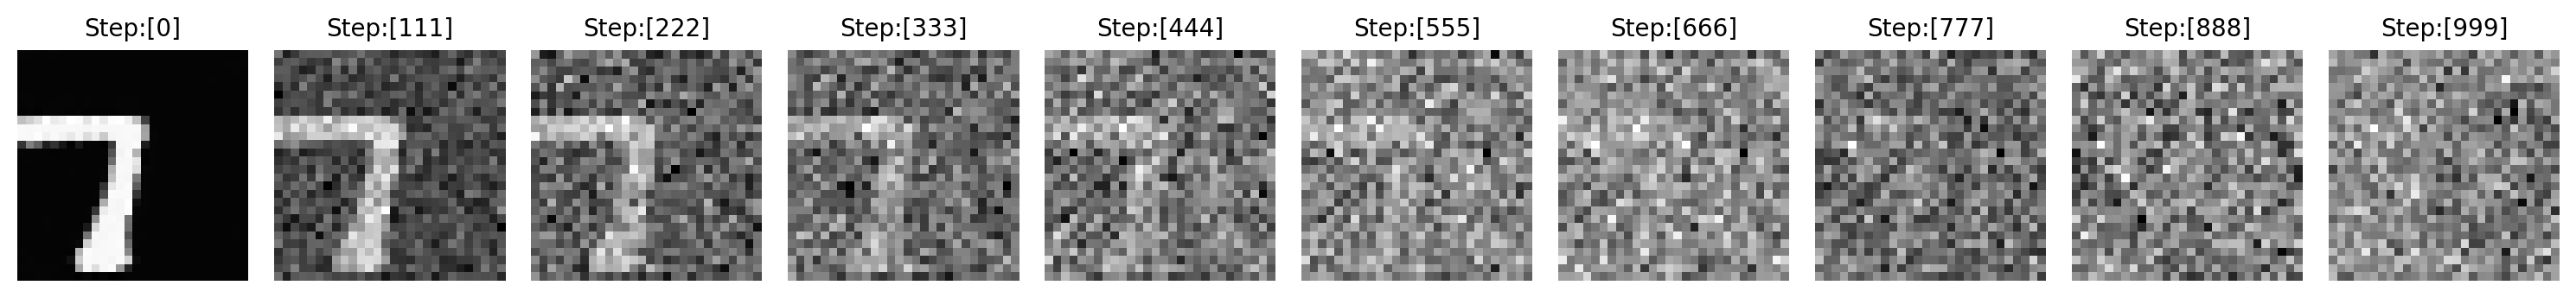

print both


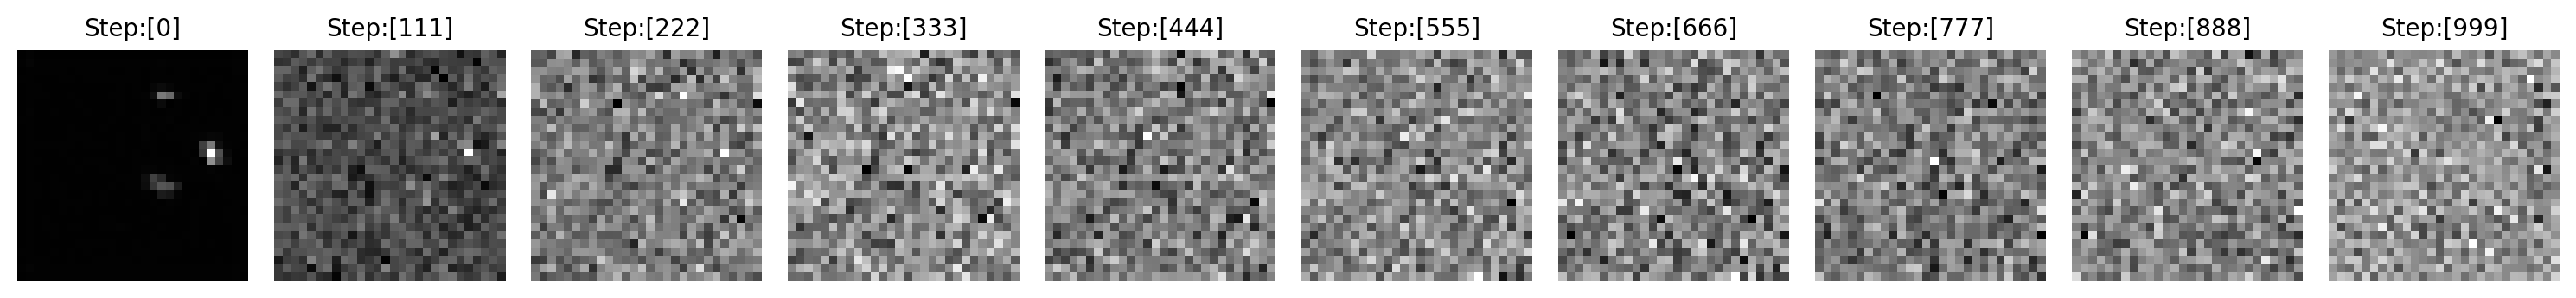

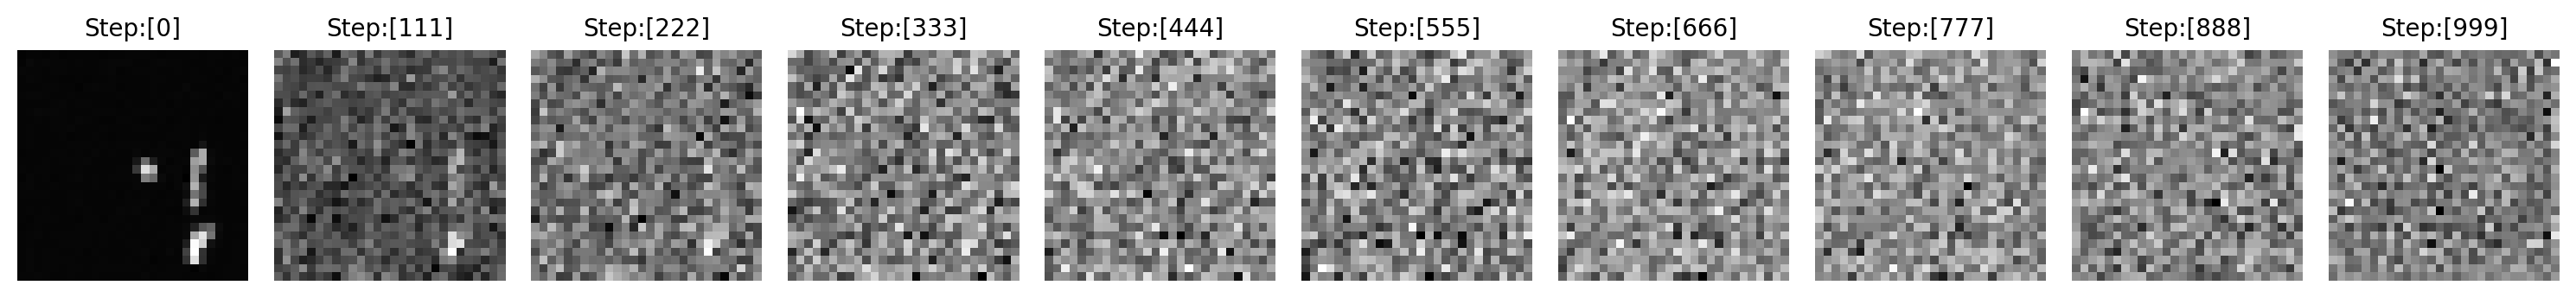

In [18]:
# get_conditioning_embedding_managing([6,0,1,0],device)
# from util import plot_ddpm_2d_result_download
def plot_ddpm_2d_result_download(x_data, step_list, x_t_list, n_plot=1, tfs=10, save_path=None):
    """
    :param x_data: [N x C x W x H] torch tensor, training data
    :param step_list: [M] ndarray, diffusion steps to append x_t
    :param x_t_list: list of [n_sample x C x L] torch tensors
    :param n_plot: number of samples to plot (default is 1)
    :param tfs: title font size (default is 10)
    :param save_path: path to save the figure (optional)
    """
    for sample_idx in range(n_plot):
        plt.figure(figsize=(15, 2))
        for i_idx, t in enumerate(step_list):
            x_t = x_t_list[t]  # [n_sample x C x W x H]
            x_t_np = x_t.detach().cpu().numpy()  # [n_sample x C x W x H]
            plt.subplot(1, len(step_list), i_idx + 1)
            if x_data.shape[1] == 1:  # gray image
                plt.imshow(x_t_np[sample_idx, 0, :, :], cmap='gray')
            else:
                plt.imshow(x_t_np[sample_idx, :, :, :].transpose(1, 2, 0))
            plt.axis('off')
            plt.title('Step:[%d]' % (t), fontsize=tfs)
        
        plt.tight_layout()
        
        # Save the figure if save_path is provided
        if save_path is not None:
            plt.savefig(save_path.format(sample_idx), bbox_inches='tight')
        
        plt.show()
        
import random
max_sampling_num = 4
for idx in range(max_sampling_num):
    random_int1 = random.randint(1, 10)
    random_int2 = random.randint(1, 10)
    print("random_int : ", random_int1, " ", random_int2)
    print("print right")
    n_sample = 20
    step_list_to_append = np.linspace(0,999,10).astype(np.int64) # save 10 x_ts
    x_t_list = eval_ddpm_2d(model,dc,n_sample,x_0,step_list_to_append,device,torch.tensor([0,random_int2,0,1], dtype=torch.float32).to(device))
    plot_ddpm_2d_result_download(x_0,step_list_to_append,x_t_list,n_plot=2,save_path="./2d_example_result/left_right_simple/"+'_'.join([str(x) for x in [0,random_int2,0,1]]))

    print("print left")
    x_t_list = eval_ddpm_2d(model,dc,n_sample,x_0,step_list_to_append,device,torch.tensor([random_int1,0,1,0], dtype=torch.float32).to(device))
    plot_ddpm_2d_result_download(x_0,step_list_to_append,x_t_list,n_plot=2,save_path="./2d_example_result/left_right_simple/"+'_'.join([str(x) for x in [random_int1,0,1,0]]))


    print("print both")
    x_t_list = eval_ddpm_2d(model,dc,n_sample,x_0,step_list_to_append,device,torch.tensor([random_int1,random_int2,1,1], dtype=torch.float32).to(device))
    plot_ddpm_2d_result_download(x_0,step_list_to_append,x_t_list,n_plot=2,save_path="./2d_example_result/left_right_simple/"+'_'.join([str(x) for x in [random_int1,random_int2,1,1]]))


random_int :  7   6
print none -positional none


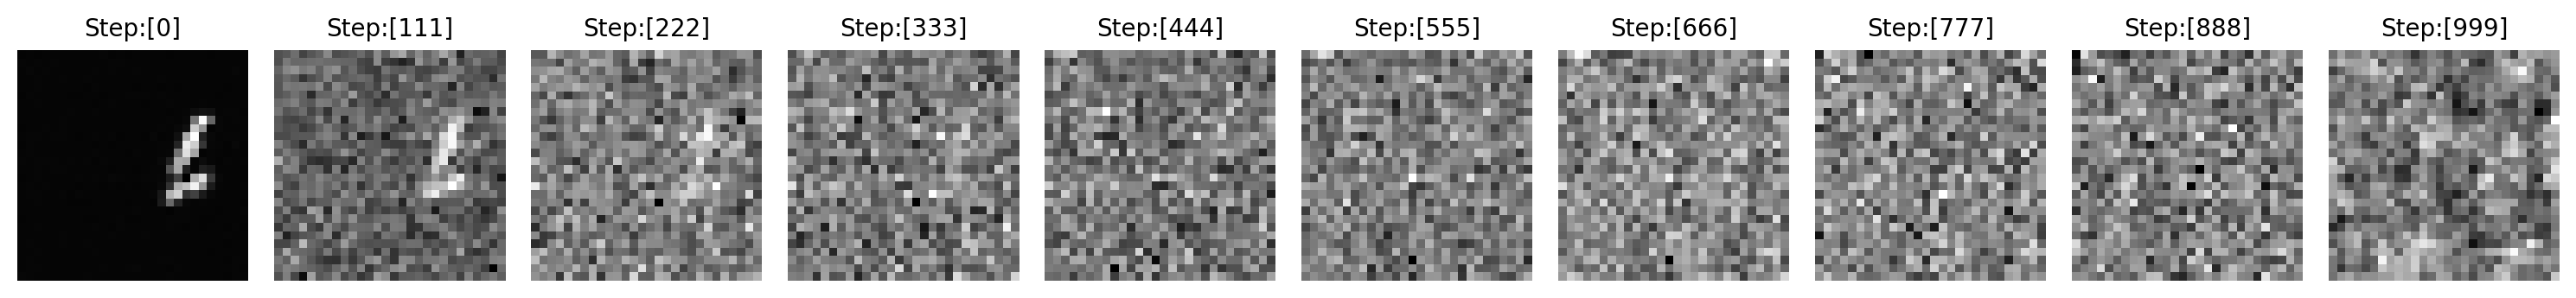

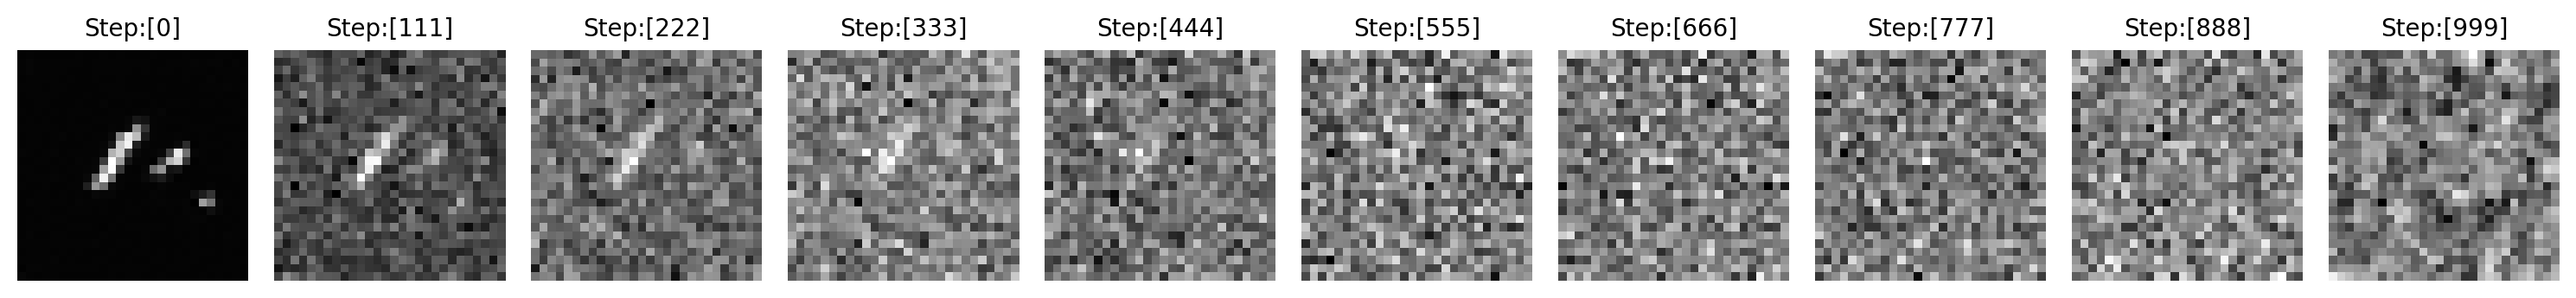

print none -positional none,left number


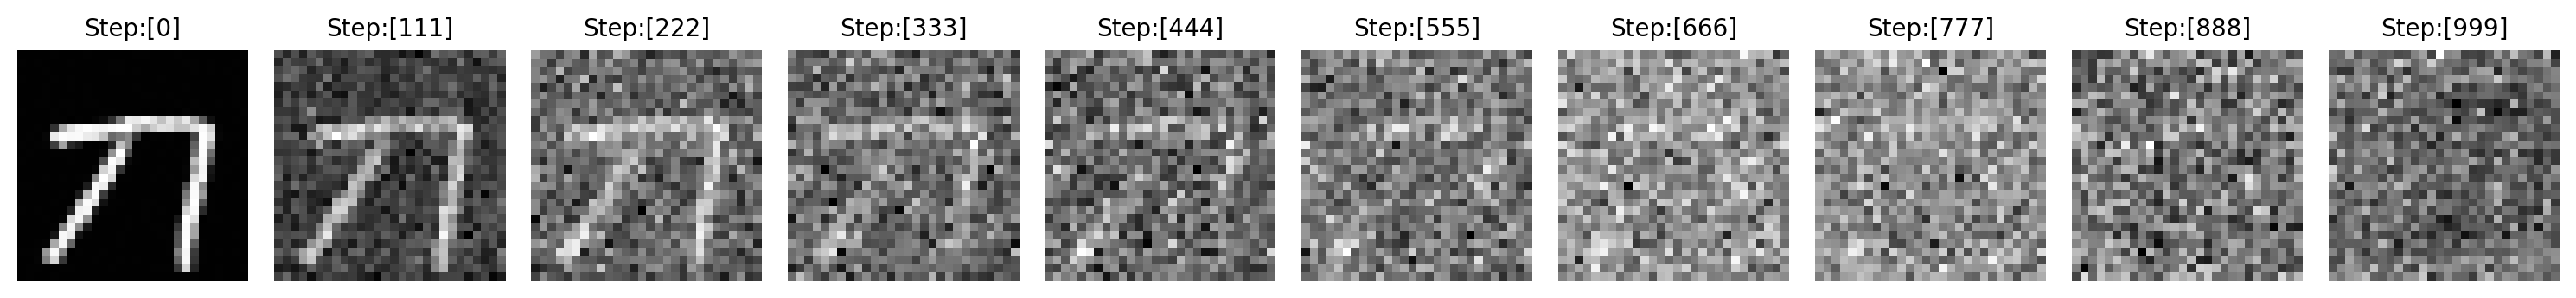

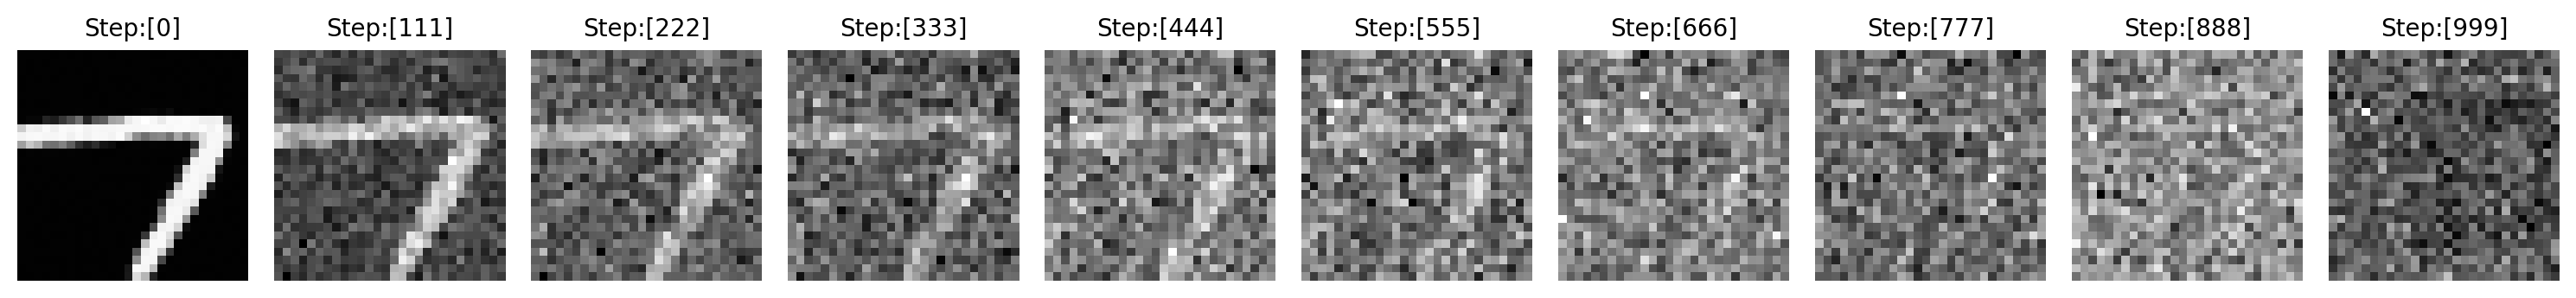

print none -positional none,right number


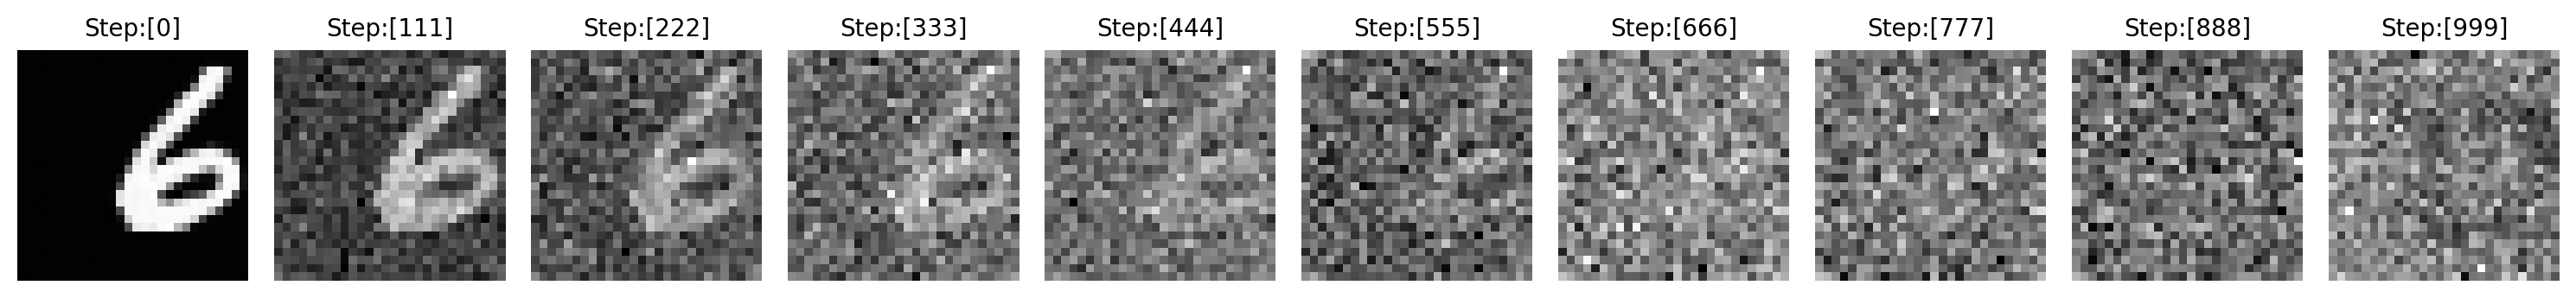

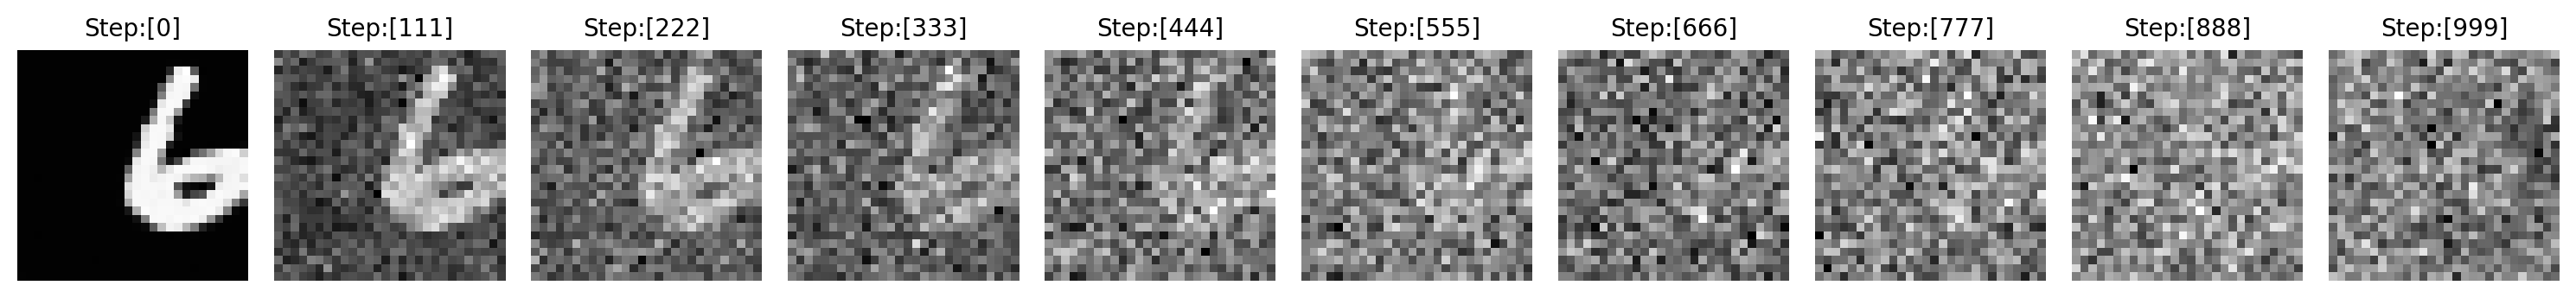

random_int :  0   7
print none -positional none


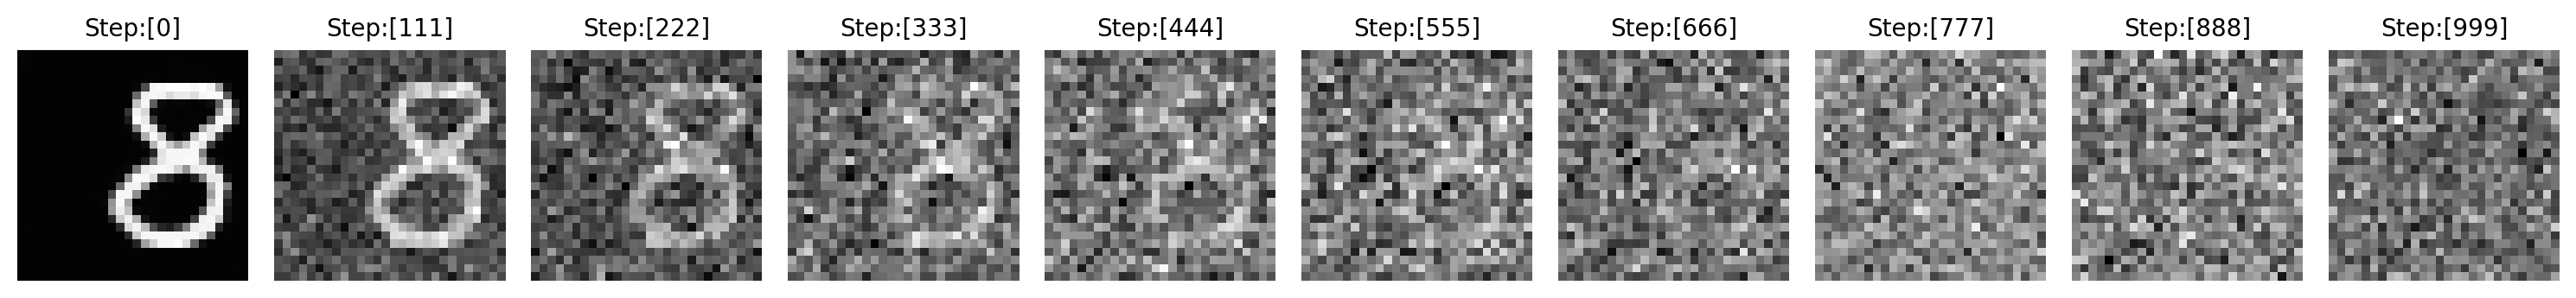

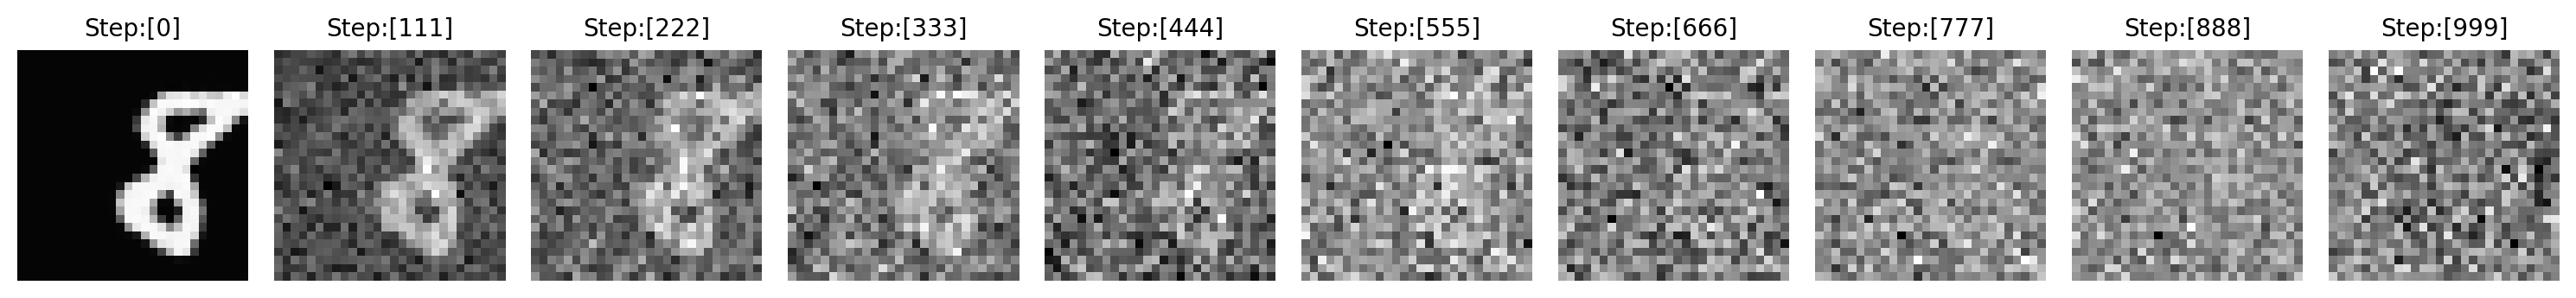

print none -positional none,left number


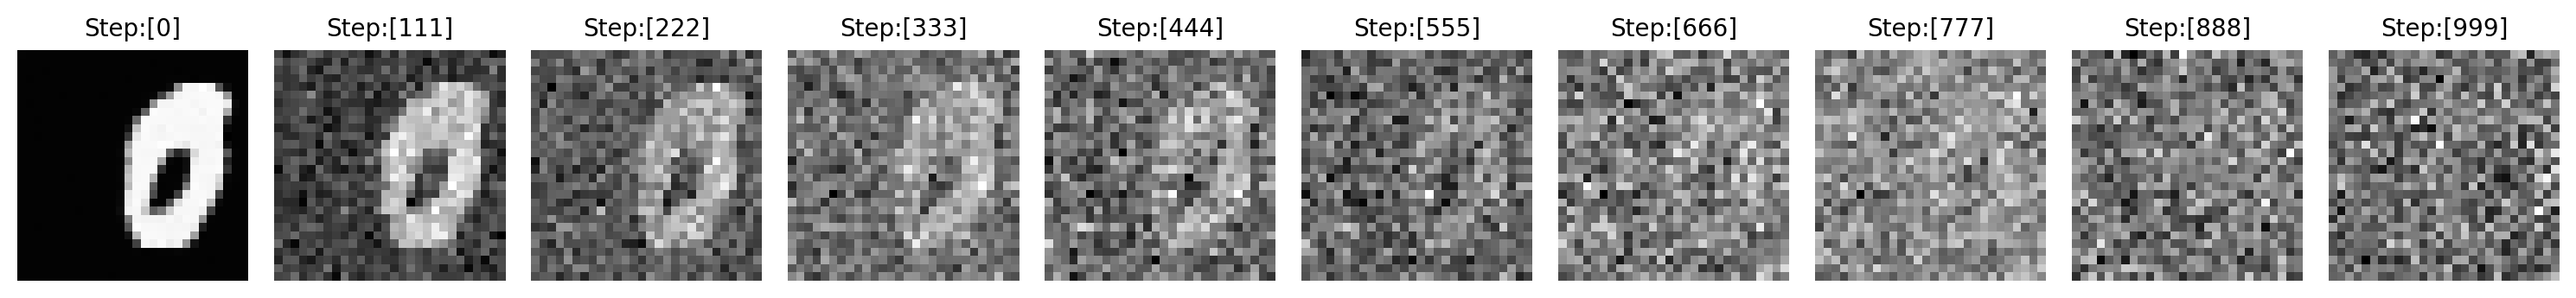

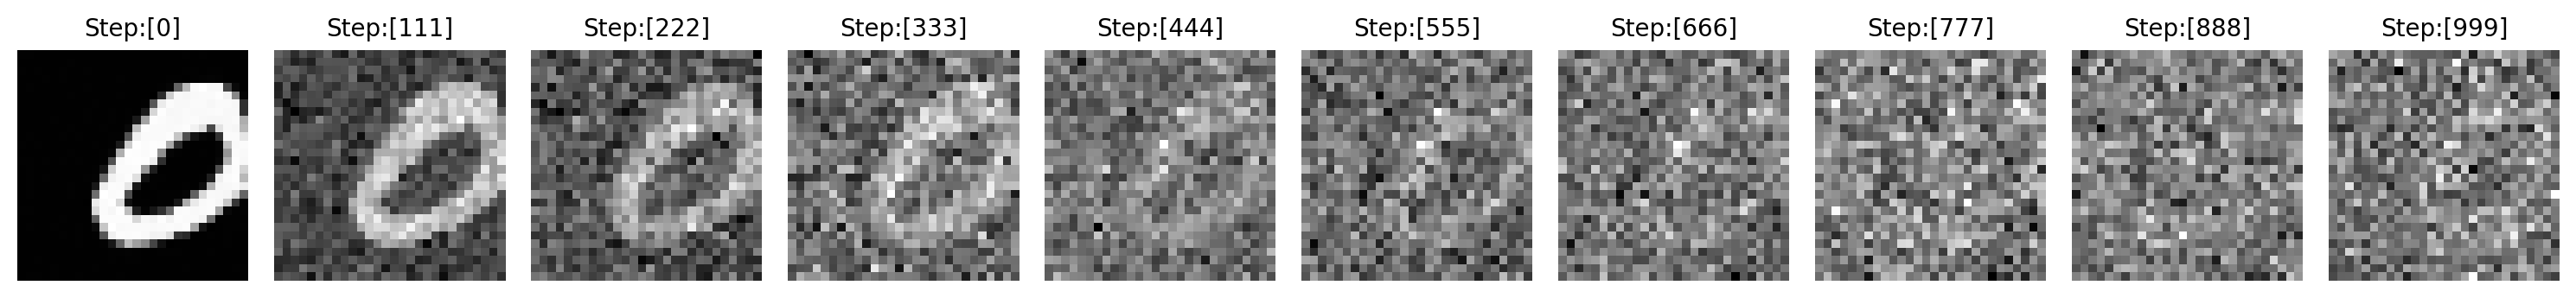

print none -positional none,right number


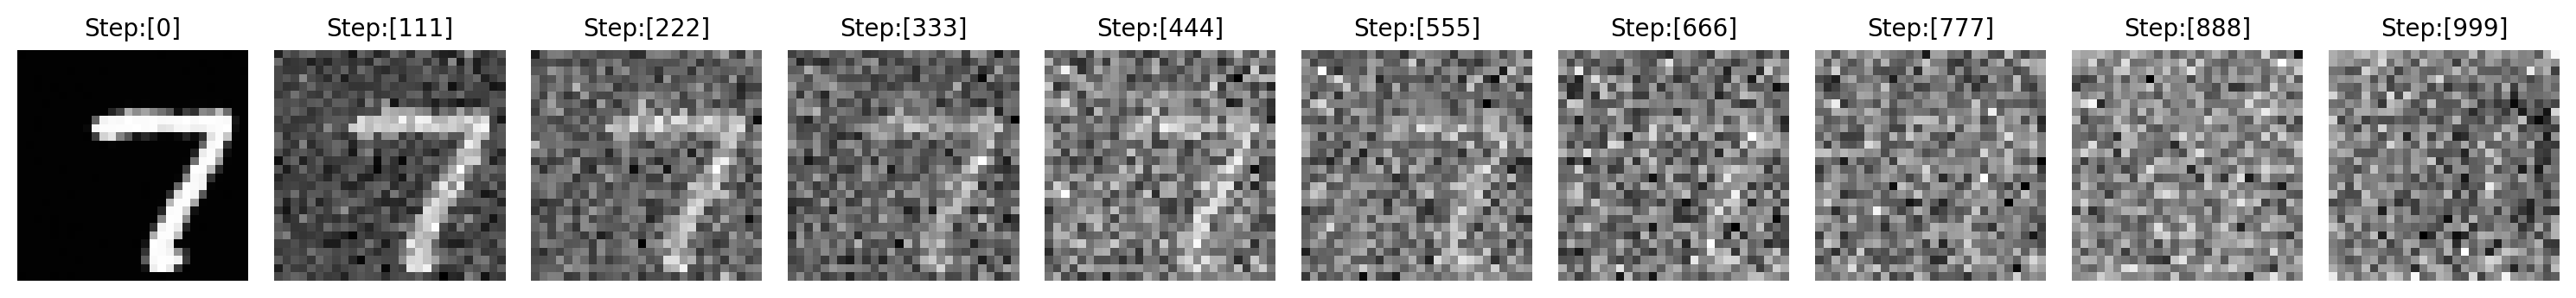

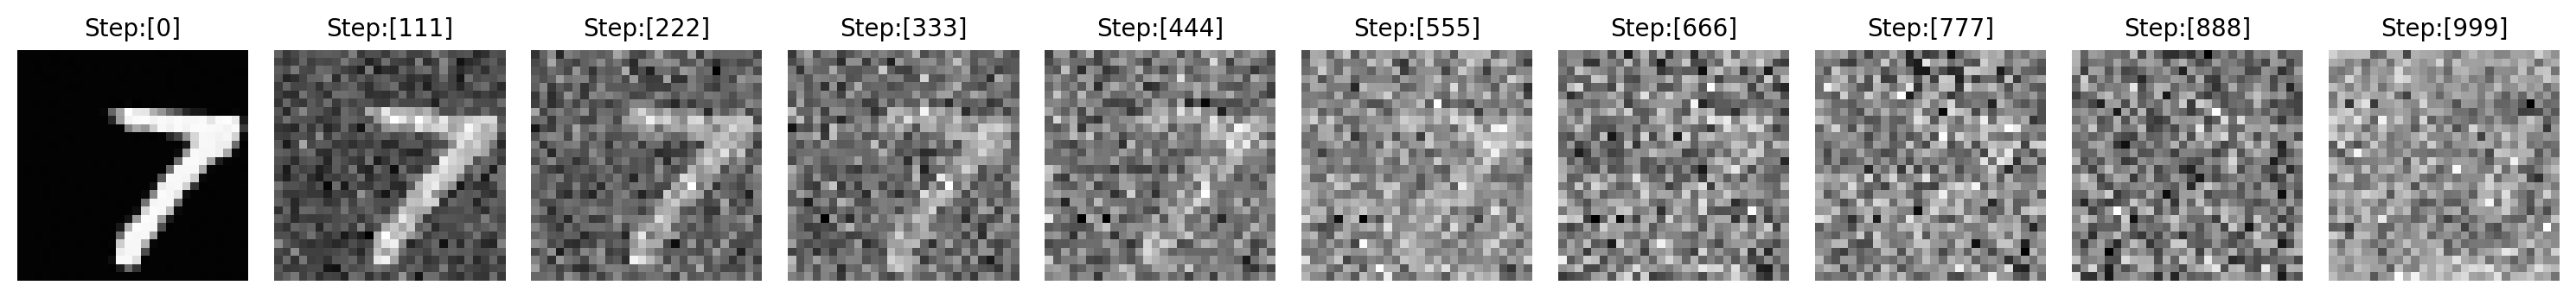

print none -number none


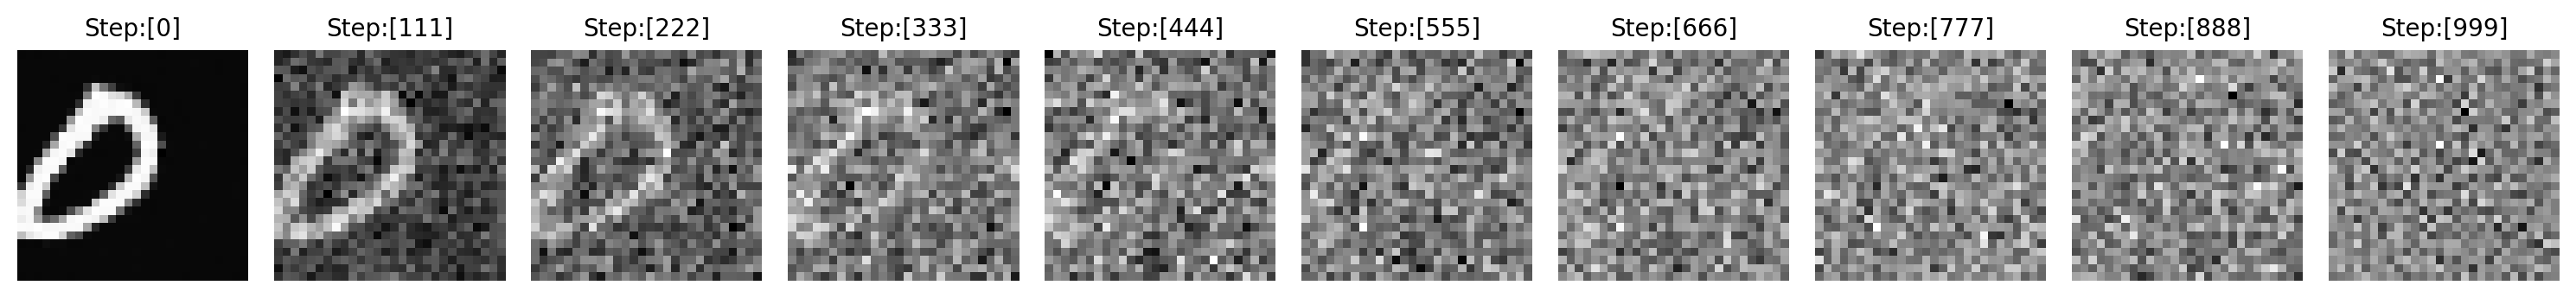

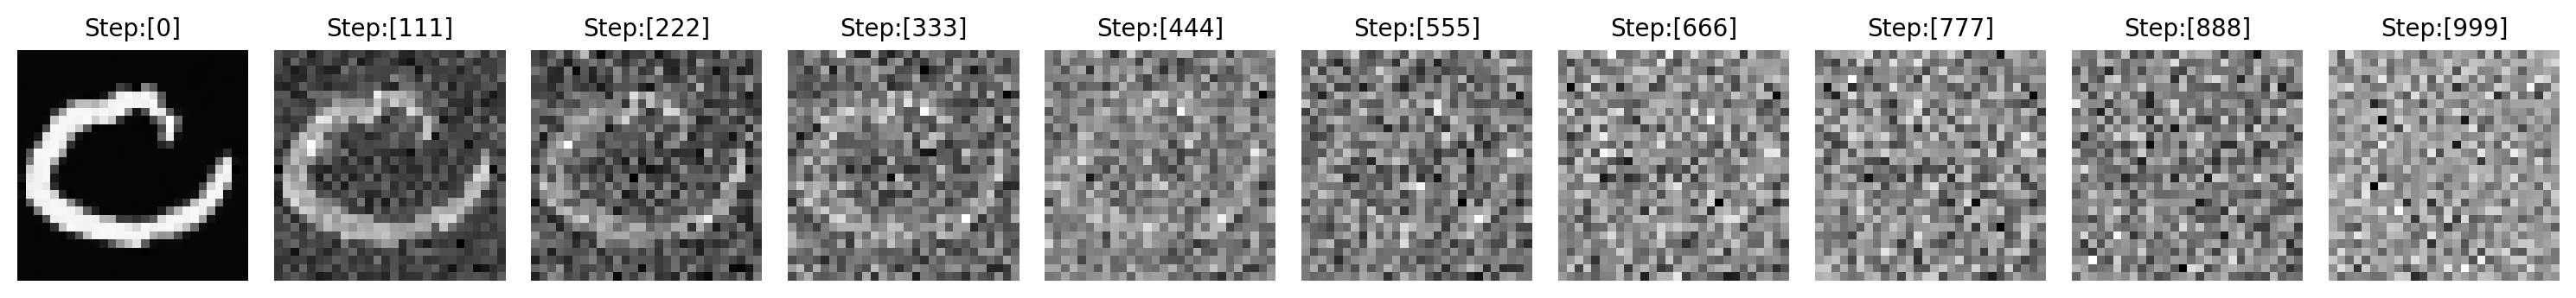

print none -number none


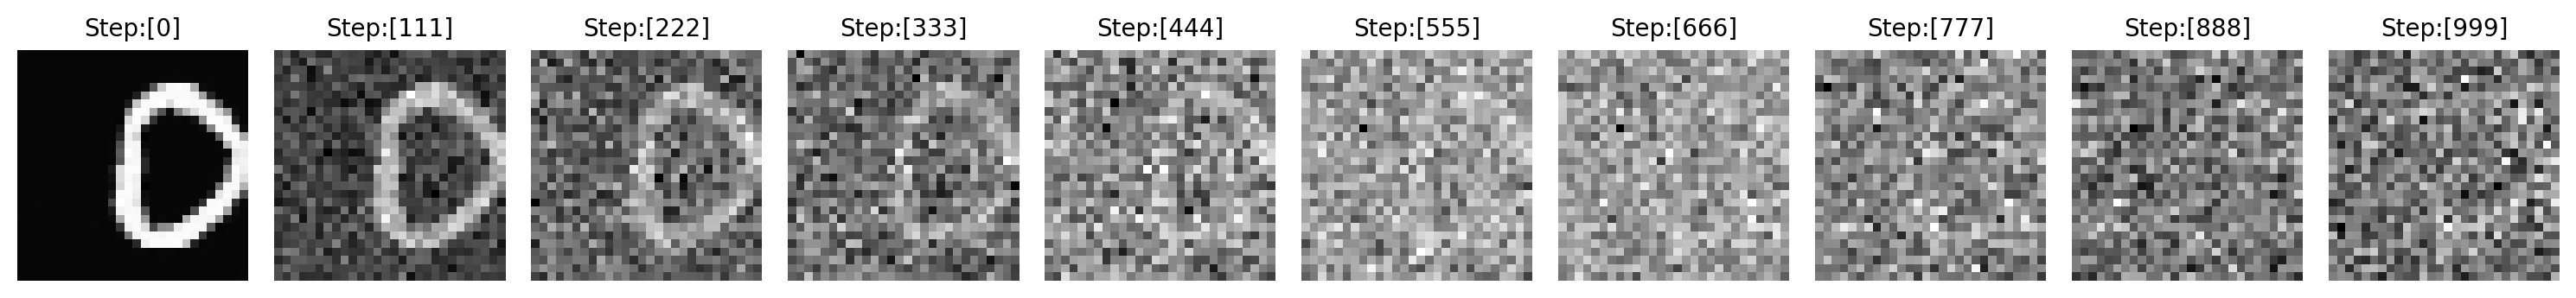

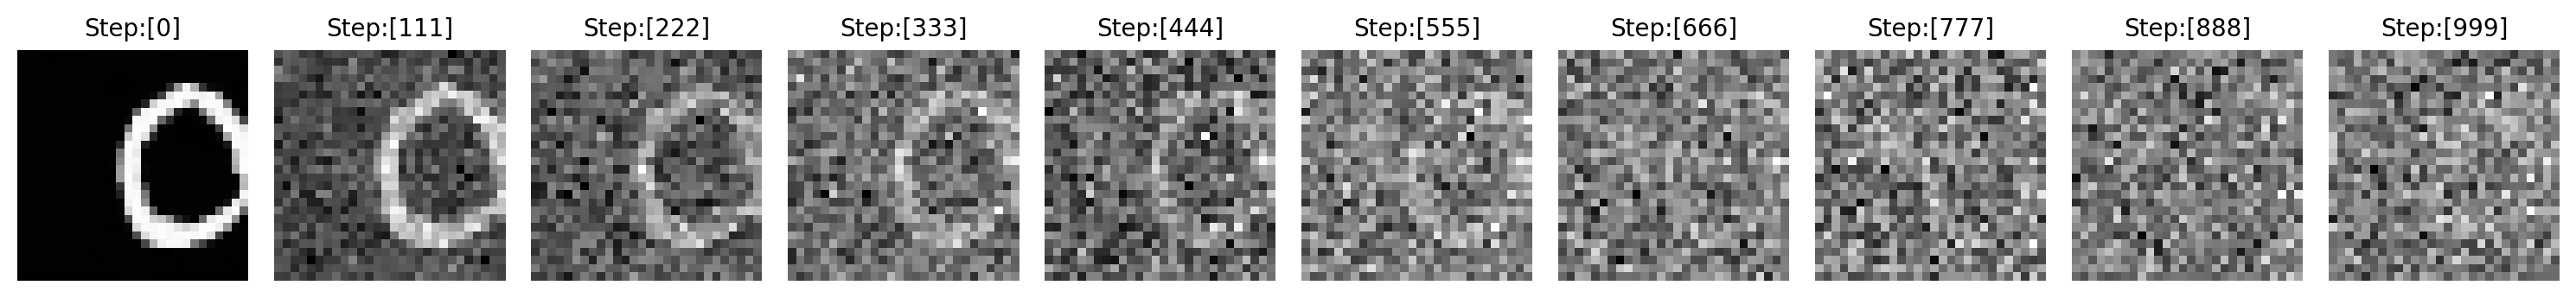

print none -number none


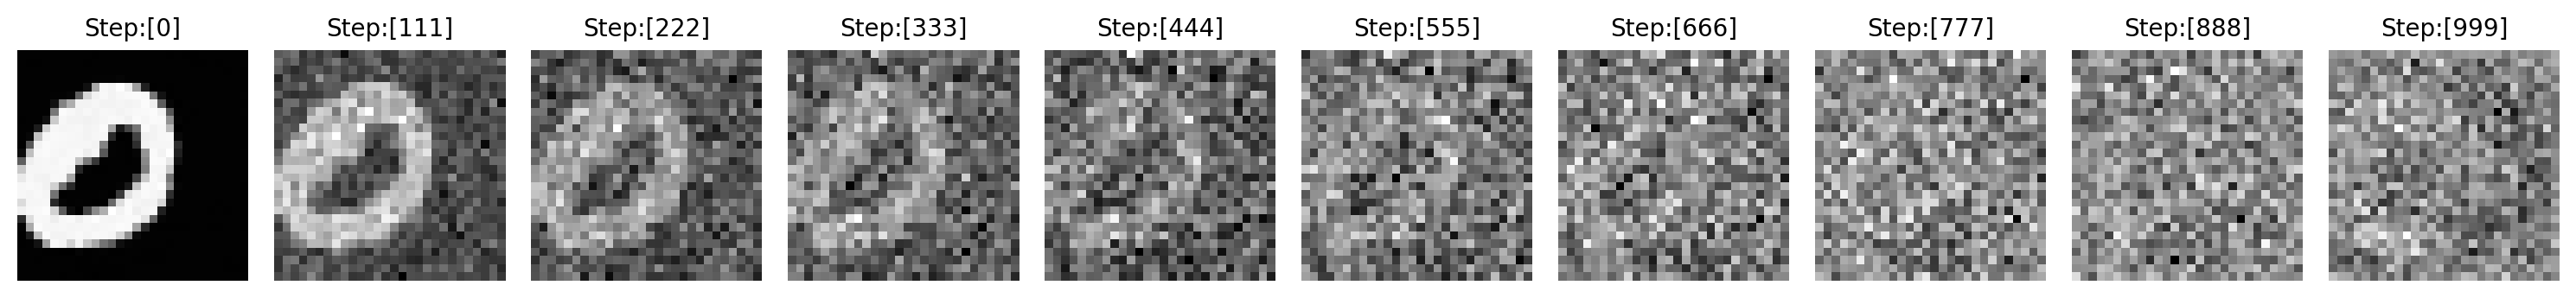

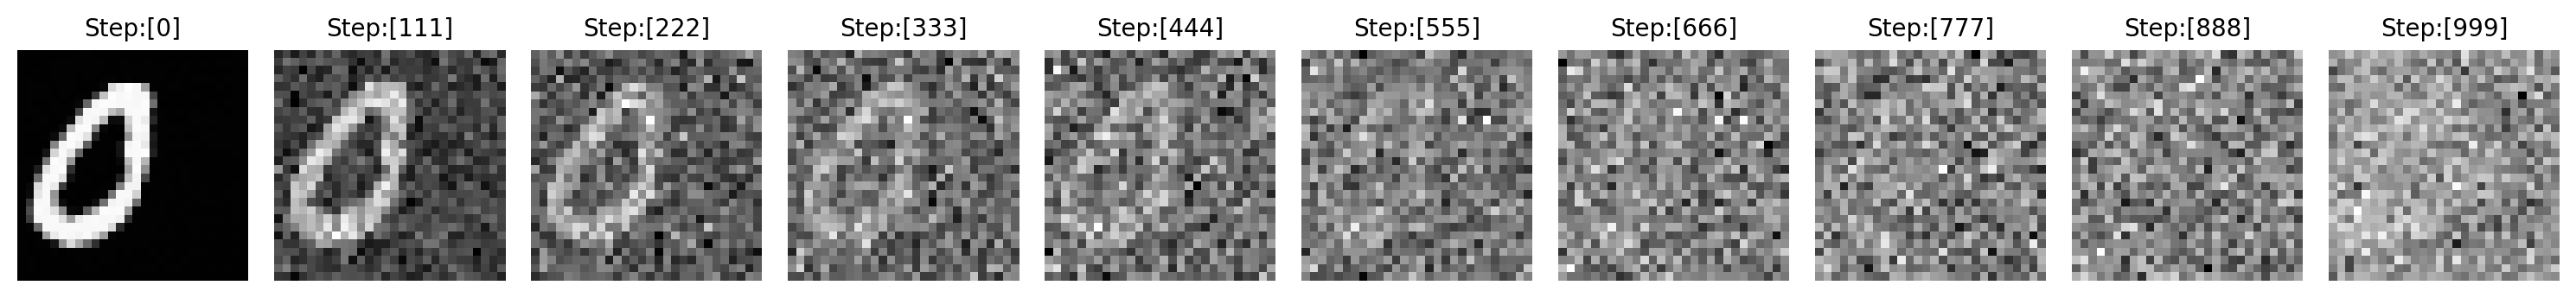

print none - all none


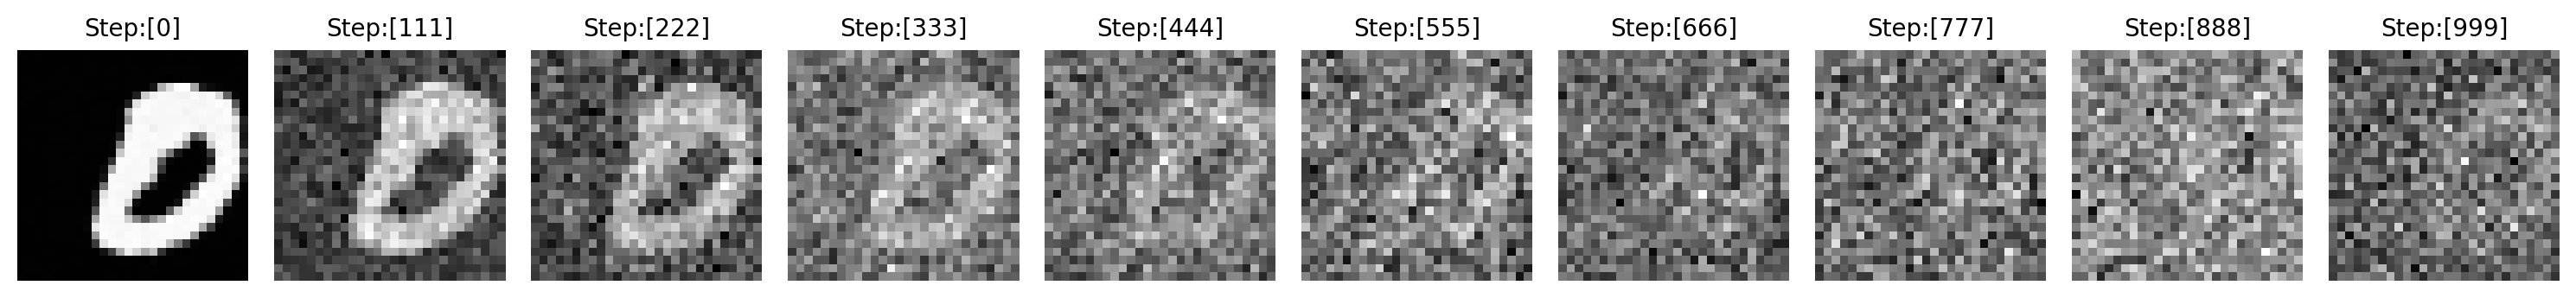

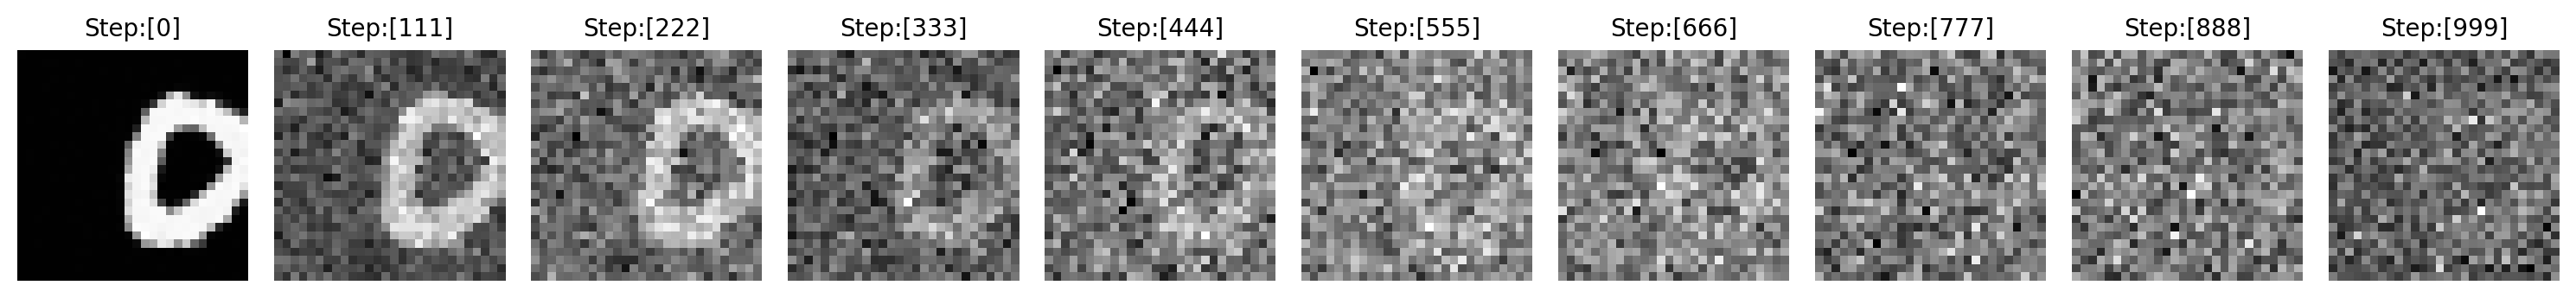

In [19]:
# get_conditioning_embedding_managing([6,0,1,0],device)

import random
max_sampling_num = 2
for idx in range(max_sampling_num):
    random_int1 = random.randint(1, 10)
    random_int2 = random.randint(1, 10)
    print("random_int : ", random_int1 -1, " ", random_int2-1)


    print("print none -positional none")
    n_sample = 20
    step_list_to_append = np.linspace(0,999,10).astype(np.int64) # save 10 x_ts
    x_t_list = eval_ddpm_2d(model,dc,n_sample,x_0,step_list_to_append,device,torch.tensor([random_int1,random_int2,0,0], dtype=torch.float32).to(device))
    # plot_ddpm_2d_result(x_0,step_list_to_append,x_t_list,n_plot=2)
    plot_ddpm_2d_result_download(x_0,step_list_to_append,x_t_list,n_plot=2,save_path="./2d_example_result/left_right_simple/"+'_'.join([str(x) for x in [random_int1,random_int2,0,0]]))



    print("print none -positional none,left number")
    x_t_list = eval_ddpm_2d(model,dc,n_sample,x_0,step_list_to_append,device,torch.tensor([random_int1,0,0,0], dtype=torch.float32).to(device))
    # plot_ddpm_2d_result(x_0,step_list_to_append,x_t_list,n_plot=2)
    plot_ddpm_2d_result_download(x_0,step_list_to_append,x_t_list,n_plot=2,save_path="./2d_example_result/left_right_simple/"+'_'.join([str(x) for x in [random_int1,0,0,0]]))


    print("print none -positional none,right number")
    x_t_list = eval_ddpm_2d(model,dc,n_sample,x_0,step_list_to_append,device,torch.tensor([0,random_int2,0,0], dtype=torch.float32).to(device))
    # plot_ddpm_2d_result(x_0,step_list_to_append,x_t_list,n_plot=2)
    plot_ddpm_2d_result_download(x_0,step_list_to_append,x_t_list,n_plot=2,save_path="./2d_example_result/left_right_simple/"+'_'.join([str(x) for x in [0,random_int2,0,0]]))


n_sample = 20
print("print none -number none")
x_t_list = eval_ddpm_2d(model,dc,n_sample,x_0,step_list_to_append,device,torch.tensor([0,0,1,1], dtype=torch.float32).to(device))
# plot_ddpm_2d_result(x_0,step_list_to_append,x_t_list,n_plot=2)
plot_ddpm_2d_result_download(x_0,step_list_to_append,x_t_list,n_plot=2,save_path="./2d_example_result/left_right_simple/"+'_'.join([str(x) for x in [0,0,1,1]]))


print("print none -number none")
x_t_list = eval_ddpm_2d(model,dc,n_sample,x_0,step_list_to_append,device,torch.tensor([0,0,0,1], dtype=torch.float32).to(device))
# plot_ddpm_2d_result(x_0,step_list_to_append,x_t_list,n_plot=2)
plot_ddpm_2d_result_download(x_0,step_list_to_append,x_t_list,n_plot=2,save_path="./2d_example_result/left_right_simple/"+'_'.join([str(x) for x in [0,0,1,1]]))


print("print none -number none")
x_t_list = eval_ddpm_2d(model,dc,n_sample,x_0,step_list_to_append,device,torch.tensor([0,0,1,0], dtype=torch.float32).to(device))
# plot_ddpm_2d_result(x_0,step_list_to_append,x_t_list,n_plot=2)
plot_ddpm_2d_result_download(x_0,step_list_to_append,x_t_list,n_plot=2,save_path="./2d_example_result/left_right_simple/"+'_'.join([str(x) for x in [0,0,1,0]]))


print("print none - all none")
x_t_list = eval_ddpm_2d(model,dc,n_sample,x_0,step_list_to_append,device,torch.tensor([0,0,0,0], dtype=torch.float32).to(device))
# plot_ddpm_2d_result(x_0,step_list_to_append,x_t_list,n_plot=2)
plot_ddpm_2d_result_download(x_0,step_list_to_append,x_t_list,n_plot=2,save_path="./2d_example_result/left_right_simple/"+'_'.join([str(x) for x in [0,0,0,0]]))


print number 0 position 2


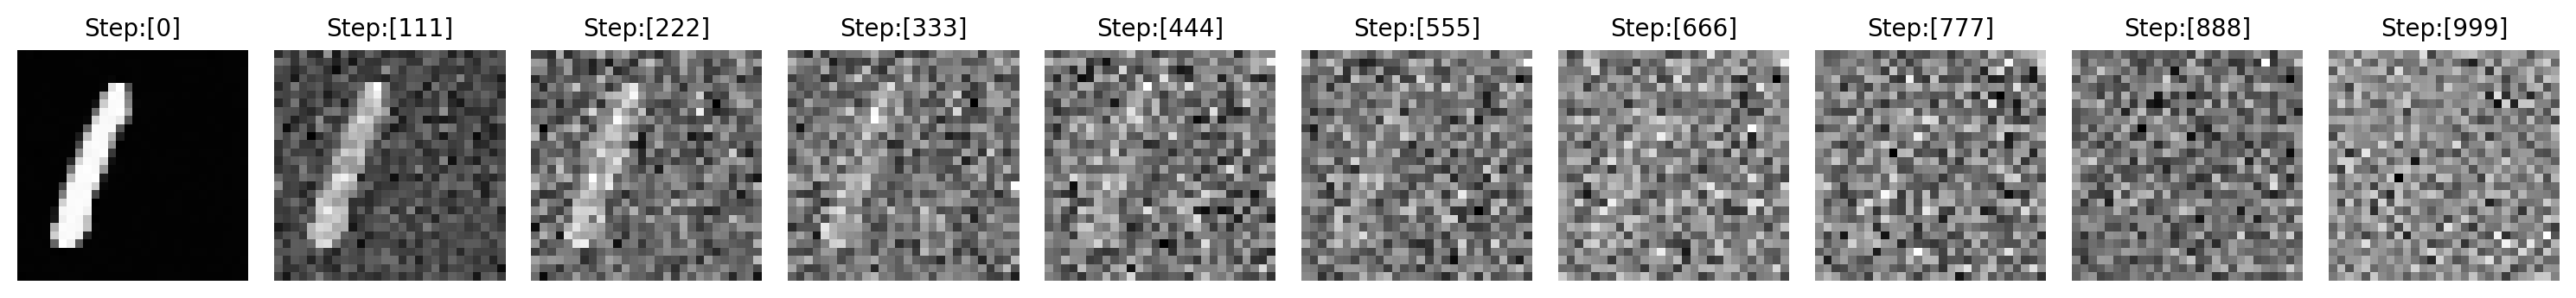

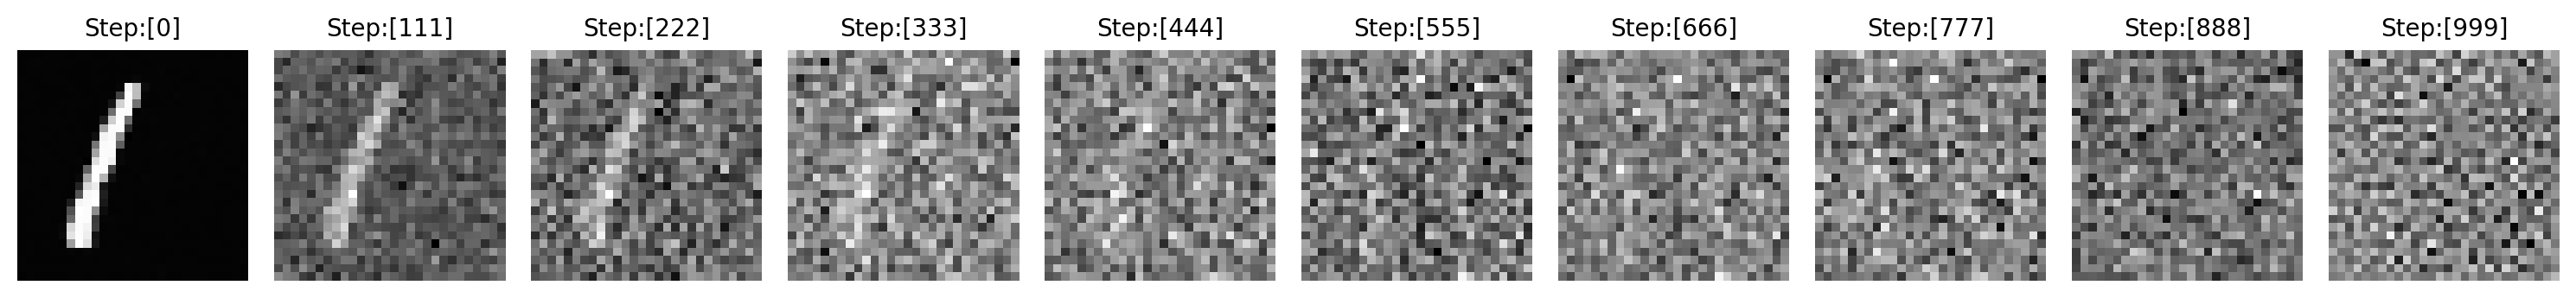

print number 0 position 3


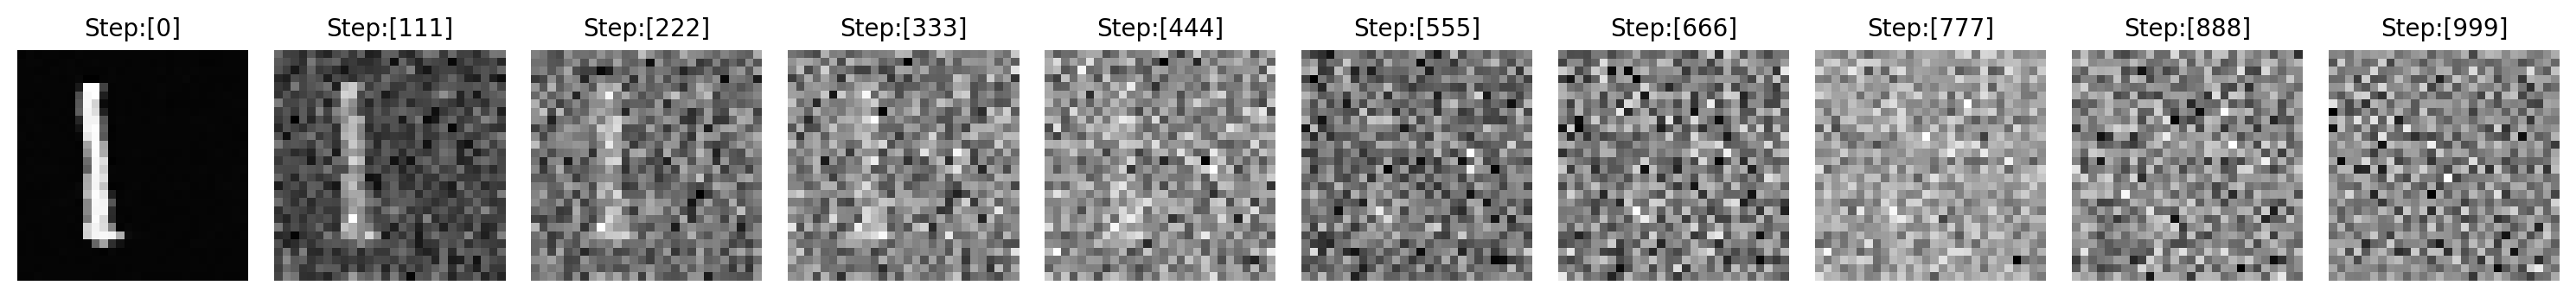

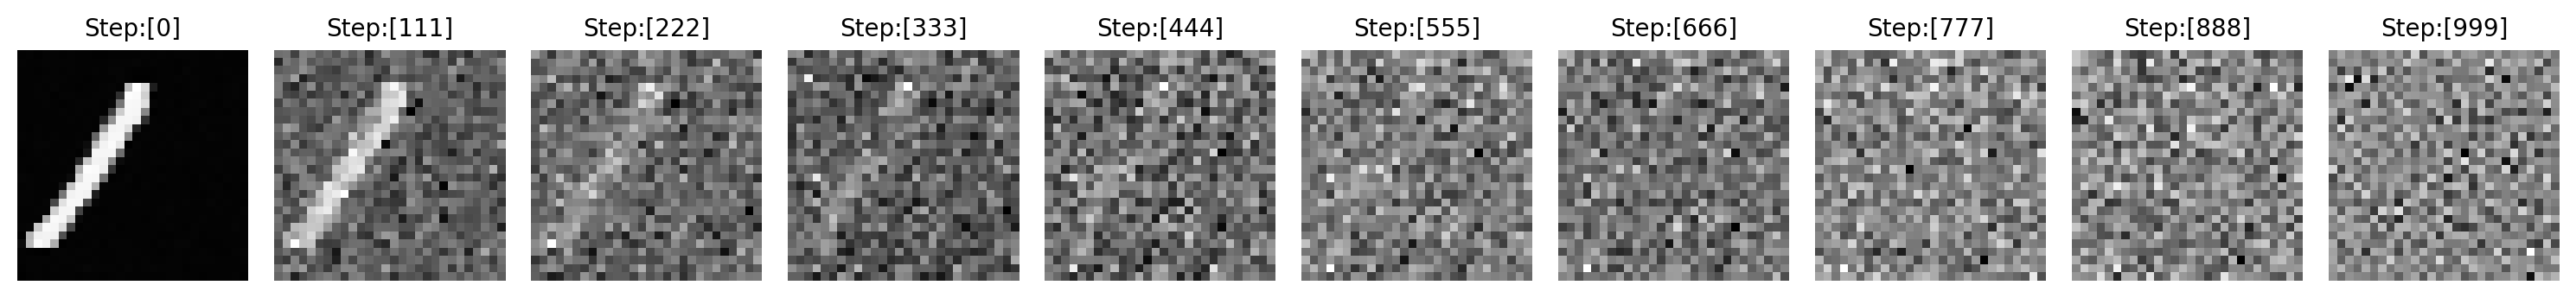

print number 0 position 10


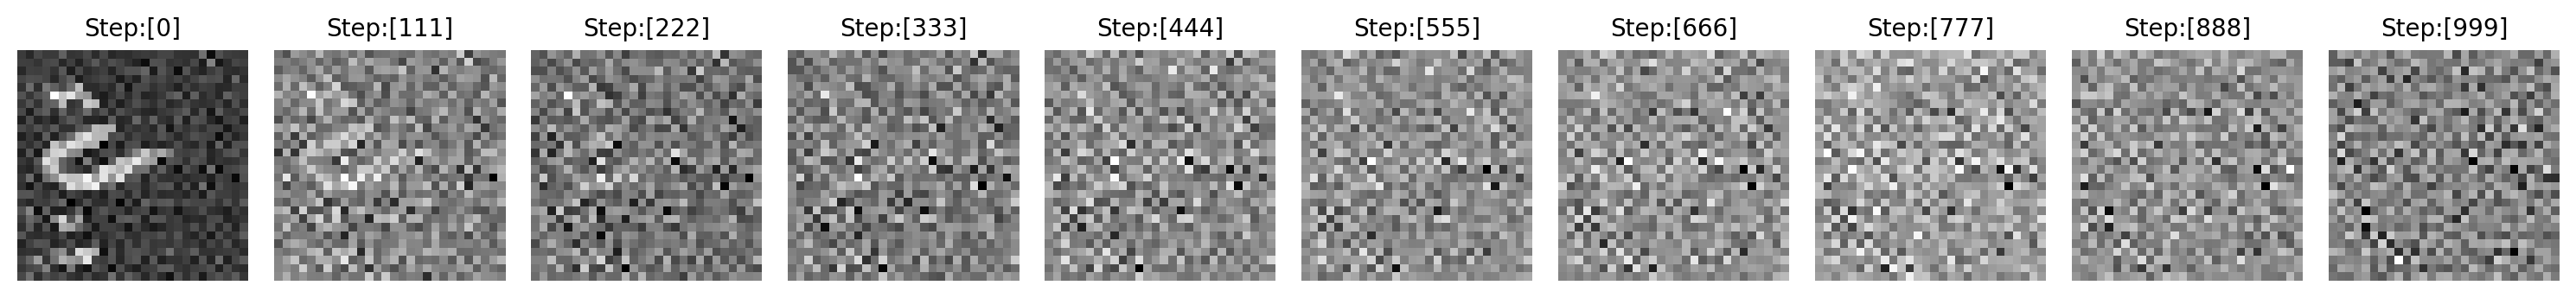

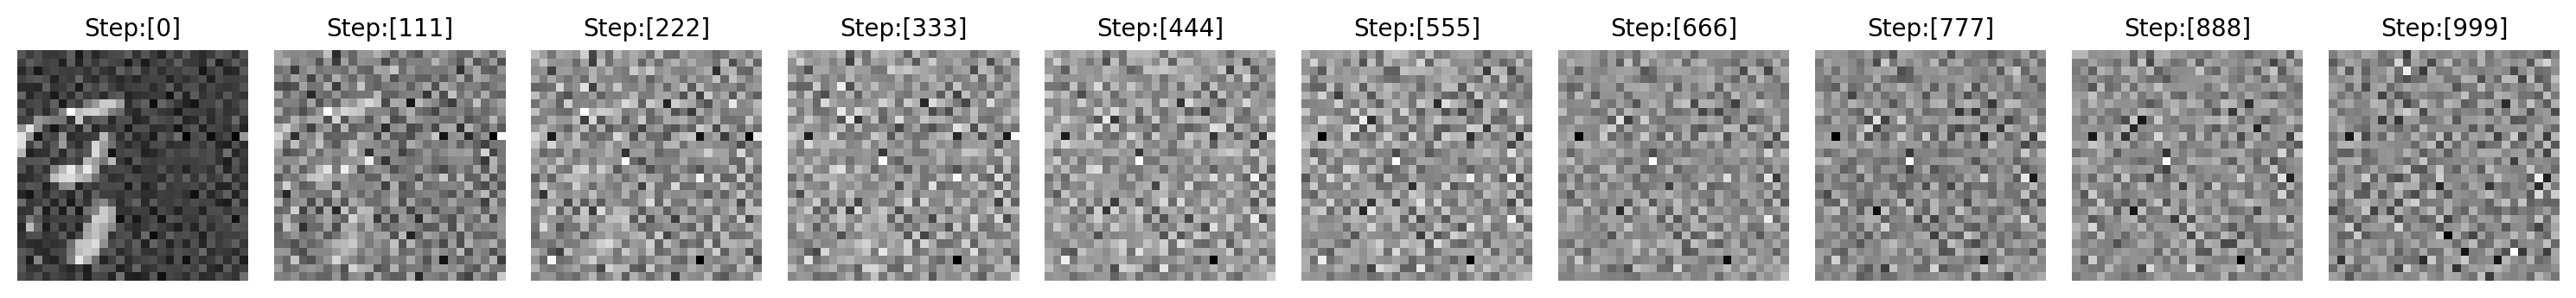

In [20]:

n_sample = 20
print("print number 0 position 2")
x_t_list = eval_ddpm_2d(model,dc,n_sample,x_0,step_list_to_append,device,torch.tensor([1,0,2,0], dtype=torch.float32).to(device))
# plot_ddpm_2d_result(x_0,step_list_to_append,x_t_list,n_plot=2)
# plot_ddpm_2d_result(x_0,step_list_to_append,x_t_list,n_plot=2)
plot_ddpm_2d_result_download(x_0,step_list_to_append,x_t_list,n_plot=2,save_path="./2d_example_result/left_right_simple/"+'_'.join([str(x) for x in [1,0,2,0]]))
n_sample = 20
print("print number 0 position 3")
x_t_list = eval_ddpm_2d(model,dc,n_sample,x_0,step_list_to_append,device,torch.tensor([1,0,3,0], dtype=torch.float32).to(device))
# plot_ddpm_2d_result(x_0,step_list_to_append,x_t_list,n_plot=2)
plot_ddpm_2d_result_download(x_0,step_list_to_append,x_t_list,n_plot=2,save_path="./2d_example_result/left_right_simple/"+'_'.join([str(x) for x in [1,0,3,0]]))


print("print number 0 position 10")
x_t_list = eval_ddpm_2d(model,dc,n_sample,x_0,step_list_to_append,device,torch.tensor([1,0,10,0], dtype=torch.float32).to(device))
# plot_ddpm_2d_result(x_0,step_list_to_append,x_t_list,n_plot=2)
plot_ddpm_2d_result_download(x_0,step_list_to_append,x_t_list,n_plot=2,save_path="./2d_example_result/left_right_simple/"+'_'.join([str(x) for x in [1,0,10,0]]))


In [24]:
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader
import numpy as np

# ModifiedMNISTDataset 클래스와 관련된 코드가 필요합니다.
# import된 데이터셋을 사용하여 변형된 MNIST 데이터셋을 로드합니다.
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 이미 제공된 ModifiedMNISTDataset 사용
# modified_train_dataset = ModifiedMNISTDataset(train_dataset, device)
dataloader = DataLoader(modified_train_dataset, batch_size=64, shuffle=False)

# 학습된 모델 로드
# model = torch.load('path_to_your_trained_model.pth')
model.eval()

# Latent 벡터 추출 및 레이블 저장
latents = []
labels = []
conditioning_vectors = []
with torch.no_grad():
    for data, target in dataloader:
        data, target = data.to(device), target.to(device)
        conditioning_vector = target  # 타겟 자체가 이미 conditioning vector 형태로 가정
        # forward 메소드를 사용하여 latent 벡터 추출
        # step_batch = th.randint(0, dc['T'],(batch_size,),device=device).to(th.int64) # [B]
        # latent_vector, _ = model(data, step_batch, conditioning_vector)

        # x_0_batch = x_0[idx,:,:,:] # [B x C x W x H]
        # Sample time steps
        step_batch = th.randint(0, dc['T'],(batch_size,),device=device).to(th.int64) # [B]
        # Forward diffusion sampling
        latent_vector,_ = forward_sample(data,step_batch,dc) # [B x C x W x H]


        latents.append(latent_vector)
        labels.append(target)
        conditioning_vectors.append(conditioning_vector)

latents = torch.cat(latents).cpu().numpy()
labels = torch.cat(labels).cpu().numpy()
conditioning_vectors = torch.cat(conditioning_vectors).cpu().numpy()

# Latent 벡터와 conditioning vector 결합
combined_latents = np.concatenate([latents, conditioning_vectors], axis=1)

# t-SNE를 사용하여 2D 공간으로 축소
tsne = TSNE(n_components=2, random_state=42)
latent_2d = tsne.fit_transform(combined_latents)

plt.figure(figsize=(10, 10))
scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels[:, 0], cmap='tab10', alpha=0.7)
plt.colorbar(scatter, ticks=range(10))
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE visualization of the modified MNIST latent space with conditioning vector')
plt.show()

RuntimeError: The size of tensor a (128) must match the size of tensor b (64) at non-singleton dimension 0

In [31]:

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

model.eval()
with torch.no_grad():
    embeddings = model(x_0.to(device), embedding_vectors_tensor.to(device))

# Use PCA and TSNE for dimensionality reduction
pca = PCA(n_components=50)
pca_result = pca.fit_transform(embeddings.cpu().numpy())

tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
tsne_result = tsne.fit_transform(pca_result)

# Plot the 2D TSNE result
plt.figure(figsize=(10, 7))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=[label[0].item() for label in embedding_vectors_tensor], cmap='viridis')
plt.colorbar()
plt.title("TSNE Visualization of Latent Space with Conditioning Vectors")
plt.show()

RuntimeError: The size of tensor a (4) must match the size of tensor b (32) at non-singleton dimension 2

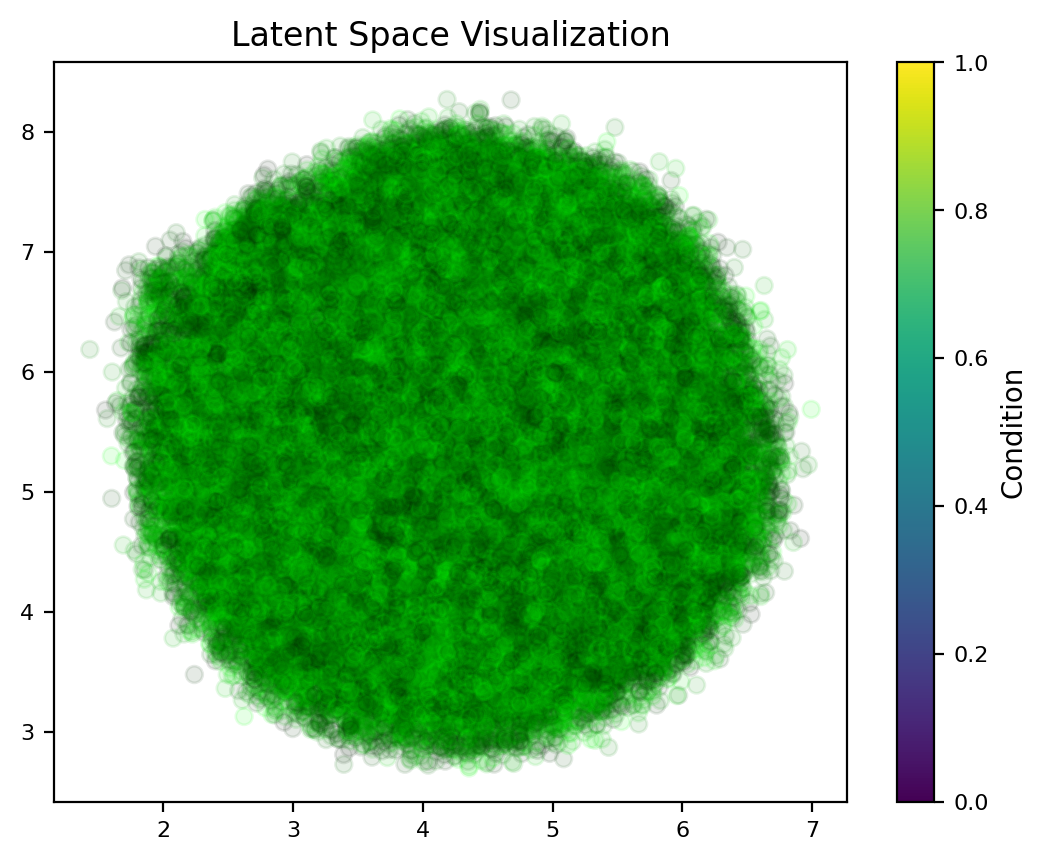

In [33]:
import torch
from tqdm import tqdm
import numpy as np
import umap.umap_ as umap

def get_latent_representation(x_0, embedding_vectors_tensor, model, dc, device, batch_size):
    all_latents = []
    all_conditions = []

    num_batches = x_0.shape[0] // batch_size + int(x_0.shape[0] % batch_size != 0)
    for batch_idx in range(num_batches):
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, x_0.shape[0])

        x_0_batch = x_0[start_idx:end_idx, :, :, :]  # [B x C x W x H]

        # Sample time steps
        step_batch = torch.randint(0, dc['T'], (end_idx - start_idx,), device=device).to(torch.int64)  # [B]

        # Forward diffusion sampling
        x_t_batch, noise = forward_sample(x_0_batch, step_batch, dc)  # [B x C x W x H]

        # Get partial embeddings
        partial_embeddings = torch.index_select(embedding_vectors_tensor, dim=0, index=torch.tensor(list(range(start_idx, end_idx)), device=device))

        # Noise prediction
        noise_pred, _ = model(x_t_batch, step_batch, partial_embeddings)  # [B x C x W x H]

        all_latents.append(noise_pred.cpu())
        all_conditions.append(partial_embeddings.cpu())

    all_latents = torch.cat(all_latents, dim=0)
    all_conditions = torch.cat(all_conditions, dim=0)

    # Reshape all_latents to 2D
    all_latents = all_latents.view(all_latents.size(0), -1)

    return all_latents, all_conditions


def visualize_latent_space(x_0, embedding_vectors_tensor, model, dc, device):
    model.eval()
    with torch.no_grad():
        batch_size = 64
        all_latents, all_conditions = get_latent_representation(x_0, embedding_vectors_tensor, model, dc, device, batch_size)

        # Reshape all_latents to 2D
        all_latents = all_latents.view(all_latents.size(0), -1)

        # Visualization code goes here
        reducer = umap.UMAP()
        embedding = reducer.fit_transform(all_latents.numpy())

        # Convert all_conditions to NumPy array
        all_conditions = all_conditions.numpy()

        min_val = np.min(all_conditions)
        max_val = np.max(all_conditions)
        all_conditions_normalized = (all_conditions - min_val) / (max_val - min_val)

        # Plot the embedding with condition labels
        import matplotlib.pyplot as plt
        plt.scatter(embedding[:, 0], embedding[:, 1], c=all_conditions_normalized)
        plt.colorbar(label='Condition')
        plt.title('Latent Space Visualization')
        plt.show()

# Usage
visualize_latent_space(x_0, embedding_vectors_tensor, model, dc, device)

In [ ]:
import torch
from tqdm import tqdm
import numpy as np
import umap.umap_ as umap

def get_latent_representation(x_0, embedding_vectors_tensor, model, dc, device, batch_size):
    all_latents = []
    all_conditions = []

    num_batches = x_0.shape[0] // batch_size + int(x_0.shape[0] % batch_size != 0)
    for batch_idx in range(num_batches):
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, x_0.shape[0])

        x_0_batch = x_0[start_idx:end_idx, :, :, :]  # [B x C x W x H]

        # Sample time steps
        step_batch = torch.randint(0, dc['T'], (end_idx - start_idx,), device=device).to(torch.int64)  # [B]

        # Forward diffusion sampling
        x_t_batch, noise = forward_sample(x_0_batch, step_batch, dc)  # [B x C x W x H]

        # Get partial embeddings
        partial_embeddings = torch.index_select(embedding_vectors_tensor, dim=0, index=torch.tensor(list(range(start_idx, end_idx)), device=device))

        # Noise prediction
        noise_pred, _ = model(x_t_batch, step_batch, partial_embeddings)  # [B x C x W x H]

        all_latents.append(noise_pred.cpu())
        all_conditions.append(partial_embeddings.cpu())

    all_latents = torch.cat(all_latents, dim=0)
    all_conditions = torch.cat(all_conditions, dim=0)

    # Reshape all_latents to 2D
    all_latents = all_latents.view(all_latents.size(0), -1)

    return all_latents, all_conditions


def visualize_latent_space(x_0, embedding_vectors_tensor, model, dc, device):
    model.eval()
    with torch.no_grad():
        batch_size = 64
        all_latents, all_conditions = get_latent_representation(x_0, embedding_vectors_tensor, model, dc, device, batch_size)

        # Reshape all_latents to 2D
        all_latents = all_latents.view(all_latents.size(0), -1)

        # Visualization code goes here
        reducer = umap.UMAP()
        embedding = reducer.fit_transform(all_latents.numpy())

        # Convert all_conditions to NumPy array
        all_conditions = all_conditions.numpy().astype(int)  # 숫자 레이블로 변환

        # Plot the embedding with condition labels
        import matplotlib.pyplot as plt
        plt.figure(figsize=(10, 7))
        scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=all_conditions, cmap='viridis')
        plt.colorbar(scatter.legend_)
        plt.title('Latent Space Visualization')
        plt.show()

# Usage
visualize_latent_space(x_0, embedding_vectors_tensor, model, dc, device)